In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def splice_curve(x, y, controls, n_points=300, method="linear", plot=True):
    """
    Splice a curve: keep original values up to the first control point,
    then rebuild the curve after that using control points.

    Returns
    -------
    df_out : DataFrame
        Columns:
          - x: union of all x values
          - original_y: y from original curve
          - modified_y: y from modified curve, falls back to original_y
                        if outside modified domain
    """
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)

    # --- sort original curve ---
    order = np.argsort(x)
    x_sorted = x[order]
    y_sorted = y[order]

    # --- controls ---
    controls = sorted(controls, key=lambda p: p[0])
    x_ctrl, y_ctrl = map(np.array, zip(*controls))
    x_cut = x_ctrl[0]

    # --- Part 1: keep original up to cutoff ---
    if x_cut < x_sorted.min():
        x_keep, y_keep = np.array([], dtype=float), np.array([], dtype=float)
    else:
        mask = x_sorted <= x_cut
        x_keep, y_keep = x_sorted[mask], y_sorted[mask]
        if len(x_keep) == 0 or x_keep[-1] < x_cut:
            y_cut = np.interp(x_cut, x_sorted, y_sorted)
            x_keep = np.append(x_keep, x_cut)
            y_keep = np.append(y_keep, y_cut)

    # --- Part 2: rebuild from controls ---
    span_orig = max(1e-12, x_sorted.max() - x_sorted.min())
    span_new = max(0.0, x_ctrl.max() - x_cut)
    n2 = max(2, int(n_points * span_new / span_orig))
    x_new = np.linspace(x_cut, x_ctrl.max(), n2)

    if method == "linear":
        y_new = np.interp(x_new, x_ctrl, y_ctrl)
    elif method == "pchip":
        from scipy.interpolate import PchipInterpolator
        y_new = PchipInterpolator(x_ctrl, y_ctrl)(x_new)
    elif method == "cubic":
        from scipy.interpolate import CubicSpline
        y_new = CubicSpline(x_ctrl, y_ctrl, bc_type="natural")(x_new)
    else:
        raise ValueError("method must be 'linear', 'pchip', or 'cubic'")

    # --- Combine modified curve ---
    if len(x_keep) and np.isclose(x_keep[-1], x_new[0]):
        x_mod = np.concatenate([x_keep, x_new[1:]])
        y_mod = np.concatenate([y_keep, y_new[1:]])
    else:
        x_mod = np.concatenate([x_keep, x_new])
        y_mod = np.concatenate([y_keep, y_new])

    # --- Merge into one DataFrame (preserve all points) ---
    all_x = np.unique(np.concatenate([x_sorted, x_mod]))
    df_out = pd.DataFrame({"x": all_x})
    df_out["original_y"] = np.interp(all_x, x_sorted, y_sorted,
                                     left=np.nan, right=np.nan)
    df_out["y"] = np.interp(all_x, x_mod, y_mod,
                                     left=np.nan, right=np.nan)

    # --- fill gaps in modified with original values ---
    df_out["y"] = df_out["y"].fillna(df_out["y"])

    # --- Plot ---
    if plot:
        plt.figure(figsize=(9,6))
        plt.plot(x_mod, y_mod, "r-", linewidth=2, label="Modified curve")
        plt.plot(x_sorted, y_sorted, "--", color="blue", linewidth=2.5, alpha=0.8, label="Original curve")
        plt.scatter(x_ctrl, y_ctrl, s=60, label="Control points")
        plt.xlabel("x"); plt.ylabel("y"); plt.title("Spliced curve")
        plt.legend(); plt.grid(True); plt.show()

    return df_out


In [4]:
import pandas as pd

def read_model_file(path):
    model = {}
    with open(path, "r") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            
            parts = line.split("\t", 1)
            if len(parts) == 1:
                # store a flag, or skip, depending on what you want
                key, val = parts[0], None
            else:
                key, val = parts
            
            # If it's a curve (comma-separated numbers)
            if val is not None and "," in val:
                try:
                    arr = [float(x) for x in val.split(",")]
                    model[key] = arr
                except ValueError:
                    model[key] = val
            else:
                try:
                    model[key] = float(val) if val is not None else None
                except (ValueError, TypeError):
                    model[key] = val
    return model

def format_curve_df(df_curve, name):
    x_str = ",".join(f"{v:.12g}" for v in df_curve["x"])
    y_str = ",".join(f"{v:.12g}" for v in df_curve["y"])
    return f"curve_x_{name}\t{x_str}\ncurve_y_{name}\t{y_str}"



In [5]:
import numpy as np
import pandas as pd

def extract_control_points(x, y, tolerance=1e-3):
    """
    Reduce a curve to control points using the Ramer–Douglas–Peucker algorithm.

    Parameters
    ----------
    x, y : array-like
        Original curve points.
    tolerance : float
        Max deviation allowed between original and simplified curve.
        Smaller = more points, larger = fewer points.

    Returns
    -------
    list of (x, y) control points
    """
    pts = np.column_stack((x, y))

    def rdp(points, eps):
        if len(points) < 3:
            return points
        # line between first and last
        start, end = points[0], points[-1]
        line_vec = end - start
        line_vec /= np.linalg.norm(line_vec) + 1e-12
        # distances to line
        dists = np.abs(np.cross(line_vec, points - start)) / np.linalg.norm(line_vec)
        idx = np.argmax(dists)
        dmax = dists[idx]
        if dmax > eps:
            # recursive split
            left = rdp(points[:idx+1], eps)
            right = rdp(points[idx:], eps)
            return np.vstack((left[:-1], right))
        else:
            return np.vstack((start, end))

    reduced = rdp(pts, tolerance)
    return [(float(px), float(py)) for px, py in reduced]


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, PchipInterpolator, CubicSpline

def rebuild_curve(controls, x_original=None, y_original=None,
                  n_points=200, method="pchip", plot=True, title=None):
    """
    Rebuild a curve from control points and optionally plot against the original.

    Parameters
    ----------
    controls : list of (x, y)
        Control points defining the curve.
    x_original, y_original : array-like, optional
        Original curve for comparison.
    n_points : int
        Number of output points for the rebuilt curve.
    method : str
        'linear', 'quadratic', 'pchip', or 'cubic'
    plot : bool
        Whether to show the plot.

    Returns
    -------
    DataFrame with columns:
        - x : new x values
        - y : rebuilt curve
    """
    # Sort controls
    controls = sorted(controls, key=lambda p: p[0])
    x_ctrl, y_ctrl = map(np.array, zip(*controls))

    # Build interpolator
    if method == "linear":
        f = interp1d(x_ctrl, y_ctrl, kind="linear", fill_value="extrapolate")
    elif method == "quadratic":
        f = interp1d(x_ctrl, y_ctrl, kind="quadratic", fill_value="extrapolate")
    elif method == "pchip":
        f = PchipInterpolator(x_ctrl, y_ctrl, extrapolate=True)
    elif method == "cubic":
        f = CubicSpline(x_ctrl, y_ctrl, bc_type="natural", extrapolate=True)
    else:
        raise ValueError("method must be 'linear', 'quadratic', 'pchip', or 'cubic'")

    # Generate evenly spaced x
    x_new = np.linspace(x_ctrl.min(), x_ctrl.max(), n_points)
    y_new = f(x_new)

    df_out = pd.DataFrame({"x": x_new, "y": y_new})

    # Plot
    if plot:
        plt.figure(figsize=(9, 6))
        if x_original is not None and y_original is not None:
            plt.plot(x_original, y_original, color="blue", linewidth=2.2, alpha=0.9, label="Original curve")
        plt.scatter(x_ctrl, y_ctrl, c="black", edgecolor="white", label="Control points")
        plt.plot(x_new, y_new, "--", color="red", linewidth=2, alpha=0.85, label="Rebuilt curve")
        plt.xlabel("x", fontsize=12)
        plt.ylabel("y", fontsize=12)
        plt.title(title if title else "Curve Replacement vs Original", fontsize=14, weight="bold")
        plt.legend(frameon=True, fontsize=10, loc="best")
        plt.grid(True, linestyle="--", alpha=0.6)

        plt.tight_layout()
        plt.show()


    return df_out


Control points: [(0.0, -0.0668868271781453), (0.207000545854884, -0.126557767234795), (0.365295080920384, -0.120848098162723), (0.487060107893846, -0.0712624641922019), (0.742766664538115, 0.100097457604218), (0.864531691511576, 0.161975055778549), (1.01064972387973, 0.198737228013706), (1.20547376703727, 0.209985446286538)]


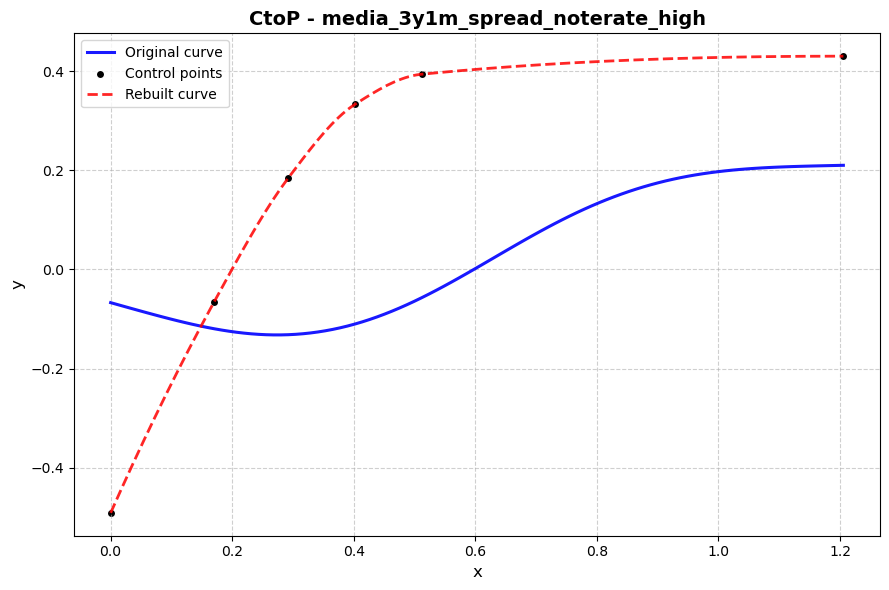

curve_x_media_3y1m_spread_noterate_high	0,0.00605765712079,0.0121153142416,0.0181729713624,0.0242306284832,0.030288285604,0.0363459427247,0.0424035998455,0.0484612569663,0.0545189140871,0.0605765712079,0.0666342283287,0.0726918854495,0.0787495425703,0.0848071996911,0.0908648568119,0.0969225139326,0.102980171053,0.109037828174,0.115095485295,0.121153142416,0.127210799537,0.133268456657,0.139326113778,0.145383770899,0.15144142802,0.157499085141,0.163556742261,0.169614399382,0.175672056503,0.181729713624,0.187787370744,0.193845027865,0.199902684986,0.205960342107,0.212017999228,0.218075656348,0.224133313469,0.23019097059,0.236248627711,0.242306284832,0.248363941952,0.254421599073,0.260479256194,0.266536913315,0.272594570436,0.278652227556,0.284709884677,0.290767541798,0.296825198919,0.30288285604,0.30894051316,0.314998170281,0.321055827402,0.327113484523,0.333171141643,0.339228798764,0.345286455885,0.351344113006,0.357401770127,0.363459427247,0.369517084368,0.375574741489,0.38163239861,0.

In [496]:
model = read_model_file(r"C:\Git\LMSimData_prod\data\JUMBO2\ModelFiles\1.8.0\original\jumbo_refinance_1.5.update_2025_12_03_03_07_43.061899.txt")

df_original = pd.DataFrame({
    "x": model["curve_x_media_3y1m_spread_noterate_low"],
    "y": model["curve_y_media_3y1m_spread_noterate_low"]
})

controls = extract_control_points(df_original["x"], df_original["y"], tolerance=0.01)
print("Control points:", controls) 

df_curve = rebuild_curve(
    controls=[(0.0, -0.49072970126618), (0.170471037762846, -0.0648331980476545), (0.292236064736307, 0.184509838605126), (0.401824589012423, 0.332811939251801), (0.511413113288538, 0.393577996381893), (1.20547376703727, 0.43)],
    x_original=model["curve_x_media_3y1m_spread_noterate_low"],
    y_original=model["curve_y_media_3y1m_spread_noterate_low"],
    method="pchip",
    title='CtoP - media_3y1m_spread_noterate_high'
)

formatted_txt = format_curve_df(df_curve, "media_3y1m_spread_noterate_high")
print(formatted_txt)

Control points: [(0.0, -0.487315736013457), (0.170471037762846, -0.12215163821702), (0.292236064736307, 0.0982119801823587), (0.414001091709769, 0.251731586553656), (0.523589615985884, 0.320063641543962), (0.633178140261999, 0.32510079664438), (0.754943167235461, 0.275453083415941), (0.913237702300961, 0.163469333892843), (1.20547376703727, -0.0812537390485704)]


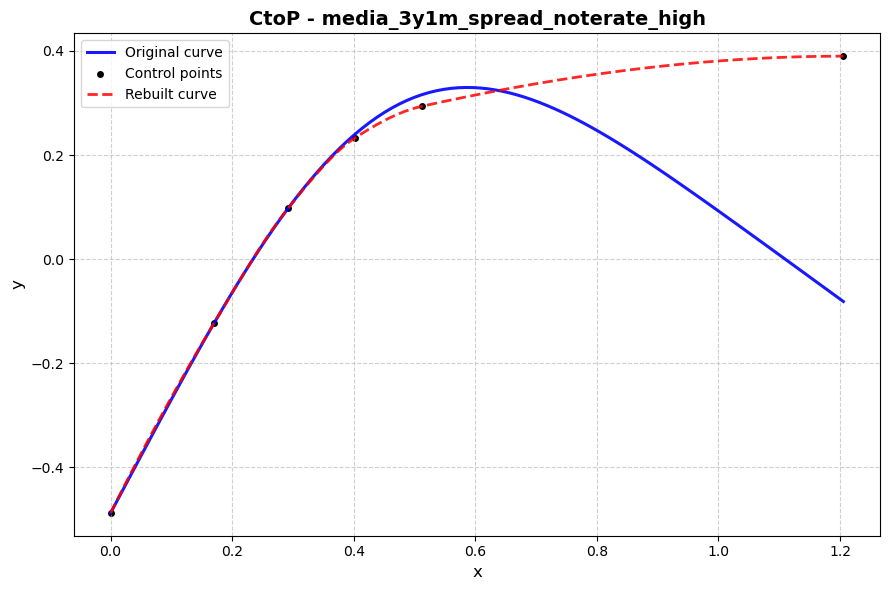

curve_x_media_3y1m_spread_noterate_high	0,0.00605765712079,0.0121153142416,0.0181729713624,0.0242306284832,0.030288285604,0.0363459427247,0.0424035998455,0.0484612569663,0.0545189140871,0.0605765712079,0.0666342283287,0.0726918854495,0.0787495425703,0.0848071996911,0.0908648568119,0.0969225139326,0.102980171053,0.109037828174,0.115095485295,0.121153142416,0.127210799537,0.133268456657,0.139326113778,0.145383770899,0.15144142802,0.157499085141,0.163556742261,0.169614399382,0.175672056503,0.181729713624,0.187787370744,0.193845027865,0.199902684986,0.205960342107,0.212017999228,0.218075656348,0.224133313469,0.23019097059,0.236248627711,0.242306284832,0.248363941952,0.254421599073,0.260479256194,0.266536913315,0.272594570436,0.278652227556,0.284709884677,0.290767541798,0.296825198919,0.30288285604,0.30894051316,0.314998170281,0.321055827402,0.327113484523,0.333171141643,0.339228798764,0.345286455885,0.351344113006,0.357401770127,0.363459427247,0.369517084368,0.375574741489,0.38163239861,0.

In [102]:
model = read_model_file(r"C:\Git\LMSimData_prod\data\JUMBO2\ModelFiles\1.8.0\original\jumbo_refinance_1.5.update_2025_12_03_03_07_43.061899.txt")

df_original = pd.DataFrame({
    "x": model["curve_x_media_3y1m_spread_noterate_high"],
    "y": model["curve_y_media_3y1m_spread_noterate_high"]
})

controls = extract_control_points(df_original["x"], df_original["y"], tolerance=0.01)
print("Control points:", controls) 

df_curve = rebuild_curve(
    controls=[(0.0, -0.487315736013457), (0.170471037762846, -0.12215163821702), (0.292236064736307, 0.0982119801823587), (0.401824589012423, 0.232811939251801), (0.511413113288538, 0.293577996381893), (1.20547376703727, 0.39)],
    x_original=model["curve_x_media_3y1m_spread_noterate_high"],
    y_original=model["curve_y_media_3y1m_spread_noterate_high"],
    method="pchip",
    title='CtoP - media_3y1m_spread_noterate_high'
)

formatted_txt = format_curve_df(df_curve, "media_3y1m_spread_noterate_high")
print(formatted_txt)

Control points: [(0.0, -0.00472357391200532), (41.010101010101, 0.0345328079120335), (55.1515151515151, 0.0237387203846176), (67.8787878787879, -0.0062648733953013), (82.020202020202, -0.0610069275995281), (97.5757575757576, -0.142862739398444), (140.0, -0.431680789382393)]


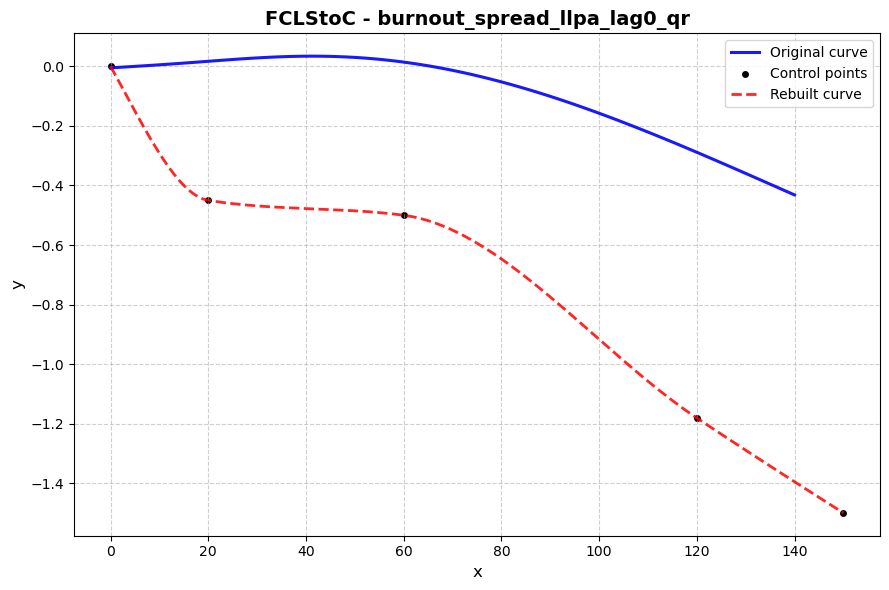

curve_x_burnout_spread_llpa_lag0_qr	0,0.753768844221,1.50753768844,2.26130653266,3.01507537688,3.76884422111,4.52261306533,5.27638190955,6.03015075377,6.78391959799,7.53768844221,8.29145728643,9.04522613065,9.79899497487,10.5527638191,11.3065326633,12.0603015075,12.8140703518,13.567839196,14.3216080402,15.0753768844,15.8291457286,16.5829145729,17.3366834171,18.0904522613,18.8442211055,19.5979899497,20.351758794,21.1055276382,21.8592964824,22.6130653266,23.3668341709,24.1206030151,24.8743718593,25.6281407035,26.3819095477,27.135678392,27.8894472362,28.6432160804,29.3969849246,30.1507537688,30.9045226131,31.6582914573,32.4120603015,33.1658291457,33.9195979899,34.6733668342,35.4271356784,36.1809045226,36.9346733668,37.6884422111,38.4422110553,39.1959798995,39.9497487437,40.7035175879,41.4572864322,42.2110552764,42.9648241206,43.7185929648,44.472361809,45.2261306533,45.9798994975,46.7336683417,47.4874371859,48.2412060302,48.9949748744,49.7487437186,50.5025125628,51.256281407,52.0100502513,

In [33]:
model = read_model_file(r"C:\Git\LMSimData_prod\data\JUMBO2\ModelFiles\1.8.0\original\jumbo_refinance_1.5.update_2025_12_03_03_07_43.061899.txt")

df_original = pd.DataFrame({
    "x": model["curve_x_burnout_spread_llpa_lag0_qr"],
    "y": model["curve_y_burnout_spread_llpa_lag0_qr"]
})

controls = extract_control_points(df_original["x"], df_original["y"], tolerance=0.01)
print("Control points:", controls) 

df_curve = rebuild_curve(
    controls=[(0.0, 0), (20, -0.45), (60, -0.5), (120, -1.181146223956021), (150, -1.5)],
    x_original=model["curve_x_burnout_spread_llpa_lag0_qr"],
    y_original=model["curve_y_burnout_spread_llpa_lag0_qr"],
    method="pchip",
    title='FCLStoC - burnout_spread_llpa_lag0_qr'
)


formatted_txt = format_curve_df(df_curve, "burnout_spread_llpa_lag0_qr")
print(formatted_txt)


Control points: [(0.85, -0.606107104038957), (0.89040404040404, -0.393506998444197), (0.915656565656566, -0.274691021064075), (0.935858585858586, -0.197975932872659), (0.956060606060606, -0.142973515125238), (0.971212121212121, -0.11672452735261), (0.981313131313131, -0.105833540283595), (0.991414141414141, -0.0995308964206296), (1.00151515151515, -0.0970291709498181), (1.01161616161616, -0.0974001832165816), (1.0520202020202, -0.108689459619766), (1.07222222222222, -0.109147381011527), (1.08232323232323, -0.106079321372575), (1.09242424242424, -0.100270828216672), (1.10252525252525, -0.0913755600037306), (1.11262626262626, -0.0791380154291608), (1.12777777777778, -0.0542892637267553), (1.1479797979798, -0.0097576126068217), (1.16818181818182, 0.0447278225105874), (1.21868686868687, 0.193305292503685), (1.23888888888889, 0.24612214129145), (1.2540404040404, 0.28088243153676), (1.27424242424242, 0.320576967340736), (1.29444444444444, 0.353724646662523), (1.31969696969697, 0.388768723393

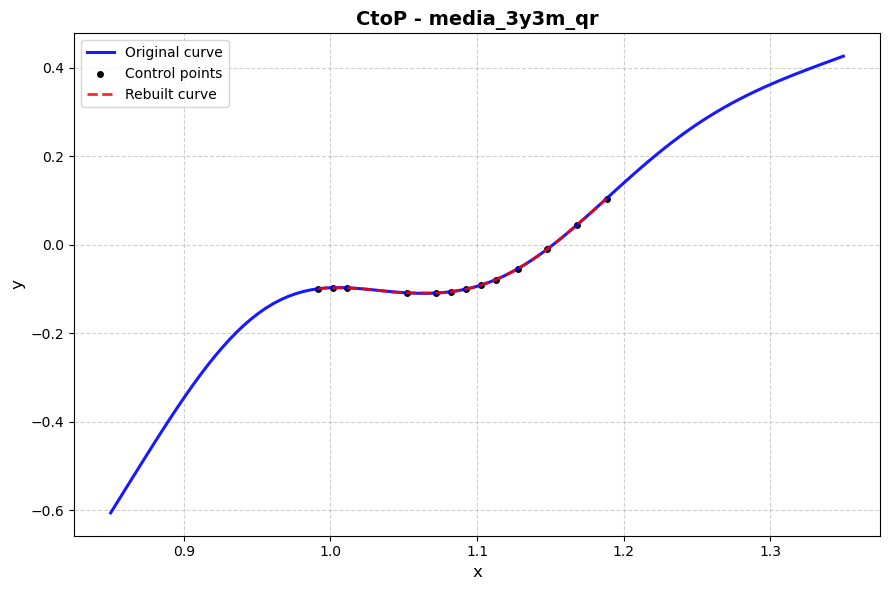

curve_x_media_3y3m_qr	0.991414141414,0.992403938886,0.993393736359,0.994383533831,0.995373331303,0.996363128775,0.997352926247,0.99834272372,0.999332521192,1.00032231866,1.00131211614,1.00230191361,1.00329171108,1.00428150855,1.00527130603,1.0062611035,1.00725090097,1.00824069844,1.00923049591,1.01022029339,1.01121009086,1.01219988833,1.0131896858,1.01417948327,1.01516928075,1.01615907822,1.01714887569,1.01813867316,1.01912847064,1.02011826811,1.02110806558,1.02209786305,1.02308766052,1.024077458,1.02506725547,1.02605705294,1.02704685041,1.02803664789,1.02902644536,1.03001624283,1.0310060403,1.03199583777,1.03298563525,1.03397543272,1.03496523019,1.03595502766,1.03694482514,1.03793462261,1.03892442008,1.03991421755,1.04090401502,1.0418938125,1.04288360997,1.04387340744,1.04486320491,1.04585300239,1.04684279986,1.04783259733,1.0488223948,1.04981219227,1.05080198975,1.05179178722,1.05278158469,1.05377138216,1.05476117964,1.05575097711,1.05674077458,1.05773057205,1.05872036952,1.059710167

In [16]:
model = read_model_file(r"C:\Git\LMSimData_prod\data\JUMBO2\ModelFiles\1.8.0\original\jumbo_refinance_1.5.update_2025_11_30_17_12_13.138016.txt")

df_original = pd.DataFrame({
    "x": model["curve_x_media_3y3m_qr"],
    "y": model["curve_y_media_3y3m_qr"]
})

controls = extract_control_points(df_original["x"], df_original["y"], tolerance=0.001)
print("Control points:", controls) 

df_curve = rebuild_curve(
    controls=[(0.991414141414141, -0.0995308964206296), (1.00151515151515, -0.0970291709498181), (1.01161616161616, -0.0974001832165816), (1.0520202020202, -0.108689459619766), (1.07222222222222, -0.109147381011527), (1.08232323232323, -0.106079321372575), (1.09242424242424, -0.100270828216672), (1.10252525252525, -0.0913755600037306), (1.11262626262626, -0.0791380154291608), (1.12777777777778, -0.0542892637267553), (1.1479797979798, -0.0097576126068217), (1.16818181818182, 0.0447278225105874), (1.18838383838384, 0.104481085293427)],
    x_original=model["curve_x_media_3y3m_qr"],
    y_original=model["curve_y_media_3y3m_qr"],
    method="pchip",
    title='CtoP - media_3y3m_qr'
)

formatted_txt = format_curve_df(df_curve, "media_3y3m_qr")
print(formatted_txt)

Control points: [(0.85, -0.606107104038957), (0.89040404040404, -0.393506998444197), (0.915656565656566, -0.274691021064075), (0.935858585858586, -0.197975932872659), (0.956060606060606, -0.142973515125238), (0.971212121212121, -0.11672452735261), (0.981313131313131, -0.105833540283595), (0.991414141414141, -0.0995308964206296), (1.00151515151515, -0.0970291709498181), (1.01161616161616, -0.0974001832165816), (1.0520202020202, -0.108689459619766), (1.07222222222222, -0.109147381011527), (1.08232323232323, -0.106079321372575), (1.09242424242424, -0.100270828216672), (1.10252525252525, -0.0913755600037306), (1.11262626262626, -0.0791380154291608), (1.12777777777778, -0.0542892637267553), (1.1479797979798, -0.0097576126068217), (1.16818181818182, 0.0447278225105874), (1.21868686868687, 0.193305292503685), (1.23888888888889, 0.24612214129145), (1.2540404040404, 0.28088243153676), (1.27424242424242, 0.320576967340736), (1.29444444444444, 0.353724646662523), (1.31969696969697, 0.388768723393

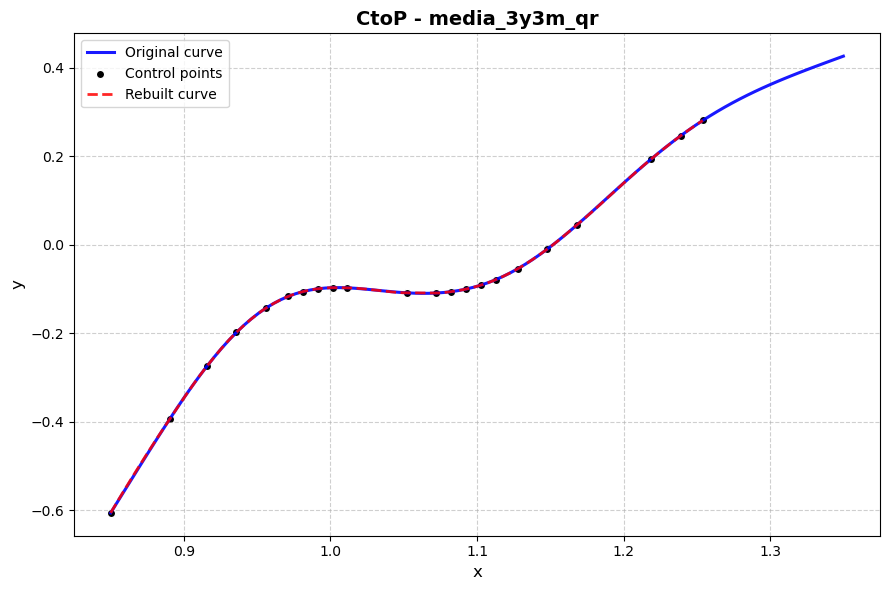

curve_x_media_3y3m_qr	0.85,0.852030353789,0.854060707578,0.856091061367,0.858121415157,0.860151768946,0.862182122735,0.864212476524,0.866242830313,0.868273184102,0.870303537891,0.872333891681,0.87436424547,0.876394599259,0.878424953048,0.880455306837,0.882485660626,0.884516014416,0.886546368205,0.888576721994,0.890607075783,0.892637429572,0.894667783361,0.89669813715,0.89872849094,0.900758844729,0.902789198518,0.904819552307,0.906849906096,0.908880259885,0.910910613674,0.912940967464,0.914971321253,0.917001675042,0.919032028831,0.92106238262,0.923092736409,0.925123090198,0.927153443988,0.929183797777,0.931214151566,0.933244505355,0.935274859144,0.937305212933,0.939335566723,0.941365920512,0.943396274301,0.94542662809,0.947456981879,0.949487335668,0.951517689457,0.953548043247,0.955578397036,0.957608750825,0.959639104614,0.961669458403,0.963699812192,0.965730165981,0.967760519771,0.96979087356,0.971821227349,0.973851581138,0.975881934927,0.977912288716,0.979942642505,0.981972996295,0.98

In [ ]:
model = read_model_file(r"C:\Git\LMSimData_prod\data\JUMBO2\ModelFiles\1.8.0\original\jumbo_refinance_1.5.update_2025_11_30_17_12_13.138016.txt")

df_original = pd.DataFrame({
    "x": model["curve_x_media_3y3m_qr"],
    "y": model["curve_y_media_3y3m_qr"]
})

controls = extract_control_points(df_original["x"], df_original["y"], tolerance=0.001)
print("Control points:", controls) 

df_curve = rebuild_curve(
    controls=[(0.85, -0.606107104038957), (0.89040404040404, -0.393506998444197), (0.915656565656566, -0.274691021064075), (0.935858585858586, -0.197975932872659), (0.956060606060606, -0.142973515125238), (0.971212121212121, -0.11672452735261), (0.981313131313131, -0.105833540283595), (0.991414141414141, -0.0995308964206296), (1.00151515151515, -0.0970291709498181), (1.01161616161616, -0.0974001832165816), (1.0520202020202, -0.108689459619766), (1.07222222222222, -0.109147381011527), (1.08232323232323, -0.106079321372575), (1.09242424242424, -0.100270828216672), (1.10252525252525, -0.0913755600037306), (1.11262626262626, -0.0791380154291608), (1.12777777777778, -0.0542892637267553), (1.1479797979798, -0.0097576126068217), (1.16818181818182, 0.0447278225105874), (1.21868686868687, 0.193305292503685), (1.23888888888889, 0.24612214129145), (1.2540404040404, 0.28088243153676)],
    x_original=model["curve_x_media_3y3m_qr"],
    y_original=model["curve_y_media_3y3m_qr"],
    method="pchip",
    title='CtoP - media_3y3m_qr'
)

formatted_txt = format_curve_df(df_curve, "media_3y3m_qr")
print(formatted_txt)

Control points: [(-0.0999999999999996, -2.27591327897139), (0.0777777777777781, -1.62675519169516), (0.322222222222223, -0.397826015557856), (0.433333333333334, 0.0772210983012044), (0.566666666666667, 0.503791212590005), (0.722222222222222, 0.848103900193313), (0.855555555555556, 1.06040122815354), (0.966666666666667, 1.19487900262661), (1.05555555555556, 1.2726436856586), (1.3, 1.43680713941491), (1.38888888888889, 1.47372470741738), (1.56666666666667, 1.49546505174173), (1.76666666666667, 1.57374995425591), (2.1, 1.66824348579267)]


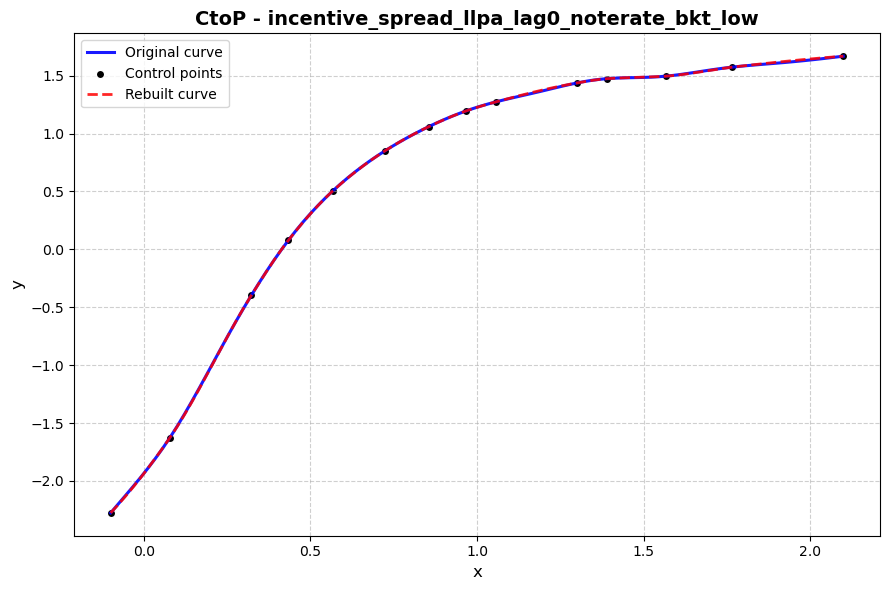

curve_x_incentive_spread_llpa_lag0_noterate_bkt_low	-0.1,-0.0889447236181,-0.0778894472362,-0.0668341708543,-0.0557788944724,-0.0447236180905,-0.0336683417085,-0.0226130653266,-0.0115577889447,-0.000502512562814,0.0105527638191,0.021608040201,0.0326633165829,0.0437185929648,0.0547738693467,0.0658291457286,0.0768844221106,0.0879396984925,0.0989949748744,0.110050251256,0.121105527638,0.13216080402,0.143216080402,0.154271356784,0.165326633166,0.176381909548,0.18743718593,0.198492462312,0.209547738693,0.220603015075,0.231658291457,0.242713567839,0.253768844221,0.264824120603,0.275879396985,0.286934673367,0.297989949749,0.309045226131,0.320100502513,0.331155778894,0.342211055276,0.353266331658,0.36432160804,0.375376884422,0.386432160804,0.397487437186,0.408542713568,0.41959798995,0.430653266332,0.441708542714,0.452763819095,0.463819095477,0.474874371859,0.485929648241,0.496984924623,0.508040201005,0.519095477387,0.530150753769,0.541206030151,0.552261306533,0.563316582915,0.574371859296,0.58

In [ ]:
model = read_model_file(r"C:\Git\LMSimData_prod\data\JUMBO2\ModelFiles\1.8.0\original\jumbo_refinance_1.5.update_2025_11_30_17_12_13.138016.txt")

df_original = pd.DataFrame({
    "x": model["curve_x_incentive_spread_llpa_lag0_noterate_bkt_low"],
    "y": model["curve_y_incentive_spread_llpa_lag0_noterate_bkt_low"]
})

controls = extract_control_points(df_original["x"], df_original["y"], tolerance=0.01)
print("Control points:", controls) 

df_curve = rebuild_curve(
    controls=[(-0.0999999999999996, -2.27591327897139), (0.0777777777777781, -1.62675519169516), (0.322222222222223, -0.397826015557856), (0.433333333333334, 0.0772210983012044), (0.566666666666667, 0.503791212590005), (0.722222222222222, 0.848103900193313), (0.855555555555556, 1.06040122815354), (0.966666666666667, 1.19487900262661), (1.05555555555556, 1.2726436856586), (1.3, 1.43680713941491), (1.38888888888889, 1.47372470741738), (1.56666666666667, 1.49546505174173), (1.76666666666667, 1.57374995425591), (2.1, 1.66824348579267)],
    x_original=model["curve_x_incentive_spread_llpa_lag0_noterate_bkt_low"],
    y_original=model["curve_y_incentive_spread_llpa_lag0_noterate_bkt_low"],
    method="pchip",
    title='CtoP - incentive_spread_llpa_lag0_noterate_bkt_low'
)

formatted_txt = format_curve_df(df_curve, "incentive_spread_llpa_lag0_noterate_bkt_low")
print(formatted_txt)

In [ ]:
df_original

,x,y
0,-0.100000,-1.946477
1,-0.077778,-1.859890
2,-0.055556,-1.773498
3,-0.033333,-1.687350
4,-0.011111,-1.601498
...,...,...
95,2.011111,1.679241
96,2.033333,1.672162
97,2.055556,1.664518
98,2.077778,1.656423


Control points: [(-0.0999999999999996, -1.94647720885891), (0.211111111111111, -0.772875925389085), (0.322222222222223, -0.39948015912059), (0.411111111111111, -0.134095959820826), (0.5, 0.0942381814945077), (0.611111111111111, 0.33457565526074), (0.966666666666667, 0.983615236446114), (1.05555555555556, 1.11491877217102), (1.16666666666667, 1.24127398230791), (1.38888888888889, 1.41174963363467), (1.61111111111111, 1.59821010820174), (1.7, 1.65862556268886), (1.78888888888889, 1.69427382313345), (1.87777777777778, 1.70333704317006), (1.96666666666667, 1.69123379847511), (2.1, 1.64799492282183)]


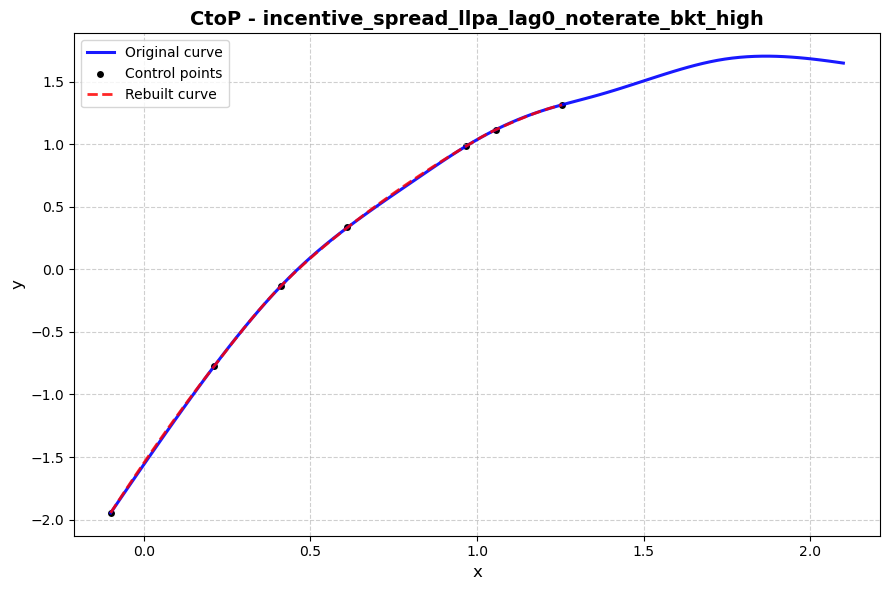

curve_x_incentive_spread_llpa_lag0_noterate_bkt_high	-0.1,-0.0931881630374,-0.0863763260748,-0.0795644891122,-0.0727526521496,-0.065940815187,-0.0591289782245,-0.0523171412619,-0.0455053042993,-0.0386934673367,-0.0318816303741,-0.0250697934115,-0.0182579564489,-0.0114461194863,-0.00463428252373,0.00217755443886,0.00898939140145,0.015801228364,0.0226130653266,0.0294249022892,0.0362367392518,0.0430485762144,0.049860413177,0.0566722501396,0.0634840871022,0.0702959240648,0.0771077610274,0.08391959799,0.0907314349525,0.0975432719151,0.104355108878,0.11116694584,0.117978782803,0.124790619765,0.131602456728,0.138414293691,0.145226130653,0.152037967616,0.158849804578,0.165661641541,0.172473478504,0.179285315466,0.186097152429,0.192908989391,0.199720826354,0.206532663317,0.213344500279,0.220156337242,0.226968174204,0.233780011167,0.24059184813,0.247403685092,0.254215522055,0.261027359017,0.26783919598,0.274651032942,0.281462869905,0.288274706868,0.29508654383,0.301898380793,0.308710217755,0.315

In [ ]:
model = read_model_file(r"C:\Git\LMSimData_prod\data\JUMBO2\ModelFiles\1.8.0\original\jumbo_refinance_1.5.update_2025_11_30_17_12_13.138016.txt")

df_original = pd.DataFrame({
    "x": model["curve_x_incentive_spread_llpa_lag0_noterate_bkt_high"],
    "y": model["curve_y_incentive_spread_llpa_lag0_noterate_bkt_high"]
})

controls = extract_control_points(df_original["x"], df_original["y"], tolerance=0.005)
print("Control points:", controls) 

df_curve = rebuild_curve(
    controls=[(-0.0999999999999996, -1.94647720885891), (0.211111111111111, -0.772875925389085), (0.411111111111111, -0.134095959820826), (0.611111111111111, 0.33457565526074), (0.966666666666667, 0.983615236446114), (1.05555555555556, 1.11491877217102), (1.25555555555556, 1.31488603354192)],
    x_original=model["curve_x_incentive_spread_llpa_lag0_noterate_bkt_high"],
    y_original=model["curve_y_incentive_spread_llpa_lag0_noterate_bkt_high"],
    method="pchip",
    title='CtoP - incentive_spread_llpa_lag0_noterate_bkt_high'
)

formatted_txt = format_curve_df(df_curve, "incentive_spread_llpa_lag0_noterate_bkt_high")
print(formatted_txt)

Control points: [(0.0, -0.301784198005997), (0.0363636363636364, -0.151338770420314), (0.0787878787878788, -0.0678936663664773), (0.115151515151515, -0.0501459461685125), (0.218181818181818, -0.0704160557661599), (0.272727272727273, 0.00367316792675909), (0.315151515151515, 0.163735491842595), (0.418181818181818, 0.747936537048897), (0.448484848484848, 0.852539430221009), (0.472727272727273, 0.878061226317678), (0.509090909090909, 0.784639591443894), (0.539393939393939, 0.554186640132858), (0.6, -0.44460087473869)]


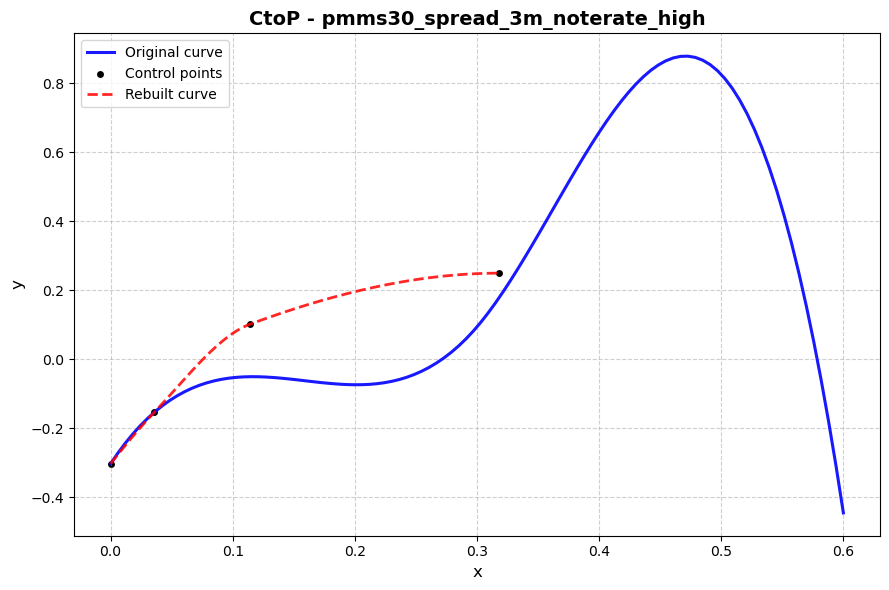

curve_x_pmms30_spread_3m_noterate_high	0,0.0015995922968,0.0031991845936,0.0047987768904,0.0063983691872,0.00799796148399,0.00959755378079,0.0111971460776,0.0127967383744,0.0143963306712,0.015995922968,0.0175955152648,0.0191951075616,0.0207946998584,0.0223942921552,0.023993884452,0.0255934767488,0.0271930690456,0.0287926613424,0.0303922536392,0.031991845936,0.0335914382328,0.0351910305296,0.0367906228264,0.0383902151232,0.03998980742,0.0415893997168,0.0431889920136,0.0447885843104,0.0463881766072,0.047987768904,0.0495873612008,0.0511869534976,0.0527865457944,0.0543861380912,0.055985730388,0.0575853226848,0.0591849149816,0.0607845072784,0.0623840995752,0.063983691872,0.0655832841688,0.0671828764656,0.0687824687624,0.0703820610592,0.071981653356,0.0735812456528,0.0751808379496,0.0767804302464,0.0783800225432,0.0799796148399,0.0815792071367,0.0831787994335,0.0847783917303,0.0863779840271,0.0879775763239,0.0895771686207,0.0911767609175,0.0927763532143,0.0943759455111,0.0959755378079,0.0975

In [147]:
model = read_model_file(r"C:\Git\LMSimData_prod\data\JUMBO2\ModelFiles\1.8.0\original\jumbo_refinance_1.5.update_2025_11_30_17_12_13.138016.txt")

df_original = pd.DataFrame({
    "x": model["curve_x_pmms30_spread_3m_noterate_high"],
    "y": model["curve_y_pmms30_spread_3m_noterate_high"]
})

controls = extract_control_points(df_original["x"], df_original["y"], tolerance=0.01)
print("Control points:", controls) 

df_curve = rebuild_curve(
    controls=[(0.0, -0.301784198006), (0.0356327089995, -0.153520894825), (0.114024668799, 0.10169210997), (0.318318867063, 0.2496888001)],
    # (0.0, -0.301784198006), (0.0356327089995, -0.153520894825), (0.114024668799, 0.10169210997), (0.318318867063, 0.3796888001), (0.4, 0.43), (0.5, 0.48)
    x_original=model["curve_x_pmms30_spread_3m_noterate_high"],
    y_original=model["curve_y_pmms30_spread_3m_noterate_high"],
    method="pchip",
    title='CtoP - pmms30_spread_3m_noterate_high'
)

formatted_txt = format_curve_df(df_curve, "pmms30_spread_3m_noterate_high")
print(formatted_txt)

Control points: [(0.0, -0.301784198006), (0.117587939698, 0.108924699508), (0.225376884422, 0.284313530262), (0.349497487437, 0.403414649663), (0.467085427136, 0.447158938395), (0.506281407035, 0.449360930559), (0.53567839196, 0.432974485061), (0.568341708543, 0.387704512817), (0.65, 0.15)]


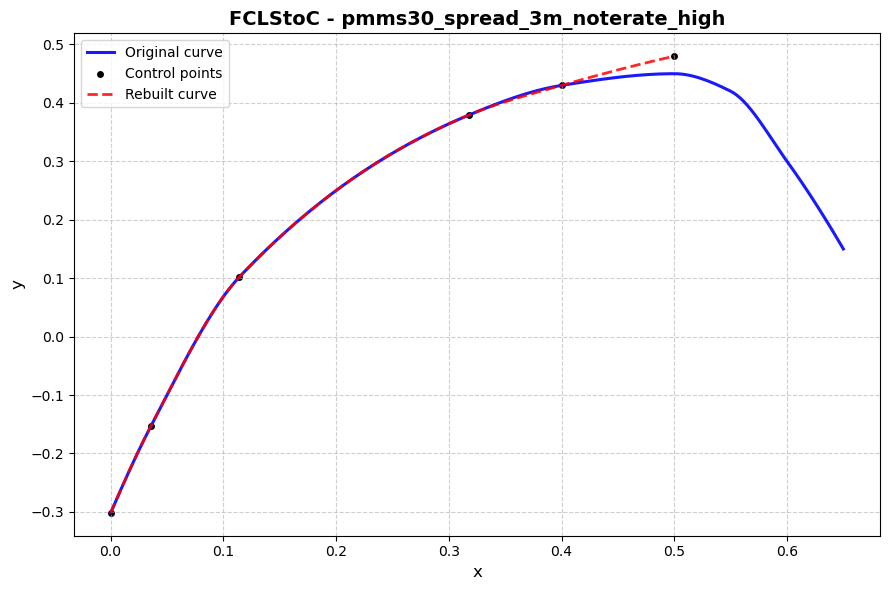

curve_x_pmms30_spread_3m_noterate_high	0,0.00251256281407,0.00502512562814,0.00753768844221,0.0100502512563,0.0125628140704,0.0150753768844,0.0175879396985,0.0201005025126,0.0226130653266,0.0251256281407,0.0276381909548,0.0301507537688,0.0326633165829,0.035175879397,0.0376884422111,0.0402010050251,0.0427135678392,0.0452261306533,0.0477386934673,0.0502512562814,0.0527638190955,0.0552763819095,0.0577889447236,0.0603015075377,0.0628140703518,0.0653266331658,0.0678391959799,0.070351758794,0.072864321608,0.0753768844221,0.0778894472362,0.0804020100503,0.0829145728643,0.0854271356784,0.0879396984925,0.0904522613065,0.0929648241206,0.0954773869347,0.0979899497487,0.100502512563,0.103015075377,0.105527638191,0.108040201005,0.110552763819,0.113065326633,0.115577889447,0.118090452261,0.120603015075,0.123115577889,0.125628140704,0.128140703518,0.130653266332,0.133165829146,0.13567839196,0.138190954774,0.140703517588,0.143216080402,0.145728643216,0.14824120603,0.150753768844,0.153266331658,0.15577

In [ ]:
model = read_model_file(r"C:\Git\LMSimData_prod\data\JUMBO2\ModelFiles\1.8.0\jumbo_refinance_1.5.update_2025_11_30_17_12_13.138016.txt")

df_original = pd.DataFrame({
    "x": model["curve_x_pmms30_spread_3m_noterate_high"],
    "y": model["curve_y_pmms30_spread_3m_noterate_high"]
})

controls = extract_control_points(df_original["x"], df_original["y"], tolerance=0.01)
print("Control points:", controls) 

df_curve = rebuild_curve(
    controls=[(0.0, -0.301784198006), (0.0356327089995, -0.153520894825), (0.114024668799, 0.10169210997), (0.318318867063, 0.3796888001), (0.4, 0.43), (0.5, 0.48)],
    x_original=model["curve_x_pmms30_spread_3m_noterate_high"],
    y_original=model["curve_y_pmms30_spread_3m_noterate_high"],
    method="pchip",
    title='FCLStoC - pmms30_spread_3m_noterate_high'
)


formatted_txt = format_curve_df(df_curve, "pmms30_spread_3m_noterate_high")
print(formatted_txt)


Control points: [(-0.0999999999999996, -2.27591327897139), (0.0777777777777781, -1.62675519169516), (0.322222222222223, -0.397826015557856), (0.433333333333334, 0.0772210983012044), (0.566666666666667, 0.503791212590005), (0.722222222222222, 0.848103900193313), (0.855555555555556, 1.06040122815354), (0.966666666666667, 1.19487900262661), (1.05555555555556, 1.2726436856586), (1.3, 1.43680713941491), (1.38888888888889, 1.47372470741738), (1.56666666666667, 1.49546505174173), (1.76666666666667, 1.57374995425591), (2.1, 1.66824348579267)]


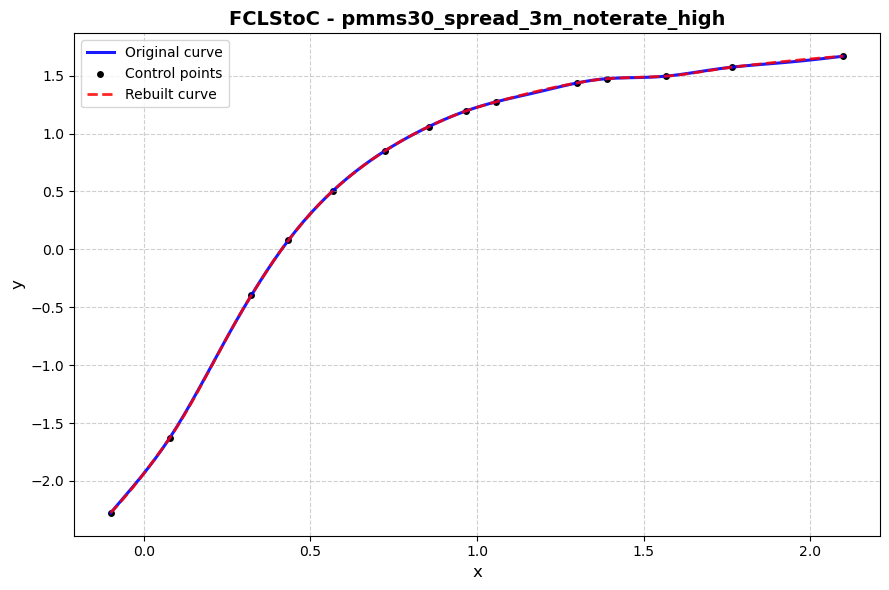

curve_x_pmms30_spread_3m_noterate_high	-0.1,-0.0889447236181,-0.0778894472362,-0.0668341708543,-0.0557788944724,-0.0447236180905,-0.0336683417085,-0.0226130653266,-0.0115577889447,-0.000502512562814,0.0105527638191,0.021608040201,0.0326633165829,0.0437185929648,0.0547738693467,0.0658291457286,0.0768844221106,0.0879396984925,0.0989949748744,0.110050251256,0.121105527638,0.13216080402,0.143216080402,0.154271356784,0.165326633166,0.176381909548,0.18743718593,0.198492462312,0.209547738693,0.220603015075,0.231658291457,0.242713567839,0.253768844221,0.264824120603,0.275879396985,0.286934673367,0.297989949749,0.309045226131,0.320100502513,0.331155778894,0.342211055276,0.353266331658,0.36432160804,0.375376884422,0.386432160804,0.397487437186,0.408542713568,0.41959798995,0.430653266332,0.441708542714,0.452763819095,0.463819095477,0.474874371859,0.485929648241,0.496984924623,0.508040201005,0.519095477387,0.530150753769,0.541206030151,0.552261306533,0.563316582915,0.574371859296,0.585427135678,0.

In [ ]:
model = read_model_file(r"C:\Git\LMSimData_prod\data\JUMBO2\ModelFiles\1.8.0\jumbo_refinance_1.5.update_2025_11_30_17_12_13.138016.txt")

df_original = pd.DataFrame({
    "x": model["curve_x_incentive_spread_llpa_lag0_noterate_bkt_low"],
    "y": model["curve_y_incentive_spread_llpa_lag0_noterate_bkt_low"]
})

controls = extract_control_points(df_original["x"], df_original["y"], tolerance=0.01)
print("Control points:", controls) 

df_curve = rebuild_curve(
    controls=[(-0.0999999999999996, -2.27591327897139), (0.0777777777777781, -1.62675519169516), (0.322222222222223, -0.397826015557856), (0.433333333333334, 0.0772210983012044), (0.566666666666667, 0.503791212590005), (0.722222222222222, 0.848103900193313), (0.855555555555556, 1.06040122815354), (0.966666666666667, 1.19487900262661), (1.05555555555556, 1.2726436856586), (1.3, 1.43680713941491), (1.38888888888889, 1.47372470741738), (1.56666666666667, 1.49546505174173), (1.76666666666667, 1.57374995425591), (2.1, 1.66824348579267)],
    x_original=model["curve_x_incentive_spread_llpa_lag0_noterate_bkt_low"],
    y_original=model["curve_y_incentive_spread_llpa_lag0_noterate_bkt_low"],
    method="pchip",
    title='FCLStoC - pmms30_spread_3m_noterate_high'
)


formatted_txt = format_curve_df(df_curve, "pmms30_spread_3m_noterate_high")
print(formatted_txt)


Control points: [(0.0, -0.301784198006), (0.0293969849246, -0.177296935874), (0.0718592964824, -0.019911977342), (0.0947236180905, 0.0537708025207), (0.107788944724, 0.0880001848301), (0.117587939698, 0.108924699508), (0.143718592965, 0.158965396684), (0.169849246231, 0.203961111595), (0.195979899497, 0.244237649753), (0.225376884422, 0.284313530262), (0.254773869347, 0.319292941345), (0.284170854271, 0.349639774056), (0.313567839196, 0.375817919444), (0.349497487437, 0.403414649663), (0.372361809045, 0.417879521507), (0.395226130653, 0.428415725165), (0.434422110553, 0.440025621025), (0.467085427136, 0.447158938395), (0.489949748744, 0.449713686878), (0.506281407035, 0.449360930559), (0.519346733668, 0.444407000534), (0.53567839196, 0.432974485061), (0.55527638191, 0.41354850158), (0.568341708543, 0.387704512817), (0.617336683417, 0.251634209532), (0.65, 0.15)]


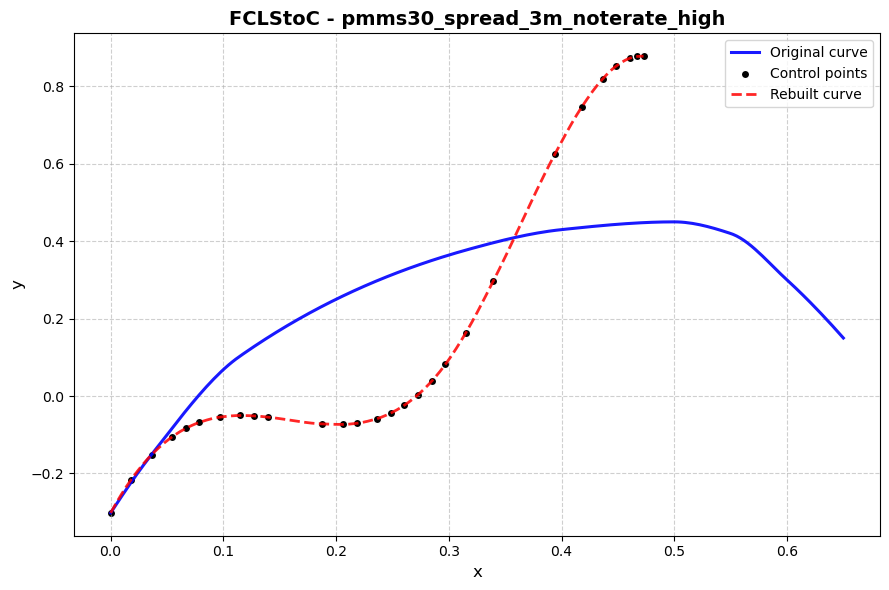

curve_x_pmms30_spread_3m_noterate_high	0,0.0023755139333,0.00475102786661,0.00712654179991,0.00950205573321,0.0118775696665,0.0142530835998,0.0166285975331,0.0190041114664,0.0213796253997,0.023755139333,0.0261306532663,0.0285061671996,0.0308816811329,0.0332571950662,0.0356327089995,0.0380082229328,0.0403837368661,0.0427592507995,0.0451347647328,0.0475102786661,0.0498857925994,0.0522613065327,0.054636820466,0.0570123343993,0.0593878483326,0.0617633622659,0.0641388761992,0.0665143901325,0.0688899040658,0.0712654179991,0.0736409319324,0.0760164458657,0.078391959799,0.0807674737323,0.0831429876656,0.0855185015989,0.0878940155322,0.0902695294655,0.0926450433988,0.0950205573321,0.0973960712654,0.0997715851987,0.102147099132,0.104522613065,0.106898126999,0.109273640932,0.111649154865,0.114024668799,0.116400182732,0.118775696665,0.121151210598,0.123526724532,0.125902238465,0.128277752398,0.130653266332,0.133028780265,0.135404294198,0.137779808132,0.140155322065,0.142530835998,0.144906349931,0.

In [ ]:
model = read_model_file(r"C:\Git\LMSimData_prod\data\JUMBO2\ModelFiles\1.8.0\jumbo_refinance_1.5.update_2025_11_30_17_12_13.138016.txt")

df_original = pd.DataFrame({
    "x": model["curve_x_pmms30_spread_3m_noterate_high"],
    "y": model["curve_y_pmms30_spread_3m_noterate_high"]
})

controls = extract_control_points(df_original["x"], df_original["y"], tolerance=0.001)
print("Control points:", controls) 

df_curve = rebuild_curve(
    controls=[(0.0, -0.301784198005997), (0.0181818181818182, -0.215928221172246), (0.0363636363636364, -0.151338770420314), (0.0545454545454545, -0.10526726783367), (0.0666666666666667, -0.0834833593287181), (0.0787878787878788, -0.0678936663664773), (0.096969696969697, -0.0543417953790502), (0.115151515151515, -0.0501459461685125), (0.127272727272727, -0.0511891808096299), (0.139393939393939, -0.0543546637097174), (0.187878787878788, -0.0719512087648579), (0.206060606060606, -0.073306799690958), (0.218181818181818, -0.0704160557661599), (0.236363636363636, -0.0583522494237994), (0.248484848484848, -0.0439702611010278), (0.260606060606061, -0.0235665864697573), (0.272727272727273, 0.00367316792675909), (0.284848484848485, 0.0385633955452657), (0.296969696969697, 0.0819184898425119), (0.315151515151515, 0.163735491842595), (0.339393939393939, 0.296810797784495), (0.393939393939394, 0.624174172511075), (0.418181818181818, 0.747936537048897), (0.436363636363636, 0.81900088742765), (0.448484848484848, 0.852539430221009), (0.460606060606061, 0.872844345524212), (0.466666666666667, 0.877454690673385), (0.472727272727273, 0.878061226317678)],
    x_original=model["curve_x_pmms30_spread_3m_noterate_high"],
    y_original=model["curve_y_pmms30_spread_3m_noterate_high"],
    method="pchip",
    title='FCLStoC - pmms30_spread_3m_noterate_high'
)


formatted_txt = format_curve_df(df_curve, "pmms30_spread_3m_noterate_high")
print(formatted_txt)


Control points: [(0.0, 0.0300868448961476), (13.9393939393939, -0.0549480977263803), (25.4545454545455, -0.0964068833119469), (38.1818181818182, -0.111146223956021), (60.0, -0.107063663476912)]


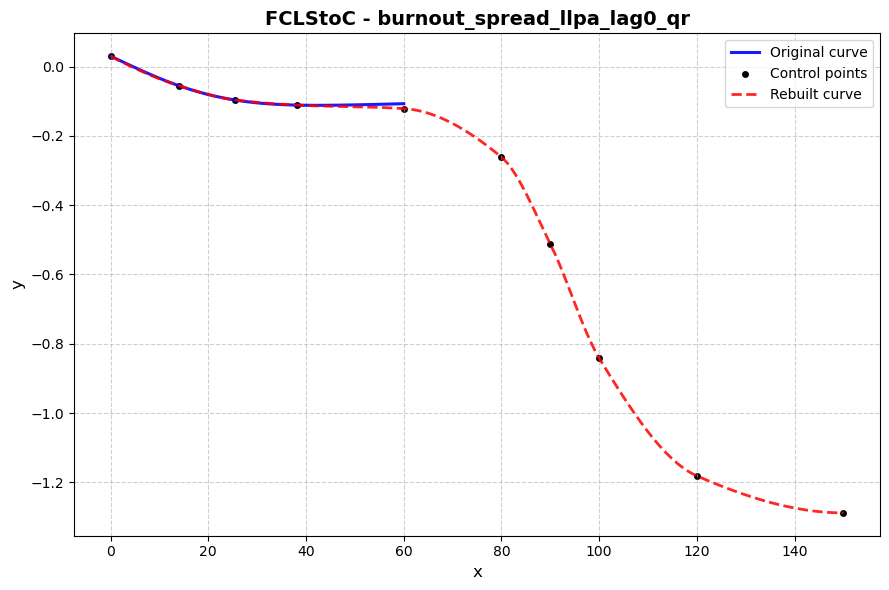

curve_x_burnout_spread_llpa_lag0_qr	0,0.753768844221,1.50753768844,2.26130653266,3.01507537688,3.76884422111,4.52261306533,5.27638190955,6.03015075377,6.78391959799,7.53768844221,8.29145728643,9.04522613065,9.79899497487,10.5527638191,11.3065326633,12.0603015075,12.8140703518,13.567839196,14.3216080402,15.0753768844,15.8291457286,16.5829145729,17.3366834171,18.0904522613,18.8442211055,19.5979899497,20.351758794,21.1055276382,21.8592964824,22.6130653266,23.3668341709,24.1206030151,24.8743718593,25.6281407035,26.3819095477,27.135678392,27.8894472362,28.6432160804,29.3969849246,30.1507537688,30.9045226131,31.6582914573,32.4120603015,33.1658291457,33.9195979899,34.6733668342,35.4271356784,36.1809045226,36.9346733668,37.6884422111,38.4422110553,39.1959798995,39.9497487437,40.7035175879,41.4572864322,42.2110552764,42.9648241206,43.7185929648,44.472361809,45.2261306533,45.9798994975,46.7336683417,47.4874371859,48.2412060302,48.9949748744,49.7487437186,50.5025125628,51.256281407,52.0100502513,

In [ ]:
model = read_model_file(r"C:\Git\LMSimData_prod\data\JUMBO2\ModelFiles\1.8.0\original\jumbo_refinance_1.5.update_2025_11_30_17_12_13.138016.txt")

df_original = pd.DataFrame({
    "x": model["curve_x_burnout_spread_llpa_lag0_qr"],
    "y": model["curve_y_burnout_spread_llpa_lag0_qr"]
})

controls = extract_control_points(df_original["x"], df_original["y"], tolerance=0.01)
print("Control points:", controls) 

df_curve = rebuild_curve(
    controls=[(0.0, 0.0300868448961476), (13.9393939393939, -0.0549480977263803), (25.4545454545455, -0.0964068833119469), (38.1818181818182, -0.111146223956021), (60.0, -0.121146223956021), 
              (80.0, -0.261146223956021), (90, -0.511146223956021), (100, -0.841146223956021), (120, -1.181146223956021), (150, -1.288)
              ],
    x_original=model["curve_x_burnout_spread_llpa_lag0_qr"],
    y_original=model["curve_y_burnout_spread_llpa_lag0_qr"],
    method="pchip",
    title='FCLStoC - burnout_spread_llpa_lag0_qr'
)


formatted_txt = format_curve_df(df_curve, "burnout_spread_llpa_lag0_qr")
print(formatted_txt)


Control points: [(0.7, -0.52), (0.728140703518, -0.438908072851), (0.756281407035, -0.364221831361), (0.784422110553, -0.295559253808), (0.81256281407, -0.232184154848), (0.830150753769, -0.195312884349), (0.847738693467, -0.163557949355), (0.872361809045, -0.126577510451), (0.889949748744, -0.105445560799), (0.911055276382, -0.0905300624606), (0.942713567839, -0.0755551898675), (1.00251256281, -0.0563321760513), (1.05175879397, -0.0444929322074), (1.08693467337, -0.0336035993319), (1.1256281407, -0.0183559265392), (1.16783919598, 0.00313913771665), (1.2135678392, 0.0320183186702), (1.26281407035, 0.0687026724208), (1.33316582915, 0.127233870862), (1.4, 0.185774737945)]


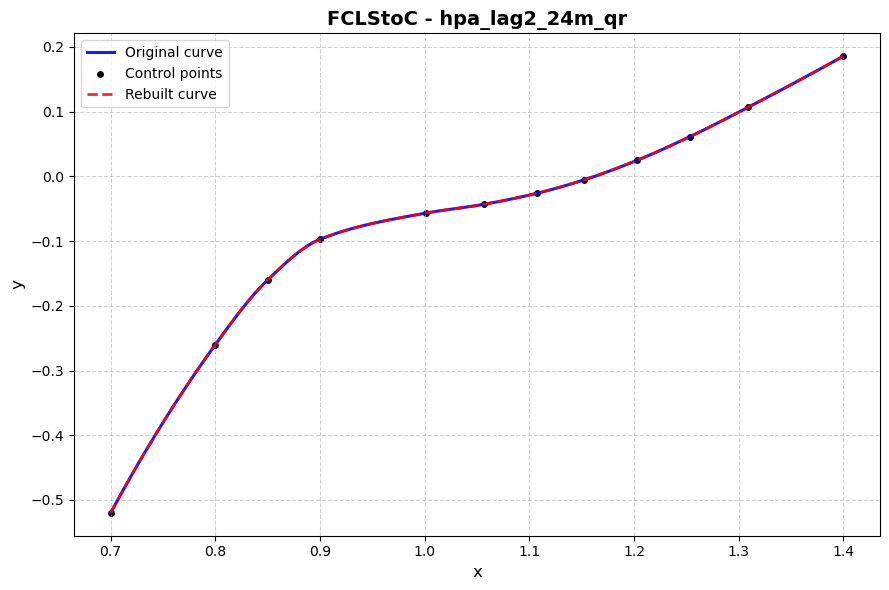

curve_x_hpa_lag2_24m_qr	0.7,0.70351758794,0.707035175879,0.710552763819,0.714070351759,0.717587939698,0.721105527638,0.724623115578,0.728140703518,0.731658291457,0.735175879397,0.738693467337,0.742211055276,0.745728643216,0.749246231156,0.752763819095,0.756281407035,0.759798994975,0.763316582915,0.766834170854,0.770351758794,0.773869346734,0.777386934673,0.780904522613,0.784422110553,0.787939698492,0.791457286432,0.794974874372,0.798492462312,0.802010050251,0.805527638191,0.809045226131,0.81256281407,0.81608040201,0.81959798995,0.823115577889,0.826633165829,0.830150753769,0.833668341709,0.837185929648,0.840703517588,0.844221105528,0.847738693467,0.851256281407,0.854773869347,0.858291457286,0.861809045226,0.865326633166,0.868844221106,0.872361809045,0.875879396985,0.879396984925,0.882914572864,0.886432160804,0.889949748744,0.893467336683,0.896984924623,0.900502512563,0.904020100503,0.907537688442,0.911055276382,0.914572864322,0.918090452261,0.921608040201,0.925125628141,0.92864321608,0.

In [ ]:
model = read_model_file(r"C:\Git\LMSimData\data\STACR\ModelFiles\crt_1_8_0\gam_begg_stacr_FCLStoC_2025_09_28.txt")

df_original = pd.DataFrame({
    "x": model["curve_x_hpa_lag2_24m_qr"],
    "y": model["curve_y_hpa_lag2_24m_qr"]
})

controls = extract_control_points(df_original["x"], df_original["y"], tolerance=0.001)
print("Control points:", controls) 

df_curve = rebuild_curve(
    controls=[(0.7, -0.52), (0.8, -0.26), (0.85, -0.16), (0.9, -0.0972091246751953), (1.0010101010101, -0.0567723686113737), (1.05656565656566, -0.0431787148781902), (1.10707070707071, -0.0261857935453907), (1.15252525252525, -0.0052408274479822), (1.2030303030303, 0.0249240694444497), (1.25353535353535, 0.0614756957740388), (1.30909090909091, 0.106853885286882), (1.4, 0.185774737944601)],
    x_original=model["curve_x_hpa_lag2_24m_qr"],
    y_original=model["curve_y_hpa_lag2_24m_qr"],
    method="pchip",
    title='FCLStoC - hpa_lag2_24m_qr'
)


formatted_txt = format_curve_df(df_curve, "hpa_lag2_24m_qr")
print(formatted_txt)


Control points: [(20.0, 0.508110019172), (33.2663316583, 0.404953189174), (47.6381909548, 0.252159688681), (54.2713567839, 0.151864612541), (68.6432160804, -0.118312820153), (78.040201005, -0.319922363651), (86.8844221106, -0.553172796197), (95.175879397, -0.819184091631), (102.914572864, -1.11981413657), (107.336683417, -1.3356534236), (110.653266332, -1.54663326625), (113.417085427, -1.78818572955), (116.180904523, -2.08809210239), (120.050251256, -2.57320993561), (122.814070352, -2.9791711771), (126.130653266, -3.54593923049), (127.788944724, -3.85798356953), (130.0, -4.3)]


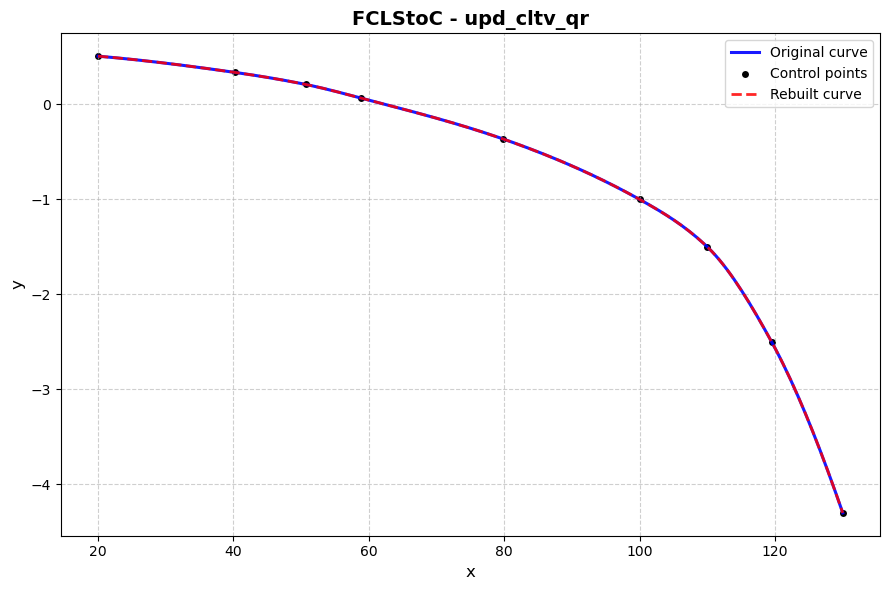

curve_x_upd_cltv_qr	20,20.5527638191,21.1055276382,21.6582914573,22.2110552764,22.7638190955,23.3165829146,23.8693467337,24.4221105528,24.9748743719,25.527638191,26.0804020101,26.6331658291,27.1859296482,27.7386934673,28.2914572864,28.8442211055,29.3969849246,29.9497487437,30.5025125628,31.0552763819,31.608040201,32.1608040201,32.7135678392,33.2663316583,33.8190954774,34.3718592965,34.9246231156,35.4773869347,36.0301507538,36.5829145729,37.135678392,37.6884422111,38.2412060302,38.7939698492,39.3467336683,39.8994974874,40.4522613065,41.0050251256,41.5577889447,42.1105527638,42.6633165829,43.216080402,43.7688442211,44.3216080402,44.8743718593,45.4271356784,45.9798994975,46.5326633166,47.0854271357,47.6381909548,48.1909547739,48.743718593,49.2964824121,49.8492462312,50.4020100503,50.9547738693,51.5075376884,52.0603015075,52.6130653266,53.1658291457,53.7185929648,54.2713567839,54.824120603,55.3768844221,55.9296482412,56.4824120603,57.0351758794,57.5879396985,58.1407035176,58.6934673367,59.

In [ ]:
model = read_model_file(r"C:\Git\LMSimData\data\STACR\ModelFiles\crt_1_8_0\gam_begg_stacr_FCLStoC_2025_09_28.txt")

df_original = pd.DataFrame({
    "x": model["curve_x_upd_cltv_qr"],
    "y": model["curve_y_upd_cltv_qr"]
})


controls = extract_control_points(df_original["x"], df_original["y"], tolerance=0.01)

print("Control points:", controls) 

df_curve = rebuild_curve(
    controls=[(20.0, 0.508110019172005), (40.2020202020202, 0.337494331439579), (50.7070707070707, 0.210078569369278), (58.7878787878788, 0.0679829626173334), (79.7979797979798, -0.362666473753446), (100.0, -1), (110.0, -1.5), (119.497487437, -2.5), (130.0, -4.3)],
    x_original=model["curve_x_upd_cltv_qr"],
    y_original=model["curve_y_upd_cltv_qr"],
    method="pchip",
    title='FCLStoC - upd_cltv_qr'
)


formatted_txt = format_curve_df(df_curve, "upd_cltv_qr")
print(formatted_txt)


Control points: [(40.0, 0.175118615884), (49.2462311558, 0.101001518001), (59.6984924623, 0.0168914063385), (66.9346733668, -0.041652318887), (74.9748743719, -0.10703521172), (75.7788944724, -0.113303571009), (78.1909547739, -0.131692631854), (79.3969849246, -0.141451896127), (80.2010050251, -0.148463063893), (81.0050251256, -0.156028829745), (82.2110552764, -0.168319028922), (83.4170854271, -0.181240757297), (84.2211055276, -0.1901926823), (85.4271356784, -0.20411841922), (86.6331658291, -0.218631603782), (87.8391959799, -0.233721017872), (89.0452261307, -0.249375443377), (90.2512562814, -0.265583662183), (91.4572864322, -0.282334456177), (92.6633165829, -0.299616607245), (93.8693467337, -0.317418897274), (95.0753768844, -0.335730108151), (96.2814070352, -0.354539021761), (97.4874371859, -0.373834419992), (98.6934673367, -0.393605084729), (99.8994974874, -0.41383979786), (101.105527638, -0.43452734127), (102.311557789, -0.455656496847), (103.51758794, -0.477216046477), (104.72361809, 

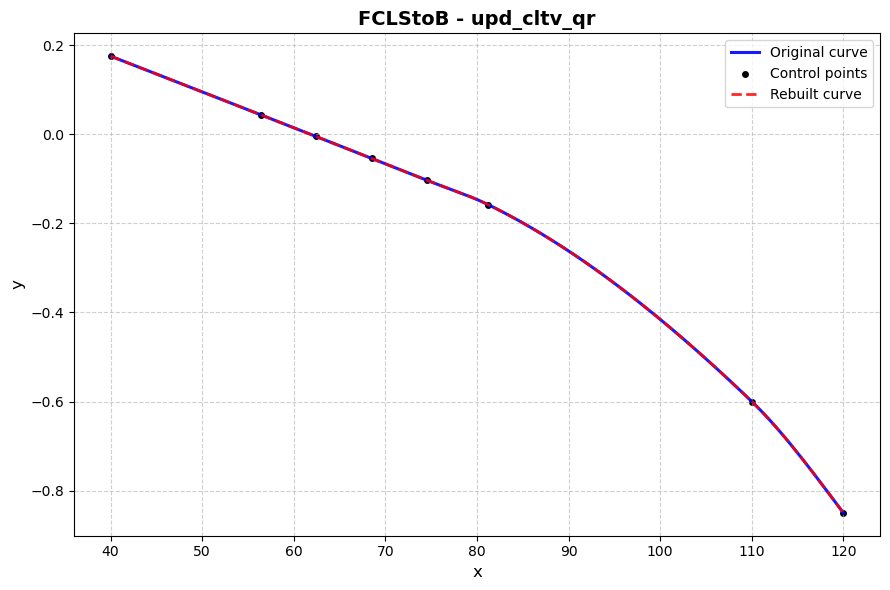

curve_x_upd_cltv_qr	40,40.4020100503,40.8040201005,41.2060301508,41.608040201,42.0100502513,42.4120603015,42.8140703518,43.216080402,43.6180904523,44.0201005025,44.4221105528,44.824120603,45.2261306533,45.6281407035,46.0301507538,46.432160804,46.8341708543,47.2361809045,47.6381909548,48.040201005,48.4422110553,48.8442211055,49.2462311558,49.648241206,50.0502512563,50.4522613065,50.8542713568,51.256281407,51.6582914573,52.0603015075,52.4623115578,52.864321608,53.2663316583,53.6683417085,54.0703517588,54.472361809,54.8743718593,55.2763819095,55.6783919598,56.0804020101,56.4824120603,56.8844221106,57.2864321608,57.6884422111,58.0904522613,58.4924623116,58.8944723618,59.2964824121,59.6984924623,60.1005025126,60.5025125628,60.9045226131,61.3065326633,61.7085427136,62.1105527638,62.5125628141,62.9145728643,63.3165829146,63.7185929648,64.1206030151,64.5226130653,64.9246231156,65.3266331658,65.7286432161,66.1306532663,66.5326633166,66.9346733668,67.3366834171,67.7386934673,68.1407035176,68.542

In [ ]:
model = read_model_file(r"C:\Git\LMSimData\data\STACR\ModelFiles\crt_1_8_0\gam_begg_stacr_FCLStoB_2025_09_28.txt")

df_original = pd.DataFrame({
    "x": model["curve_x_upd_cltv_qr"],
    "y": model["curve_y_upd_cltv_qr"]
})


controls = extract_control_points(df_original["x"], df_original["y"], tolerance=0.0001)

print("Control points:", controls) 

df_curve = rebuild_curve(
    controls=[(40.0, 0.17511861588373), (56.3636363636364, 0.0437667925135439), (62.4242424242424, -0.00512341846004145), (68.4848484848485, -0.0542359883868935), (74.5454545454545, -0.103579005217279), (81.2121212121212, -0.158083143997292), (110, -0.6), (120, -0.85)],
    x_original=model["curve_x_upd_cltv_qr"],
    y_original=model["curve_y_upd_cltv_qr"],
    method="pchip",
    title='FCLStoB - upd_cltv_qr'
)


formatted_txt = format_curve_df(df_curve, "upd_cltv_qr")
print(formatted_txt)


Control points: [(0.6, 0.5), (0.612060301508, 0.470363318829), (0.624120603015, 0.441871728279), (0.636180904523, 0.414700646486), (0.644221105528, 0.397406834176), (0.656281407035, 0.372826418398), (0.66432160804, 0.357422140965), (0.672361809045, 0.342864635036), (0.68040201005, 0.329205876355), (0.688442211055, 0.316497840668), (0.69648241206, 0.304792503717), (0.708542713568, 0.288846062892), (0.720603015075, 0.273909356926), (0.732663316583, 0.259930817739), (0.74472361809, 0.246921345471), (0.756783919598, 0.234891840265), (0.768844221106, 0.223853202261), (0.776884422111, 0.217049974824), (0.784924623116, 0.210695206991), (0.792964824121, 0.204792128431), (0.805025125628, 0.19675257863), (0.817085427136, 0.18935311503), (0.829145728643, 0.182465305519), (0.841206030151, 0.176033198574), (0.857286432161, 0.168069220304), (0.869346733668, 0.162482830092), (0.881407035176, 0.15716563737), (0.897487437186, 0.15039809239), (0.913567839196, 0.143877025521), (0.957788944724, 0.12625026

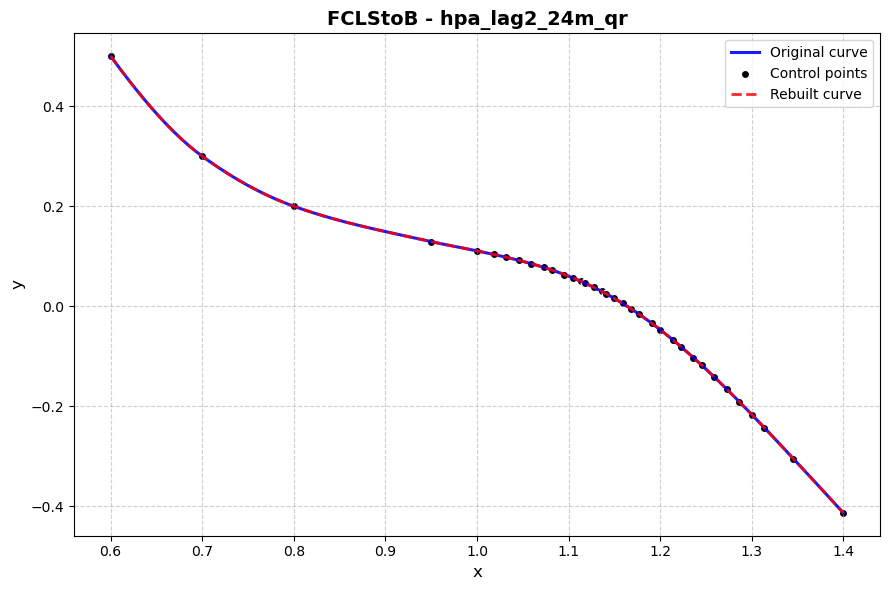

curve_x_hpa_lag2_24m_qr	0.6,0.604020100503,0.608040201005,0.612060301508,0.61608040201,0.620100502513,0.624120603015,0.628140703518,0.63216080402,0.636180904523,0.640201005025,0.644221105528,0.64824120603,0.652261306533,0.656281407035,0.660301507538,0.66432160804,0.668341708543,0.672361809045,0.676381909548,0.68040201005,0.684422110553,0.688442211055,0.692462311558,0.69648241206,0.700502512563,0.704522613065,0.708542713568,0.71256281407,0.716582914573,0.720603015075,0.724623115578,0.72864321608,0.732663316583,0.736683417085,0.740703517588,0.74472361809,0.748743718593,0.752763819095,0.756783919598,0.760804020101,0.764824120603,0.768844221106,0.772864321608,0.776884422111,0.780904522613,0.784924623116,0.788944723618,0.792964824121,0.796984924623,0.801005025126,0.805025125628,0.809045226131,0.813065326633,0.817085427136,0.821105527638,0.825125628141,0.829145728643,0.833165829146,0.837185929648,0.841206030151,0.845226130653,0.849246231156,0.853266331658,0.857286432161,0.861306532663,0.8653

In [ ]:
model = read_model_file(r"C:\Git\LMSimData\data\STACR\ModelFiles\crt_1_8_0\gam_begg_stacr_FCLStoB_2025_09_28.txt")

df_original = pd.DataFrame({
    "x": model["curve_x_hpa_lag2_24m_qr"],
    "y": model["curve_y_hpa_lag2_24m_qr"]
})


controls = extract_control_points(df_original["x"], df_original["y"], tolerance=0.0001)

print("Control points:", controls) 

df_curve = rebuild_curve(
    controls=[(0.6, 0.5), (0.7, 0.3), (0.8, 0.2), (0.95, 0.129316928028453), (1.0, 0.110861661061746), (1.01818181818182, 0.103784598394112), (1.03181818181818, 0.0981390590816414), (1.04545454545455, 0.0920544412681522), (1.05909090909091, 0.0853825069076791), (1.07272727272727, 0.0779713541013814), (1.08181818181818, 0.0725466148646211), (1.09545454545455, 0.0635813695331789), (1.10454545454545, 0.0569986129614451), (1.11363636363636, 0.0498926278963181), (1.11818181818182, 0.0461346253656314), (1.12727272727273, 0.0381941033232436), (1.13636363636364, 0.0296725599292687), (1.14090909090909, 0.0251895919826089), (1.15, 0.0157736972244045), (1.15909090909091, 0.00575428602266785), (1.16818181818182, -0.00486845954485886), (1.17727272727273, -0.0160892752769899), (1.19090909090909, -0.0340198010753999), (1.2, -0.0466844521162581), (1.21363636363636, -0.0667001922426747), (1.22272727272727, -0.0806906179971356), (1.23636363636364, -0.10258272012828), (1.24545454545455, -0.117740090751527), (1.25909090909091, -0.141242602097051), (1.27272727272727, -0.165566776162098), (1.28636363636364, -0.190599166314545), (1.3, -0.216225029298753), (1.31363636363636, -0.242331379689798), (1.34545454545455, -0.304526152543735), (1.4, -0.412823713693769)],
    x_original=model["curve_x_hpa_lag2_24m_qr"],
    y_original=model["curve_y_hpa_lag2_24m_qr"],
    method="pchip",
    title='FCLStoB - hpa_lag2_24m_qr'
)


formatted_txt = format_curve_df(df_curve, "hpa_lag2_24m_qr")
print(formatted_txt)


Control points: [(20.0, -1.79038193107), (31.0552763819, -1.32532031228), (42.1105527638, -0.838421009101), (61.2060301508, 0.063734710864), (69.2462311558, 0.424268321003), (75.7788944724, 0.684193057178), (82.8140703518, 0.922416381512), (88.8442211055, 1.16808052646), (93.3668341709, 1.38479592138), (97.3869346734, 1.61928802026), (100.40201005, 1.83044938842), (102.914572864, 2.05037028258), (105.427135678, 2.31827886173), (107.939698492, 2.62991420825), (110.452261307, 2.98101540449), (113.467336683, 3.44843238959), (116.48241206, 3.95918161124), (120.0, 4.6)]


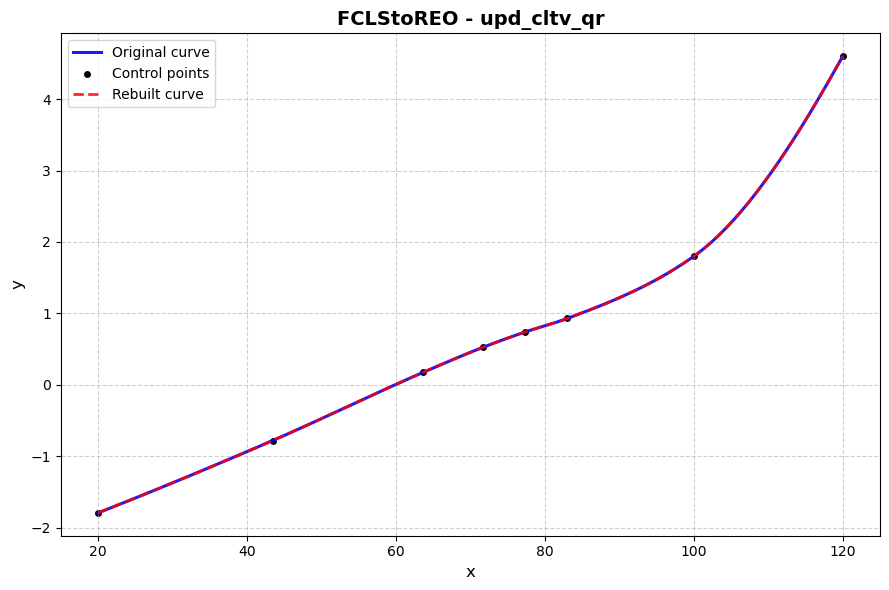

curve_x_upd_cltv_qr	20,20.5025125628,21.0050251256,21.5075376884,22.0100502513,22.5125628141,23.0150753769,23.5175879397,24.0201005025,24.5226130653,25.0251256281,25.527638191,26.0301507538,26.5326633166,27.0351758794,27.5376884422,28.040201005,28.5427135678,29.0452261307,29.5477386935,30.0502512563,30.5527638191,31.0552763819,31.5577889447,32.0603015075,32.5628140704,33.0653266332,33.567839196,34.0703517588,34.5728643216,35.0753768844,35.5778894472,36.0804020101,36.5829145729,37.0854271357,37.5879396985,38.0904522613,38.5929648241,39.0954773869,39.5979899497,40.1005025126,40.6030150754,41.1055276382,41.608040201,42.1105527638,42.6130653266,43.1155778894,43.6180904523,44.1206030151,44.6231155779,45.1256281407,45.6281407035,46.1306532663,46.6331658291,47.135678392,47.6381909548,48.1407035176,48.6432160804,49.1457286432,49.648241206,50.1507537688,50.6532663317,51.1557788945,51.6582914573,52.1608040201,52.6633165829,53.1658291457,53.6683417085,54.1708542714,54.6733668342,55.175879397,55.6

In [ ]:
model = read_model_file(r"C:\Git\LMSimData\data\STACR\ModelFiles\crt_1_8_0\gam_begg_stacr_FCLStoREO_2025_09_28.txt")

df_original = pd.DataFrame({
    "x": model["curve_x_upd_cltv_qr"],
    "y": model["curve_y_upd_cltv_qr"]
})


controls = extract_control_points(df_original["x"], df_original["y"], tolerance=0.01)

print("Control points:", controls) 
df_curve = rebuild_curve(
    controls=[(20.0, -1.79038193106611), (43.4343434343434, -0.778787475727536), (63.6363636363636, 0.175007839556413), (71.7171717171717, 0.527428605936127), (77.3737373737374, 0.741876861414589), (83.030303030303, 0.930752856955344), (100.0, 1.8), (120, 4.6)],
    x_original=model["curve_x_upd_cltv_qr"],
    y_original=model["curve_y_upd_cltv_qr"],
    method="pchip",
    title='FCLStoREO - upd_cltv_qr'
)


formatted_txt = format_curve_df(df_curve, "upd_cltv_qr")
print(formatted_txt)

Control points: [(0.7, 0.816887443975), (0.742713567839, 0.622198666259), (0.78040201005, 0.471283907678), (0.850753768844, 0.225257229143), (0.868341708543, 0.174024485333), (0.883417085427, 0.140580758592), (0.895979899497, 0.122531141532), (0.91608040201, 0.108699496063), (0.936180904523, 0.0994980624302), (0.993969849246, 0.0784611801459), (1.05427135678, 0.0482450547673), (1.09949748744, 0.0215955959594), (1.11959798995, 0.00665134009178), (1.14472361809, -0.0157737853072), (1.2, -0.0729235977829)]


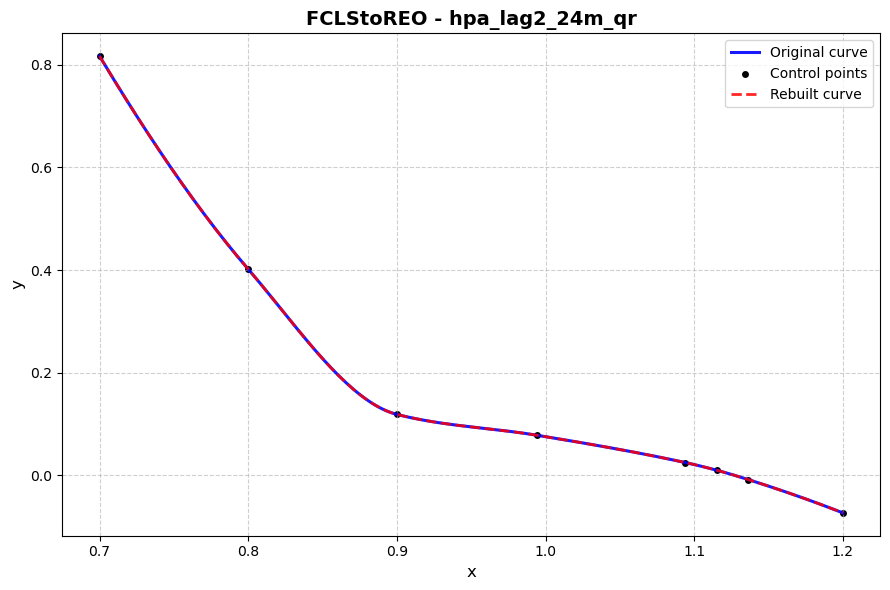

curve_x_hpa_lag2_24m_qr	0.7,0.702512562814,0.705025125628,0.707537688442,0.710050251256,0.71256281407,0.715075376884,0.717587939698,0.720100502513,0.722613065327,0.725125628141,0.727638190955,0.730150753769,0.732663316583,0.735175879397,0.737688442211,0.740201005025,0.742713567839,0.745226130653,0.747738693467,0.750251256281,0.752763819095,0.75527638191,0.757788944724,0.760301507538,0.762814070352,0.765326633166,0.76783919598,0.770351758794,0.772864321608,0.775376884422,0.777889447236,0.78040201005,0.782914572864,0.785427135678,0.787939698492,0.790452261307,0.792964824121,0.795477386935,0.797989949749,0.800502512563,0.803015075377,0.805527638191,0.808040201005,0.810552763819,0.813065326633,0.815577889447,0.818090452261,0.820603015075,0.823115577889,0.825628140704,0.828140703518,0.830653266332,0.833165829146,0.83567839196,0.838190954774,0.840703517588,0.843216080402,0.845728643216,0.84824120603,0.850753768844,0.853266331658,0.855778894472,0.858291457286,0.860804020101,0.863316582915,0.8

In [ ]:
model = read_model_file(r"C:\Git\LMSimData\data\STACR\ModelFiles\crt_1_8_0\gam_begg_stacr_FCLStoREO_2025_09_28.txt")

df_original = pd.DataFrame({
    "x": model["curve_x_hpa_lag2_24m_qr"],
    "y": model["curve_y_hpa_lag2_24m_qr"]
})


controls = extract_control_points(df_original["x"], df_original["y"], tolerance=0.001)

print("Control points:", controls) 
df_curve = rebuild_curve(
    controls=[(0.7, 0.816887443974625), (0.8, 0.40194124475726), (0.9, 0.11896832380488), (0.993939393939394, 0.0784756758263596), (1.09393939393939, 0.0252137429792419), (1.11515151515152, 0.0101926754072574), (1.13636363636364, -0.00800148509041706), (1.2, -0.0729235977828776)],
    x_original=model["curve_x_hpa_lag2_24m_qr"],
    y_original=model["curve_y_hpa_lag2_24m_qr"],
    method="pchip",
    title='FCLStoREO - hpa_lag2_24m_qr'
)


formatted_txt = format_curve_df(df_curve, "hpa_lag2_24m_qr")
print(formatted_txt)

Control points: [(20.0, 0.697646209688), (26.5326633166, 0.606324498127), (34.0703517588, 0.498366234019), (40.1005025126, 0.410361352546), (44.6231155779, 0.341498194719), (48.6432160804, 0.276571693274), (52.1608040201, 0.215949896828), (55.175879397, 0.160619622502), (58.6934673367, 0.0917425871256), (62.7135678392, 0.00680427187346), (66.2311557789, -0.0730267137647), (70.2512562814, -0.170156908067), (74.2713567839, -0.273090494331), (77.2864321608, -0.353515943025), (81.3065326633, -0.46372424885), (83.3165829146, -0.516840401433), (84.3216080402, -0.545353451405), (85.3266331658, -0.577150450734), (86.3316582915, -0.612447242703), (87.3366834171, -0.649830094724), (88.3417085427, -0.689286817874), (89.8492462312, -0.752384105224), (90.8542713568, -0.797072894718), (91.8592964824, -0.843873466159), (92.864321608, -0.892796651211), (93.8693467337, -0.943853281536), (94.8743718593, -0.997054188797), (95.8793969849, -1.05241020466), (96.8844221106, -1.10993216078), (97.8894472362, -

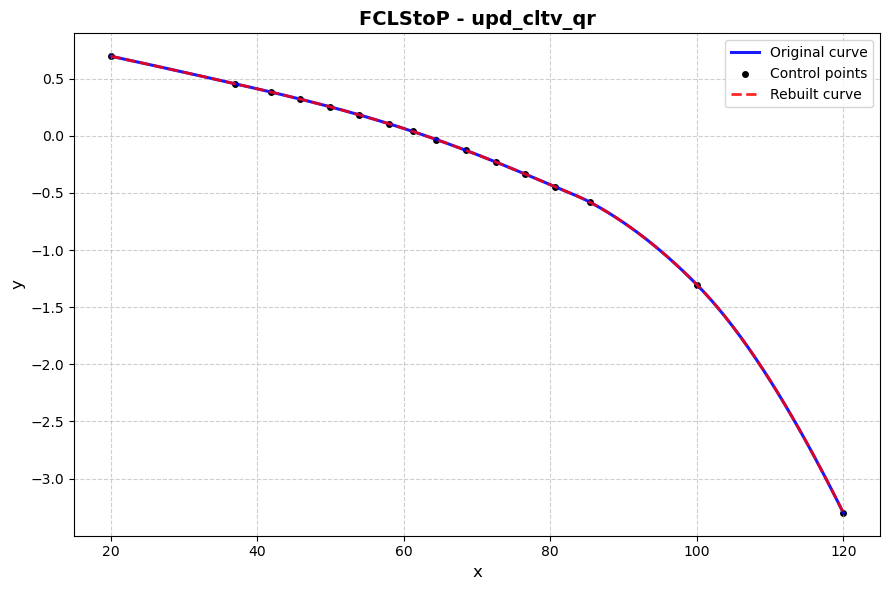

curve_x_upd_cltv_qr	20,20.5025125628,21.0050251256,21.5075376884,22.0100502513,22.5125628141,23.0150753769,23.5175879397,24.0201005025,24.5226130653,25.0251256281,25.527638191,26.0301507538,26.5326633166,27.0351758794,27.5376884422,28.040201005,28.5427135678,29.0452261307,29.5477386935,30.0502512563,30.5527638191,31.0552763819,31.5577889447,32.0603015075,32.5628140704,33.0653266332,33.567839196,34.0703517588,34.5728643216,35.0753768844,35.5778894472,36.0804020101,36.5829145729,37.0854271357,37.5879396985,38.0904522613,38.5929648241,39.0954773869,39.5979899497,40.1005025126,40.6030150754,41.1055276382,41.608040201,42.1105527638,42.6130653266,43.1155778894,43.6180904523,44.1206030151,44.6231155779,45.1256281407,45.6281407035,46.1306532663,46.6331658291,47.135678392,47.6381909548,48.1407035176,48.6432160804,49.1457286432,49.648241206,50.1507537688,50.6532663317,51.1557788945,51.6582914573,52.1608040201,52.6633165829,53.1658291457,53.6683417085,54.1708542714,54.6733668342,55.175879397,55.6

In [ ]:
model = read_model_file(r"C:\Git\LMSimData\data\STACR\ModelFiles\crt_1_8_0\gam_begg_stacr_FCLStoP_2025_09_28.txt")

df_original = pd.DataFrame({
    "x": model["curve_x_upd_cltv_qr"],
    "y": model["curve_y_upd_cltv_qr"]
})


controls = extract_control_points(df_original["x"], df_original["y"], tolerance=0.001)

print("Control points:", controls) 

df_curve = rebuild_curve(
    controls=[(20.0, 0.697646209688023), (36.969696969697, 0.456297441883985), (41.8181818181818, 0.384614208652107), (45.8585858585859, 0.321966704250674), (49.8989898989899, 0.255381142899625), (53.9393939393939, 0.183727166037904), (57.979797979798, 0.106098604825896), (61.2121212121212, 0.0392903026471257), (64.4444444444444, -0.031836604333372), (68.4848484848485, -0.126709365950578), (72.5252525252525, -0.227732791562708), (76.5656565656566, -0.334084567923261), (80.6060606060606, -0.444718518335304), (85.4545454545455, -0.581508479120914), (100.0, -1.30213179499505), (120, -3.3)],
    x_original=model["curve_x_upd_cltv_qr"],
    y_original=model["curve_y_upd_cltv_qr"],
    method="pchip",
    title='FCLStoP - upd_cltv_qr'
)


formatted_txt = format_curve_df(df_curve, "upd_cltv_qr")
print(formatted_txt)


Control points: [(0.6, -0.5), (0.63216080402, -0.426249667062), (0.660301507538, -0.368377924064), (0.684422110553, -0.324785055045), (0.71256281407, -0.281755253237), (0.74472361809, -0.239924708325), (0.784924623116, -0.195242392555), (0.837185929648, -0.144151159099), (0.877386934673, -0.11049525618), (0.909547738693, -0.0901768928689), (0.949748743719, -0.070584595378), (1.13065326633, 0.000727821705866), (1.25125628141, 0.0432423565828), (1.4, 0.0899219140901)]


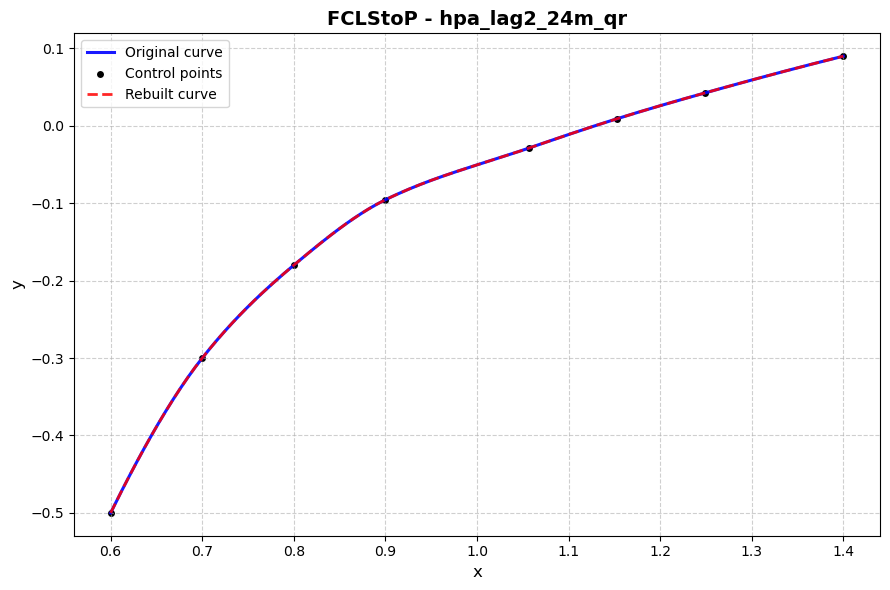

curve_x_hpa_lag2_24m_qr	0.6,0.604020100503,0.608040201005,0.612060301508,0.61608040201,0.620100502513,0.624120603015,0.628140703518,0.63216080402,0.636180904523,0.640201005025,0.644221105528,0.64824120603,0.652261306533,0.656281407035,0.660301507538,0.66432160804,0.668341708543,0.672361809045,0.676381909548,0.68040201005,0.684422110553,0.688442211055,0.692462311558,0.69648241206,0.700502512563,0.704522613065,0.708542713568,0.71256281407,0.716582914573,0.720603015075,0.724623115578,0.72864321608,0.732663316583,0.736683417085,0.740703517588,0.74472361809,0.748743718593,0.752763819095,0.756783919598,0.760804020101,0.764824120603,0.768844221106,0.772864321608,0.776884422111,0.780904522613,0.784924623116,0.788944723618,0.792964824121,0.796984924623,0.801005025126,0.805025125628,0.809045226131,0.813065326633,0.817085427136,0.821105527638,0.825125628141,0.829145728643,0.833165829146,0.837185929648,0.841206030151,0.845226130653,0.849246231156,0.853266331658,0.857286432161,0.861306532663,0.8653

In [ ]:
model = read_model_file(r"C:\Git\LMSimData\data\STACR\ModelFiles\crt_1_8_0\gam_begg_stacr_FCLStoP_2025_09_28.txt")

df_original = pd.DataFrame({
    "x": model["curve_x_hpa_lag2_24m_qr"],
    "y": model["curve_y_hpa_lag2_24m_qr"]
})


controls = extract_control_points(df_original["x"], df_original["y"], tolerance=0.001)

print("Control points:", controls) 

df_curve = rebuild_curve(
    controls=[(0.6, -0.5), (0.7, -0.3), (0.8, -0.18), (0.9, -0.0955551268648575), (1.05656565656566, -0.0288300574979814), (1.15252525252525, 0.00896781280419911), (1.24848484848485, 0.0423249234795435), (1.4, 0.089921914090117)],
    x_original=model["curve_x_hpa_lag2_24m_qr"],
    y_original=model["curve_y_hpa_lag2_24m_qr"],
    method="pchip",
    title='FCLStoP - hpa_lag2_24m_qr'
)


formatted_txt = format_curve_df(df_curve, "hpa_lag2_24m_qr")
print(formatted_txt)


Control points: [(55.0, -0.0910385563863), (68.6683417085, 0.000233035975002), (81.0552763819, 0.125070400384), (89.5979899497, 0.266428506974), (98.9949748744, 0.488099434611), (110.527638191, 0.837032556282), (122.487437186, 1.26957482423), (126.331658291, 1.44297553763), (130.175879397, 1.6380776251), (140.0, 2.2)]


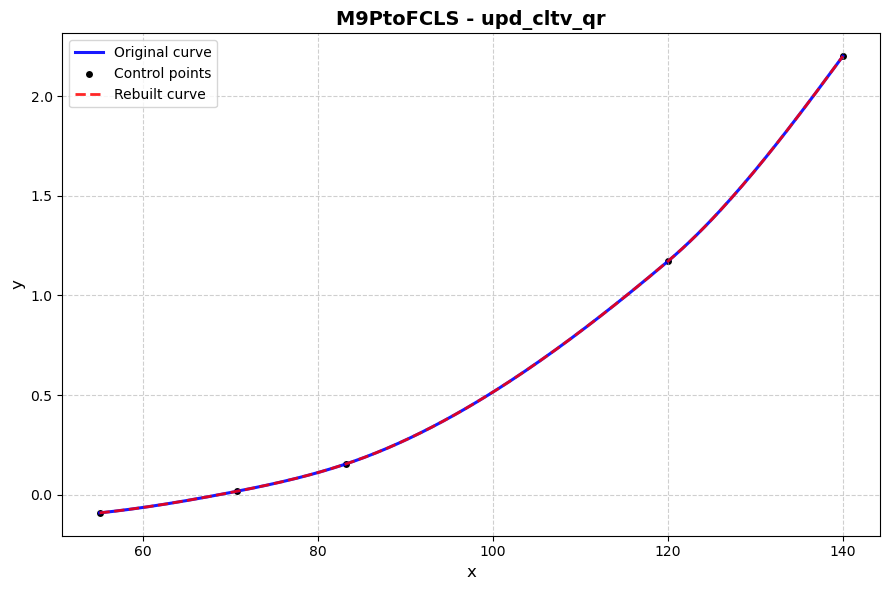

curve_x_upd_cltv_qr	55,55.4271356784,55.8542713568,56.2814070352,56.7085427136,57.135678392,57.5628140704,57.9899497487,58.4170854271,58.8442211055,59.2713567839,59.6984924623,60.1256281407,60.5527638191,60.9798994975,61.4070351759,61.8341708543,62.2613065327,62.6884422111,63.1155778894,63.5427135678,63.9698492462,64.3969849246,64.824120603,65.2512562814,65.6783919598,66.1055276382,66.5326633166,66.959798995,67.3869346734,67.8140703518,68.2412060302,68.6683417085,69.0954773869,69.5226130653,69.9497487437,70.3768844221,70.8040201005,71.2311557789,71.6582914573,72.0854271357,72.5125628141,72.9396984925,73.3668341709,73.7939698492,74.2211055276,74.648241206,75.0753768844,75.5025125628,75.9296482412,76.3567839196,76.783919598,77.2110552764,77.6381909548,78.0653266332,78.4924623116,78.9195979899,79.3467336683,79.7738693467,80.2010050251,80.6281407035,81.0552763819,81.4824120603,81.9095477387,82.3366834171,82.7638190955,83.1909547739,83.6180904523,84.0452261307,84.472361809,84.8994974874,85.

In [ ]:
model = read_model_file(r"C:\Git\LMSimData\data\STACR\ModelFiles\crt_1_8_0\gam_begg_stacr_M9PtoFCLS_2025_10_02.txt")

df_original = pd.DataFrame({
    "x": model["curve_x_upd_cltv_qr"],
    "y": model["curve_y_upd_cltv_qr"]
})


controls = extract_control_points(df_original["x"], df_original["y"], tolerance=0.01)

print("Control points:", controls) 

df_curve = rebuild_curve(
    controls=[(55.0, -0.0910385563863064), (70.7575757575758, 0.0178295314405846), (83.2323232323232, 0.155316551789886), (120.0, 1.171341868307142), (140, 2.2)],
    x_original=model["curve_x_upd_cltv_qr"],
    y_original=model["curve_y_upd_cltv_qr"],
    method="pchip",
    title='M9PtoFCLS - upd_cltv_qr'
)


formatted_txt = format_curve_df(df_curve, "upd_cltv_qr")
print(formatted_txt)


Control points: [(0.6, 1.0), (0.64824120603, 0.760587932615), (0.66432160804, 0.692359394893), (0.676381909548, 0.649197982708), (0.692462311558, 0.604834174738), (0.724623115578, 0.530641876455), (0.752763819095, 0.472945273701), (0.784924623116, 0.414241063477), (0.813065326633, 0.368352808447), (0.841206030151, 0.326781629838), (0.873366834171, 0.283583653289), (0.905527638191, 0.243898618083), (1.00201005025, 0.134734004409), (1.05829145729, 0.0816846359425), (1.10653266332, 0.0315705295977), (1.14271356784, -0.00941871435823), (1.18291457286, -0.0583656599361), (1.26733668342, -0.172145261144), (1.4, -0.365623469425)]


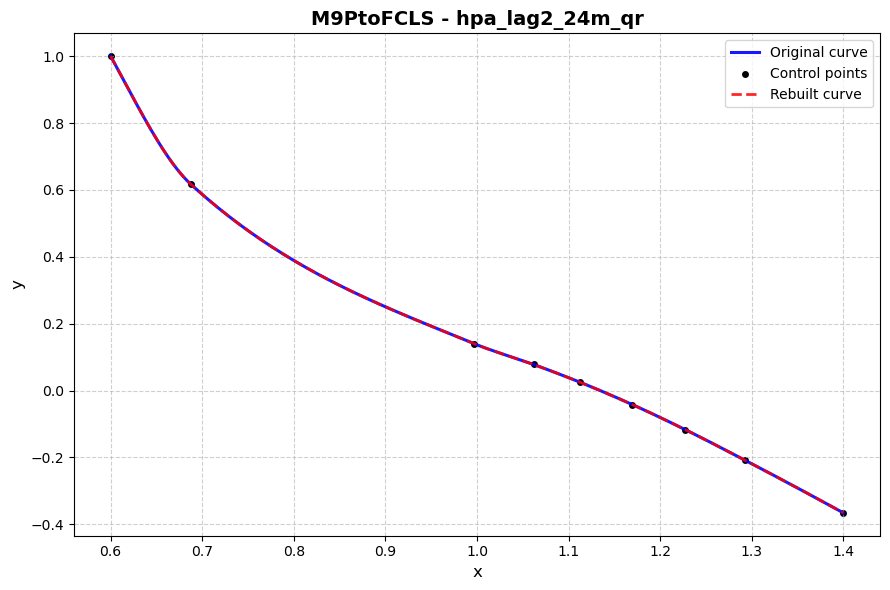

curve_x_hpa_lag2_24m_qr	0.6,0.604020100503,0.608040201005,0.612060301508,0.61608040201,0.620100502513,0.624120603015,0.628140703518,0.63216080402,0.636180904523,0.640201005025,0.644221105528,0.64824120603,0.652261306533,0.656281407035,0.660301507538,0.66432160804,0.668341708543,0.672361809045,0.676381909548,0.68040201005,0.684422110553,0.688442211055,0.692462311558,0.69648241206,0.700502512563,0.704522613065,0.708542713568,0.71256281407,0.716582914573,0.720603015075,0.724623115578,0.72864321608,0.732663316583,0.736683417085,0.740703517588,0.74472361809,0.748743718593,0.752763819095,0.756783919598,0.760804020101,0.764824120603,0.768844221106,0.772864321608,0.776884422111,0.780904522613,0.784924623116,0.788944723618,0.792964824121,0.796984924623,0.801005025126,0.805025125628,0.809045226131,0.813065326633,0.817085427136,0.821105527638,0.825125628141,0.829145728643,0.833165829146,0.837185929648,0.841206030151,0.845226130653,0.849246231156,0.853266331658,0.857286432161,0.861306532663,0.8653

In [ ]:
model = read_model_file(r"C:\Git\LMSimData\data\STACR\ModelFiles\crt_1_8_0\gam_begg_stacr_M9PtoFCLS_2025_10_02.txt")

df_original = pd.DataFrame({
    "x": model["curve_x_hpa_lag2_24m_qr"],
    "y": model["curve_y_hpa_lag2_24m_qr"]
})


controls = extract_control_points(df_original["x"], df_original["y"], tolerance=0.001)

print("Control points:", controls) 

df_curve = rebuild_curve(
    controls=[(0.6, 1),(0.687598568574545, 0.616887443974625), (0.997025452931056, 0.140194124475726), (1.06178921942428, 0.0782242481298417), (1.1121610378079, 0.0253953841460876), (1.16972883024632, -0.0418978736789407), (1.22729662268474, -0.116612860645531), (1.29206038917796, -0.207392570973929), (1.4, -0.365623469424831)],
    x_original=model["curve_x_hpa_lag2_24m_qr"],
    y_original=model["curve_y_hpa_lag2_24m_qr"],
    method="pchip",
    title='M9PtoFCLS - hpa_lag2_24m_qr'
)


formatted_txt = format_curve_df(df_curve, "hpa_lag2_24m_qr")
print(formatted_txt)



Control points: [(20.0, 0.0802991275978), (28.4422110553, 0.0824398580611), (39.2964824121, 0.0828940624012), (44.7236180905, 0.0792432064617), (48.3417085427, 0.0729626713978), (51.3567839196, 0.0642507624783), (54.3718592965, 0.0517661860508), (57.3869346734, 0.0353752117992), (60.4020100503, 0.0145641769295), (64.0201005025, -0.0156249065573), (67.6381909548, -0.0511943298934), (71.8592964824, -0.098357761042), (76.0804020101, -0.150175017756), (80.3015075377, -0.205491597843), (90.5527638191, -0.346040937887), (92.9648241206, -0.38147081276), (96.5829145729, -0.44338562912), (100.201005025, -0.511576340426), (103.819095477, -0.585507596601), (108.040201005, -0.678599409141), (112.261306533, -0.778583547264), (116.48241206, -0.884963983527), (120.703517588, -0.997338879322), (123.718592965, -1.08422534877), (126.130653266, -1.16059744433), (127.336683417, -1.20160232957), (128.542713568, -1.24474399005), (130.351758794, -1.31393279736), (132.16080402, -1.39038874765), (133.969849246

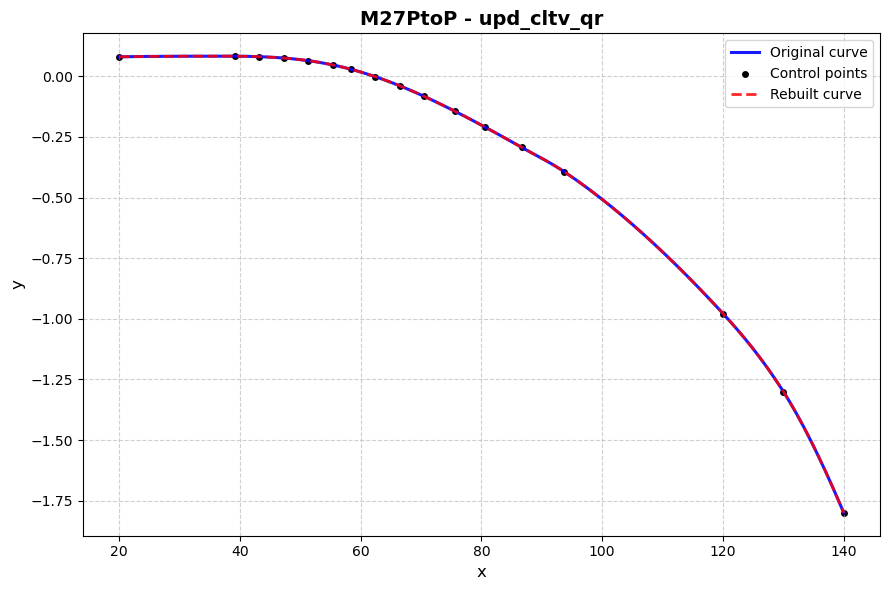

curve_x_upd_cltv_qr	20,20.6030150754,21.2060301508,21.8090452261,22.4120603015,23.0150753769,23.6180904523,24.2211055276,24.824120603,25.4271356784,26.0301507538,26.6331658291,27.2361809045,27.8391959799,28.4422110553,29.0452261307,29.648241206,30.2512562814,30.8542713568,31.4572864322,32.0603015075,32.6633165829,33.2663316583,33.8693467337,34.472361809,35.0753768844,35.6783919598,36.2814070352,36.8844221106,37.4874371859,38.0904522613,38.6934673367,39.2964824121,39.8994974874,40.5025125628,41.1055276382,41.7085427136,42.3115577889,42.9145728643,43.5175879397,44.1206030151,44.7236180905,45.3266331658,45.9296482412,46.5326633166,47.135678392,47.7386934673,48.3417085427,48.9447236181,49.5477386935,50.1507537688,50.7537688442,51.3567839196,51.959798995,52.5628140704,53.1658291457,53.7688442211,54.3718592965,54.9748743719,55.5778894472,56.1809045226,56.783919598,57.3869346734,57.9899497487,58.5929648241,59.1959798995,59.7989949749,60.4020100503,61.0050251256,61.608040201,62.2110552764,62.8

In [ ]:
model = read_model_file(r"C:\Git\LMSimData\data\STACR\ModelFiles\crt_1_8_0\gam_begg_stacr_M27PtoP_2025_10_02.txt")

df_original = pd.DataFrame({
    "x": model["curve_x_upd_cltv_qr"],
    "y": model["curve_y_upd_cltv_qr"]
})


controls = extract_control_points(df_original["x"], df_original["y"], tolerance=0.001)

print("Control points:", controls) 

df_curve = rebuild_curve(
    controls=[(20.0, 0.0802991275977751), (39.1919191919192, 0.0828962362988354), (43.2323232323232, 0.0807817738546119), (47.2727272727273, 0.0751974089194526), (51.3131313131313, 0.0643955745957666), (55.3535353535354, 0.0469372797076366), (58.3838383838384, 0.0289587383193171), (62.4242424242424, -0.00160803897831159), (66.4646464646465, -0.0391655606681622), (70.5050505050505, -0.0826727982336452), (75.5555555555556, -0.143553896372898), (80.6060606060606, -0.209572414351673), (86.6666666666667, -0.29312765039825), (93.7373737373737, -0.393991893186296), (120.0, -0.978142548853761), (130.0, -1.3), (140.0, -1.8)],
    x_original=model["curve_x_upd_cltv_qr"],
    y_original=model["curve_y_upd_cltv_qr"],
    method="pchip",
    title='M27PtoP - upd_cltv_qr'
)


formatted_txt = format_curve_df(df_curve, "upd_cltv_qr")
print(formatted_txt)


Control points: [(0.6, -2.0), (0.642211055276, -1.50335288011), (0.663316582915, -1.29117161223), (0.680904522613, -1.13802819056), (0.698492462312, -1.00973872189), (0.733668341709, -0.794394754323), (0.758291457286, -0.666874833032), (0.779396984925, -0.582748207934), (0.796984924623, -0.535913014109), (0.811055276382, -0.512520212672), (0.82864321608, -0.488617570139), (0.860301507538, -0.455868659975), (0.930653266332, -0.398563011844), (0.990452261307, -0.336851461613), (1.05025125628, -0.266918116058), (1.0783919598, -0.22845068794), (1.10301507538, -0.190820410592), (1.14522613065, -0.115262372637), (1.18743718593, -0.0255216344067), (1.24371859296, 0.111487305424), (1.3, 0.258448126036)]


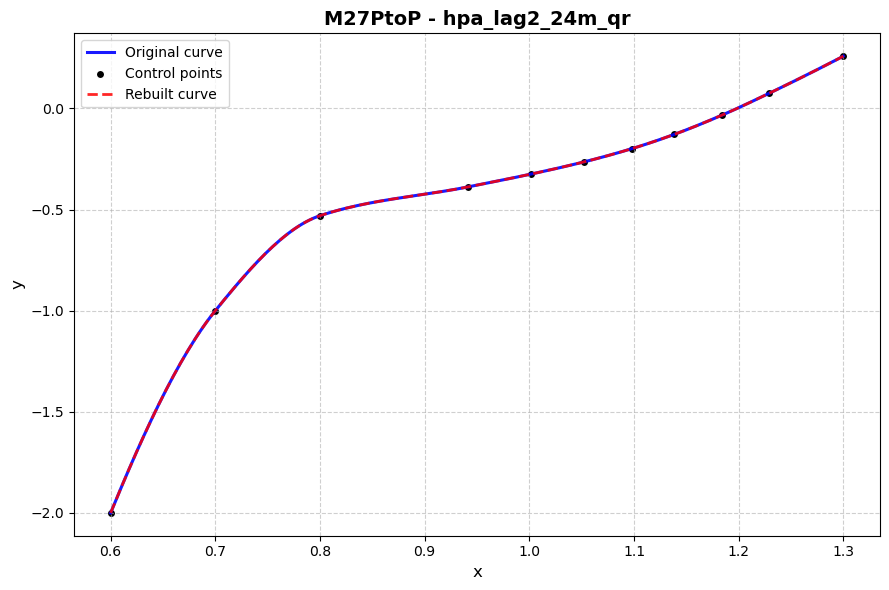

curve_x_hpa_lag2_24m_qr	0.6,0.60351758794,0.607035175879,0.610552763819,0.614070351759,0.617587939698,0.621105527638,0.624623115578,0.628140703518,0.631658291457,0.635175879397,0.638693467337,0.642211055276,0.645728643216,0.649246231156,0.652763819095,0.656281407035,0.659798994975,0.663316582915,0.666834170854,0.670351758794,0.673869346734,0.677386934673,0.680904522613,0.684422110553,0.687939698492,0.691457286432,0.694974874372,0.698492462312,0.702010050251,0.705527638191,0.709045226131,0.71256281407,0.71608040201,0.71959798995,0.723115577889,0.726633165829,0.730150753769,0.733668341709,0.737185929648,0.740703517588,0.744221105528,0.747738693467,0.751256281407,0.754773869347,0.758291457286,0.761809045226,0.765326633166,0.768844221106,0.772361809045,0.775879396985,0.779396984925,0.782914572864,0.786432160804,0.789949748744,0.793467336683,0.796984924623,0.800502512563,0.804020100503,0.807537688442,0.811055276382,0.814572864322,0.818090452261,0.821608040201,0.825125628141,0.82864321608,0.

In [ ]:
model = read_model_file(r"C:\Git\LMSimData\data\STACR\ModelFiles\crt_1_8_0\gam_begg_stacr_M27PtoP_2025_10_02.txt")

df_original = pd.DataFrame({
    "x": model["curve_x_hpa_lag2_24m_qr"],
    "y": model["curve_y_hpa_lag2_24m_qr"]
})


controls = extract_control_points(df_original["x"], df_original["y"], tolerance=0.001)

print("Control points:", controls) 

df_curve = rebuild_curve(
    controls=[(0.6, -2), (0.7, -1), (0.8, -0.530340028586031), (0.941414141414141, -0.388028625478381), (1.0020202020202, -0.324113460943269), (1.05252525252525, -0.263971591323355), (1.0979797979798, -0.198864325527816), (1.13838383838384, -0.12847000024675), (1.18383838383838, -0.0336213272318213), (1.22929292929293, 0.0753798778195951), (1.3, 0.258448126036032)],
    x_original=model["curve_x_hpa_lag2_24m_qr"],
    y_original=model["curve_y_hpa_lag2_24m_qr"],
    method="pchip",
    title='M27PtoP - hpa_lag2_24m_qr'
)


formatted_txt = format_curve_df(df_curve, "hpa_lag2_24m_qr")
print(formatted_txt)


Control points: [(60.0, -0.0784604433618), (77.6884422111, 0.236592452708), (78.4924623116, 0.250707079676), (79.2964824121, 0.264332211616), (80.5025125628, 0.284042765338), (81.7085427136, 0.303151386992), (84.5226130653, 0.347107624405), (85.7286432161, 0.366408763603), (86.9346733668, 0.386427345395), (87.7386934673, 0.400322001896), (88.5427135678, 0.414761055904), (88.9447236181, 0.422212923739), (89.7487437186, 0.437637724604), (90.1507537688, 0.445633211047), (90.5527638191, 0.453832457106), (90.9547738693, 0.462246739487), (91.3567839196, 0.470887334897), (91.7587939698, 0.479765520042), (92.1608040201, 0.488892571629), (92.5628140704, 0.498279766364), (92.9648241206, 0.507938380955), (93.3668341709, 0.517907447792), (93.7688442211, 0.528309294068), (94.1708542714, 0.539148077568), (94.5728643216, 0.550413468858), (94.9748743719, 0.562095138508), (95.3768844221, 0.574182757086), (95.7788944724, 0.586665995161), (96.1809045226, 0.5995345233), (96.5829145729, 0.612778012073), (9

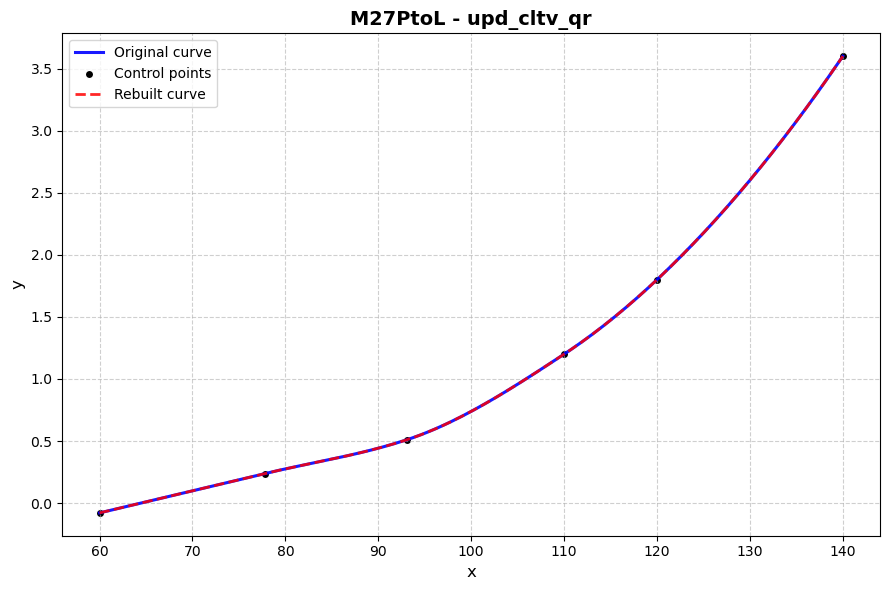

curve_x_upd_cltv_qr	60,60.4020100503,60.8040201005,61.2060301508,61.608040201,62.0100502513,62.4120603015,62.8140703518,63.216080402,63.6180904523,64.0201005025,64.4221105528,64.824120603,65.2261306533,65.6281407035,66.0301507538,66.432160804,66.8341708543,67.2361809045,67.6381909548,68.040201005,68.4422110553,68.8442211055,69.2462311558,69.648241206,70.0502512563,70.4522613065,70.8542713568,71.256281407,71.6582914573,72.0603015075,72.4623115578,72.864321608,73.2663316583,73.6683417085,74.0703517588,74.472361809,74.8743718593,75.2763819095,75.6783919598,76.0804020101,76.4824120603,76.8844221106,77.2864321608,77.6884422111,78.0904522613,78.4924623116,78.8944723618,79.2964824121,79.6984924623,80.1005025126,80.5025125628,80.9045226131,81.3065326633,81.7085427136,82.1105527638,82.5125628141,82.9145728643,83.3165829146,83.7185929648,84.1206030151,84.5226130653,84.9246231156,85.3266331658,85.7286432161,86.1306532663,86.5326633166,86.9346733668,87.3366834171,87.7386934673,88.1407035176,88.542

In [ ]:
model = read_model_file(r"C:\Git\LMSimData\data\STACR\ModelFiles\crt_1_8_0\gam_begg_stacr_M27PtoL_2025_10_02.txt")

df_original = pd.DataFrame({
    "x": model["curve_x_upd_cltv_qr"],
    "y": model["curve_y_upd_cltv_qr"]
})


controls = extract_control_points(df_original["x"], df_original["y"], tolerance=0.0001)

print("Control points:", controls) 

df_curve = rebuild_curve(
    controls=[(60.0, -0.0784604433618067), (77.7777777777778, 0.238184729792491), (93.1313131313131, 0.51202054966017), (110, 1.2), (120, 1.8), (140, 3.6)],
    x_original=model["curve_x_upd_cltv_qr"],
    y_original=model["curve_y_upd_cltv_qr"],
    method="pchip",
    title='M27PtoL - upd_cltv_qr'
)


formatted_txt = format_curve_df(df_curve, "upd_cltv_qr")
print(formatted_txt)


Control points: [(0.8, 3.0), (0.84824120603, 2.38143548719), (0.89648241206, 1.838791525), (0.920603015075, 1.59837038572), (0.94472361809, 1.3798461465), (0.968844221106, 1.18419106145), (0.989949748744, 1.03251703594), (1.00804020101, 0.91779343521), (1.02914572864, 0.802620121394), (1.05326633166, 0.688571572759), (1.11055276382, 0.437283367132), (1.17989949749, 0.0978356564536), (1.2824120603, -0.423718362401), (1.4, -1.03961852499)]


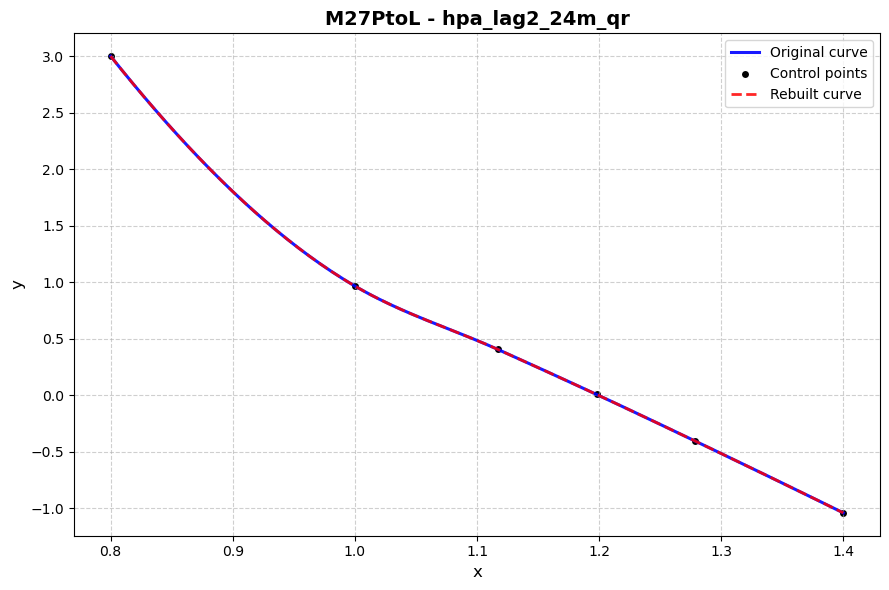

curve_x_hpa_lag2_24m_qr	0.8,0.803015075377,0.806030150754,0.809045226131,0.812060301508,0.815075376884,0.818090452261,0.821105527638,0.824120603015,0.827135678392,0.830150753769,0.833165829146,0.836180904523,0.839195979899,0.842211055276,0.845226130653,0.84824120603,0.851256281407,0.854271356784,0.857286432161,0.860301507538,0.863316582915,0.866331658291,0.869346733668,0.872361809045,0.875376884422,0.878391959799,0.881407035176,0.884422110553,0.88743718593,0.890452261307,0.893467336683,0.89648241206,0.899497487437,0.902512562814,0.905527638191,0.908542713568,0.911557788945,0.914572864322,0.917587939698,0.920603015075,0.923618090452,0.926633165829,0.929648241206,0.932663316583,0.93567839196,0.938693467337,0.941708542714,0.94472361809,0.947738693467,0.950753768844,0.953768844221,0.956783919598,0.959798994975,0.962814070352,0.965829145729,0.968844221106,0.971859296482,0.974874371859,0.977889447236,0.980904522613,0.98391959799,0.986934673367,0.989949748744,0.992964824121,0.995979899497,0.9

In [ ]:
model = read_model_file(r"C:\Git\LMSimData\data\STACR\ModelFiles\crt_1_8_0\gam_begg_stacr_M27PtoL_2025_10_02.txt")

df_original = pd.DataFrame({
    "x": model["curve_x_hpa_lag2_24m_qr"],
    "y": model["curve_y_hpa_lag2_24m_qr"]
})


controls = extract_control_points(df_original["x"], df_original["y"], tolerance=0.001)

print("Control points:", controls) 

df_curve = rebuild_curve(
    controls=[(0.8, 3), (1.0, 0.966895921900539), (1.11717171717172, 0.405696904946433), (1.1979797979798, 0.00759954350065028), (1.27878787878788, -0.404990517856911), (1.4, -1.03961852498561)],
    x_original=model["curve_x_hpa_lag2_24m_qr"],
    y_original=model["curve_y_hpa_lag2_24m_qr"],
    method="pchip",
    title='M27PtoL - hpa_lag2_24m_qr'
)


formatted_txt = format_curve_df(df_curve, "hpa_lag2_24m_qr")
print(formatted_txt)


Control points: [(0.6, 0.55), (0.702010050251, 0.366416944691), (0.779396984925, 0.26740270314), (0.849748743719, 0.219852297659), (1.03266331658, 0.142375673475), (1.12060301508, 0.0531524551581), (1.21206030151, -0.147092816175), (1.3, -0.454506994503)]


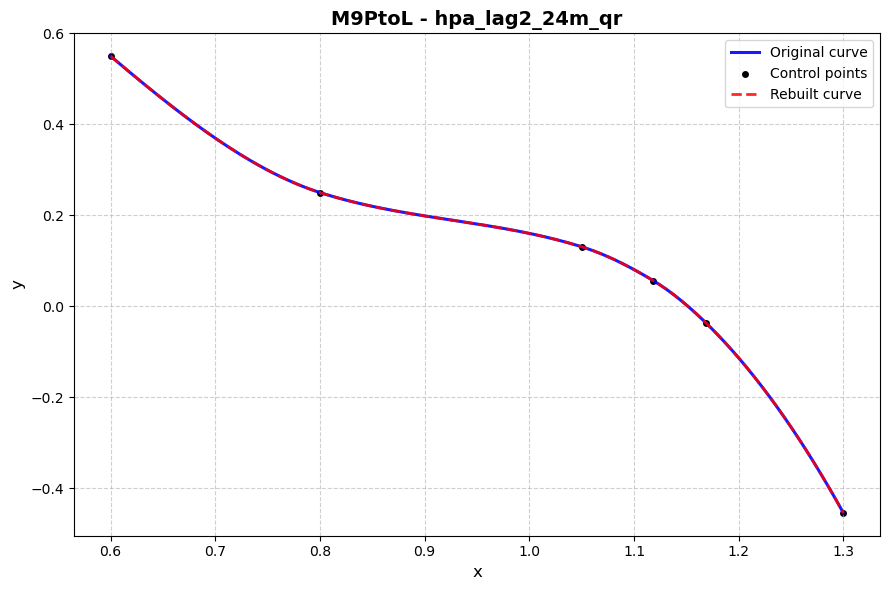

curve_x_hpa_lag2_24m_qr	0.6,0.60351758794,0.607035175879,0.610552763819,0.614070351759,0.617587939698,0.621105527638,0.624623115578,0.628140703518,0.631658291457,0.635175879397,0.638693467337,0.642211055276,0.645728643216,0.649246231156,0.652763819095,0.656281407035,0.659798994975,0.663316582915,0.666834170854,0.670351758794,0.673869346734,0.677386934673,0.680904522613,0.684422110553,0.687939698492,0.691457286432,0.694974874372,0.698492462312,0.702010050251,0.705527638191,0.709045226131,0.71256281407,0.71608040201,0.71959798995,0.723115577889,0.726633165829,0.730150753769,0.733668341709,0.737185929648,0.740703517588,0.744221105528,0.747738693467,0.751256281407,0.754773869347,0.758291457286,0.761809045226,0.765326633166,0.768844221106,0.772361809045,0.775879396985,0.779396984925,0.782914572864,0.786432160804,0.789949748744,0.793467336683,0.796984924623,0.800502512563,0.804020100503,0.807537688442,0.811055276382,0.814572864322,0.818090452261,0.821608040201,0.825125628141,0.82864321608,0.

In [ ]:
model = read_model_file(r"C:\Git\LMSimData\data\STACR\ModelFiles\crt_1_8_0\gam_begg_stacr_M9PtoL_2025_10_02.txt")

df_original = pd.DataFrame({
    "x": model["curve_x_hpa_lag2_24m_qr"],
    "y": model["curve_y_hpa_lag2_24m_qr"]
})


controls = extract_control_points(df_original["x"], df_original["y"], tolerance=0.01)

print("Control points:", controls) 

df_curve = rebuild_curve(
    controls=[(0.6, 0.55), (0.8, 0.25), (1.05, 0.130802059697638), (1.11818181818182, 0.0565690343383926), (1.16868686868687, -0.036540927197312), (1.3, -0.454506994503189)],
    x_original=model["curve_x_hpa_lag2_24m_qr"],
    y_original=model["curve_y_hpa_lag2_24m_qr"],
    method="pchip",
    title='M9PtoL - hpa_lag2_24m_qr'
)


formatted_txt = format_curve_df(df_curve, "hpa_lag2_24m_qr")
print(formatted_txt)


Control points: [(60.0, -0.368747862386), (83.216080402, 0.814218302875), (89.8994974874, 1.15465456341), (90.2512562814, 1.17244023202), (90.6030150754, 1.18999084439), (90.9547738693, 1.20733505959), (91.6582914573, 1.24151893484), (92.3618090452, 1.27522113046), (94.1206030151, 1.358873873), (94.824120603, 1.39269571219), (95.175879397, 1.40979857001), (95.8793969849, 1.44453145754), (96.2311557789, 1.46221880541), (96.5829145729, 1.48015830147), (96.9346733668, 1.4983786048), (97.2864321608, 1.51690837448), (97.6381909548, 1.5357762696), (97.9899497487, 1.55501094924), (98.3417085427, 1.57464107248), (98.6934673367, 1.59469529842), (99.0452261307, 1.61520228613), (99.3969849246, 1.6361906947), (99.7487437186, 1.65768957402), (100.100502513, 1.6797165788), (100.452261307, 1.70226211967), (100.804020101, 1.72531375245), (101.155778894, 1.74885903298), (101.507537688, 1.77288551711), (101.859296482, 1.79738076067), (102.211055276, 1.82233231949), (102.56281407, 1.8477277494), (102.914

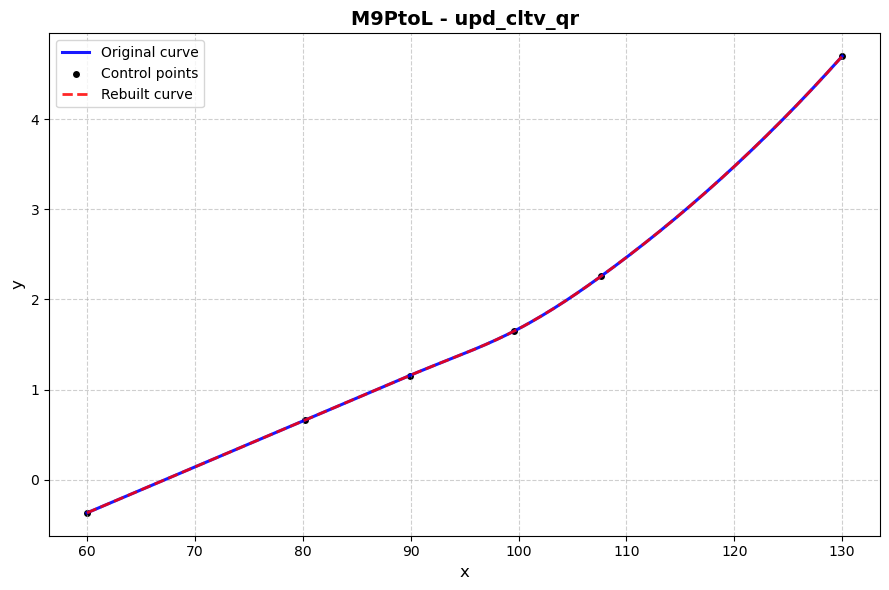

curve_x_upd_cltv_qr	60,60.351758794,60.7035175879,61.0552763819,61.4070351759,61.7587939698,62.1105527638,62.4623115578,62.8140703518,63.1658291457,63.5175879397,63.8693467337,64.2211055276,64.5728643216,64.9246231156,65.2763819095,65.6281407035,65.9798994975,66.3316582915,66.6834170854,67.0351758794,67.3869346734,67.7386934673,68.0904522613,68.4422110553,68.7939698492,69.1457286432,69.4974874372,69.8492462312,70.2010050251,70.5527638191,70.9045226131,71.256281407,71.608040201,71.959798995,72.3115577889,72.6633165829,73.0150753769,73.3668341709,73.7185929648,74.0703517588,74.4221105528,74.7738693467,75.1256281407,75.4773869347,75.8291457286,76.1809045226,76.5326633166,76.8844221106,77.2361809045,77.5879396985,77.9396984925,78.2914572864,78.6432160804,78.9949748744,79.3467336683,79.6984924623,80.0502512563,80.4020100503,80.7537688442,81.1055276382,81.4572864322,81.8090452261,82.1608040201,82.5125628141,82.864321608,83.216080402,83.567839196,83.9195979899,84.2713567839,84.6231155779,84.9

In [ ]:
model = read_model_file(r"C:\Git\LMSimData\data\STACR\ModelFiles\crt_1_8_0\gam_begg_stacr_M9PtoL_2025_10_02.txt")

df_original = pd.DataFrame({
    "x": model["curve_x_upd_cltv_qr"],
    "y": model["curve_y_upd_cltv_qr"]
})


controls = extract_control_points(df_original["x"], df_original["y"], tolerance=0.0001)

print("Control points:", controls) 

df_curve = rebuild_curve(
    controls=[(60.0, -0.36874786238582), (80.2020202020202, 0.660660765921848), (89.8989898989899, 1.15462871501456), (99.5959595959596, 1.64828695794612), (107.676767676768, 2.25931903818543), (130.0, 4.6983907538912)],
    x_original=model["curve_x_upd_cltv_qr"],
    y_original=model["curve_y_upd_cltv_qr"],
    method="pchip",
    title='M9PtoL - upd_cltv_qr'
)


formatted_txt = format_curve_df(df_curve, "upd_cltv_qr")
print(formatted_txt)


Control points: [(0.75, 1.0), (0.777638190955, 0.729336543397), (0.802763819095, 0.52367788225), (0.815326633166, 0.440517308538), (0.825376884422, 0.38526807061), (0.837939698492, 0.331998644795), (0.847989949749, 0.30327452935), (0.865577889447, 0.271924896948), (0.883165829146, 0.247767288482), (0.903266331658, 0.227452577135), (0.925879396985, 0.212166236329), (0.958542713568, 0.199112361979), (0.998743718593, 0.189087395093), (1.06658291457, 0.188724062714), (1.08417085427, 0.186214364995), (1.10427135678, 0.177220411493), (1.1243718593, 0.158685818955), (1.13693467337, 0.141199522522), (1.14949748744, 0.119123343844), (1.16206030151, 0.0923965070129), (1.17713567839, 0.054621801112), (1.21231155779, -0.0516692836706), (1.25, -0.180114393261)]


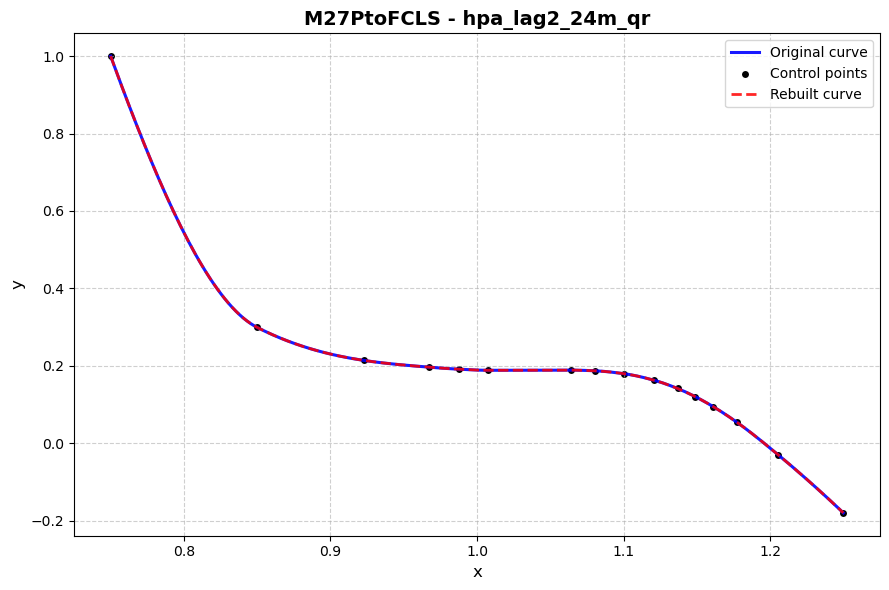

curve_x_hpa_lag2_24m_qr	0.75,0.752512562814,0.755025125628,0.757537688442,0.760050251256,0.76256281407,0.765075376884,0.767587939698,0.770100502513,0.772613065327,0.775125628141,0.777638190955,0.780150753769,0.782663316583,0.785175879397,0.787688442211,0.790201005025,0.792713567839,0.795226130653,0.797738693467,0.800251256281,0.802763819095,0.80527638191,0.807788944724,0.810301507538,0.812814070352,0.815326633166,0.81783919598,0.820351758794,0.822864321608,0.825376884422,0.827889447236,0.83040201005,0.832914572864,0.835427135678,0.837939698492,0.840452261307,0.842964824121,0.845477386935,0.847989949749,0.850502512563,0.853015075377,0.855527638191,0.858040201005,0.860552763819,0.863065326633,0.865577889447,0.868090452261,0.870603015075,0.873115577889,0.875628140704,0.878140703518,0.880653266332,0.883165829146,0.88567839196,0.888190954774,0.890703517588,0.893216080402,0.895728643216,0.89824120603,0.900753768844,0.903266331658,0.905778894472,0.908291457286,0.910804020101,0.913316582915,0.

In [ ]:
model = read_model_file(r"C:\Git\LMSimData\data\STACR\ModelFiles\crt_1_8_0\gam_begg_stacr_M27PtoFCLS_2025_10_02.txt")

df_original = pd.DataFrame({
    "x": model["curve_x_hpa_lag2_24m_qr"],
    "y": model["curve_y_hpa_lag2_24m_qr"]
})


controls = extract_control_points(df_original["x"], df_original["y"], tolerance=0.001)

print("Control points:", controls) 

df_curve = rebuild_curve(
    controls=[(0.75, 1), (0.85, 0.299112592508392), (0.922727272727273, 0.213891742050166), (0.967171717171717, 0.196450754764638), (0.987373737373737, 0.191205383301498), (1.00757575757576, 0.18831357862108), (1.06414141414141, 0.188779521385056), (1.08030303030303, 0.1870474881234), (1.10050505050505, 0.179444915953276), (1.12070707070707, 0.162770970947128), (1.13686868686869, 0.141299927296873), (1.1489898989899, 0.120098089959415), (1.16111111111111, 0.0945689752897115), (1.17727272727273, 0.0542525714857122), (1.20555555555556, -0.0301554110991344), (1.25, -0.180114393260692)],
    x_original=model["curve_x_hpa_lag2_24m_qr"],
    y_original=model["curve_y_hpa_lag2_24m_qr"],
    method="pchip",
    title='M27PtoFCLS - hpa_lag2_24m_qr'
)


formatted_txt = format_curve_df(df_curve, "hpa_lag2_24m_qr")
print(formatted_txt)


Control points: [(40.0, -0.118108148467), (62.1105527638, 0.0224100674313), (62.6130653266, 0.0255880732373), (63.1155778894, 0.0287182382133), (63.6180904523, 0.0318036129321), (64.1206030151, 0.0348485530149), (64.6231155779, 0.0378574140831), (65.1256281407, 0.0408345517577), (65.6281407035, 0.0437843216602), (66.1306532663, 0.0467110794117), (66.6331658291, 0.0496191806334), (67.135678392, 0.0525129809467), (67.6381909548, 0.0553968359727), (68.6432160804, 0.061152132648), (69.1457286432, 0.0640322855398), (69.648241206, 0.0669199156293), (70.1507537688, 0.0698193785378), (70.6532663317, 0.0727350298865), (71.1557788945, 0.0756712252967), (71.6582914573, 0.0786323203896), (72.1608040201, 0.0816226707864), (72.6633165829, 0.0846466321085), (73.1658291457, 0.0877085599769), (73.6683417085, 0.0908128100131), (74.1708542714, 0.0939637378382), (74.6733668342, 0.0971656990735), (75.175879397, 0.10042304934), (75.6783919598, 0.10374014426), (76.1809045226, 0.107121339453), (76.6834170854,

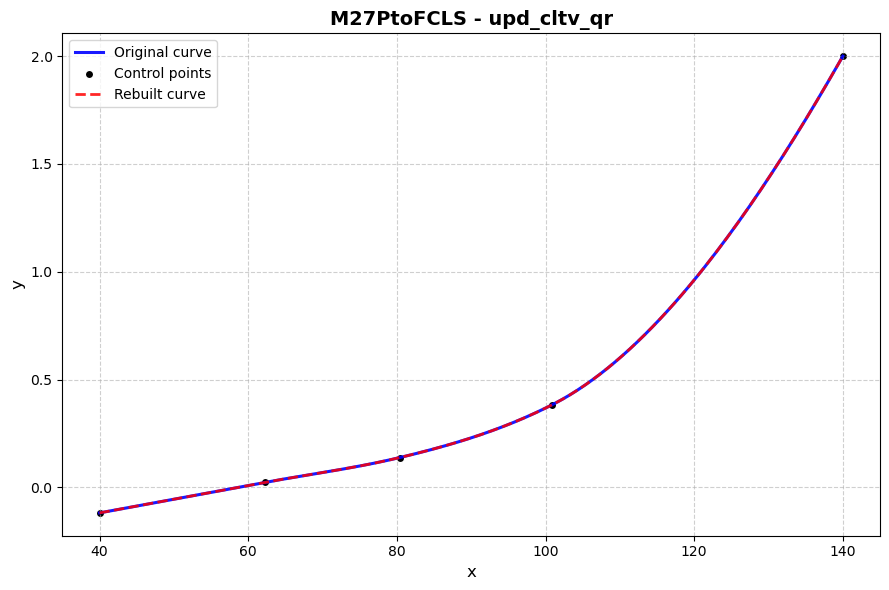

curve_x_upd_cltv_qr	40,40.5025125628,41.0050251256,41.5075376884,42.0100502513,42.5125628141,43.0150753769,43.5175879397,44.0201005025,44.5226130653,45.0251256281,45.527638191,46.0301507538,46.5326633166,47.0351758794,47.5376884422,48.040201005,48.5427135678,49.0452261307,49.5477386935,50.0502512563,50.5527638191,51.0552763819,51.5577889447,52.0603015075,52.5628140704,53.0653266332,53.567839196,54.0703517588,54.5728643216,55.0753768844,55.5778894472,56.0804020101,56.5829145729,57.0854271357,57.5879396985,58.0904522613,58.5929648241,59.0954773869,59.5979899497,60.1005025126,60.6030150754,61.1055276382,61.608040201,62.1105527638,62.6130653266,63.1155778894,63.6180904523,64.1206030151,64.6231155779,65.1256281407,65.6281407035,66.1306532663,66.6331658291,67.135678392,67.6381909548,68.1407035176,68.6432160804,69.1457286432,69.648241206,70.1507537688,70.6532663317,71.1557788945,71.6582914573,72.1608040201,72.6633165829,73.1658291457,73.6683417085,74.1708542714,74.6733668342,75.175879397,75.6

In [ ]:
model = read_model_file(r"C:\Git\LMSimData\data\STACR\ModelFiles\crt_1_8_0\gam_begg_stacr_M27PtoFCLS_2025_10_02.txt")
df_original = pd.DataFrame({
    "x": model["curve_x_upd_cltv_qr"],
    "y": model["curve_y_upd_cltv_qr"]
})


controls = extract_control_points(df_original["x"], df_original["y"], tolerance=0.000001)

print("Control points:", controls) 

df_curve = rebuild_curve(
    controls=[(40.0, -0.118108148467072), (62.2222222222222, 0.0231197461395246), (80.4040404040404, 0.13866692747589), (100.909090909091, 0.383626835829971), (140, 2)],
    x_original=model["curve_x_upd_cltv_qr"],
    y_original=model["curve_y_upd_cltv_qr"],
    method="pchip",
    title='M27PtoFCLS - upd_cltv_qr'
)


formatted_txt = format_curve_df(df_curve, "upd_cltv_qr")
print(formatted_txt)


Control points: [(10.0, 0.668691974201), (14.5728643216, 0.593572998278), (19.1457286432, 0.521743599004), (23.7185929648, 0.453055908618), (28.9447236181, 0.378148467428), (34.1708542714, 0.306843026821), (39.3969849246, 0.238873757837), (44.6231155779, 0.173958604901), (49.8492462312, 0.11217875427), (54.4221105528, 0.0627114532538), (58.3417085427, 0.0256754580992), (63.567839196, -0.0160553027908), (72.7135678392, -0.0812113580034), (77.2864321608, -0.116819309253), (84.472361809, -0.179382060815), (86.432160804, -0.19918574015), (88.391959799, -0.222013228343), (89.6984924623, -0.239620421351), (91.0050251256, -0.259434585514), (92.3115577889, -0.282106709593), (93.6180904523, -0.307380929294), (94.9246231156, -0.335378589705), (96.2311557789, -0.366126084067), (97.5376884422, -0.399345091013), (98.8442211055, -0.43526508686), (100.804020101, -0.494050418516), (102.110552764, -0.536351330525), (103.417085427, -0.581209197874), (105.376884422, -0.653166430368), (106.683417085, -0.7

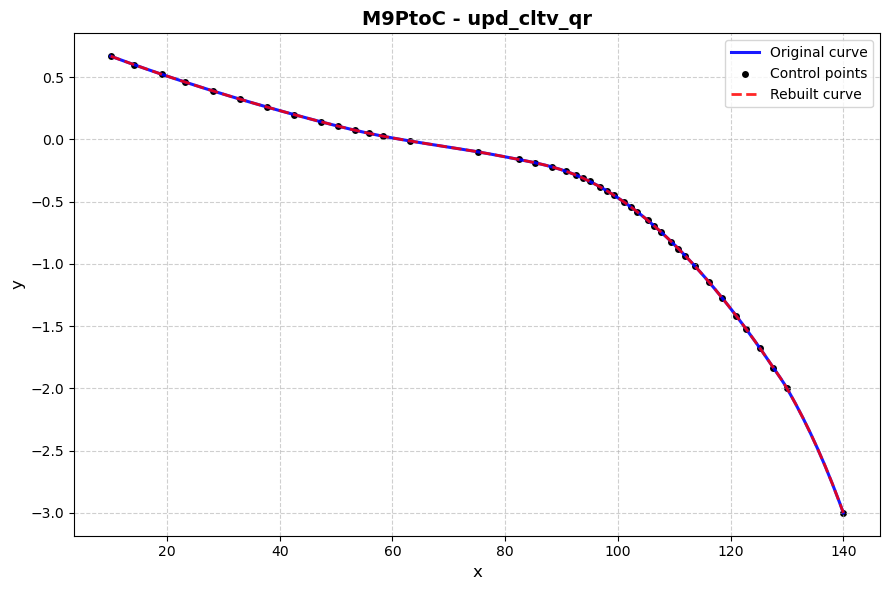

curve_x_upd_cltv_qr	10,10.6532663317,11.3065326633,11.959798995,12.6130653266,13.2663316583,13.9195979899,14.5728643216,15.2261306533,15.8793969849,16.5326633166,17.1859296482,17.8391959799,18.4924623116,19.1457286432,19.7989949749,20.4522613065,21.1055276382,21.7587939698,22.4120603015,23.0653266332,23.7185929648,24.3718592965,25.0251256281,25.6783919598,26.3316582915,26.9849246231,27.6381909548,28.2914572864,28.9447236181,29.5979899497,30.2512562814,30.9045226131,31.5577889447,32.2110552764,32.864321608,33.5175879397,34.1708542714,34.824120603,35.4773869347,36.1306532663,36.783919598,37.4371859296,38.0904522613,38.743718593,39.3969849246,40.0502512563,40.7035175879,41.3567839196,42.0100502513,42.6633165829,43.3165829146,43.9698492462,44.6231155779,45.2763819095,45.9296482412,46.5829145729,47.2361809045,47.8894472362,48.5427135678,49.1959798995,49.8492462312,50.5025125628,51.1557788945,51.8090452261,52.4623115578,53.1155778894,53.7688442211,54.4221105528,55.0753768844,55.7286432161,56

In [ ]:
model = read_model_file(r"C:\Git\LMSimData\data\STACR\ModelFiles\crt_1_8_0\gam_begg_stacr_M9PtoP_2025_10_02.txt")

df_original = pd.DataFrame({
    "x": model["curve_x_upd_cltv_qr"],
    "y": model["curve_y_upd_cltv_qr"]
})


controls = extract_control_points(df_original["x"], df_original["y"], tolerance=0.001)

print("Control points:", controls) 
df_curve = rebuild_curve(
    controls=[(10.0, 0.668691974201), (14.2211055276, 0.599226686944), (19.0452261307, 0.523289215578), (23.2663316583, 0.459709870556), (28.0904522613, 0.390139056156), (32.9145728643, 0.323669282425), (37.7386934673, 0.260095673041), (42.5628140704, 0.19921335168), (47.3869346734, 0.140824882556), (50.4020100503, 0.105930353352), (53.4170854271, 0.0730865305629), (55.8291457286, 0.0487607564562), (58.2412060302, 0.0265430036202), (63.0653266332, -0.0122313332108), (75.1256281407, -0.0994153580434), (82.3618090452, -0.160458156471), (85.3768844221, -0.18816531114), (88.391959799, -0.222013228343), (90.8040201005, -0.256232540871), (92.6130653266, -0.287667762901), (93.8190954774, -0.311515296492), (95.0251256281, -0.337651715506), (96.8341708543, -0.381103586012), (98.040201005, -0.412873382215), (99.2462311558, -0.446860994744), (101.055276382, -0.501956400965), (102.261306533, -0.54139971794), (103.467336683, -0.582989782144), (105.27638191, -0.64935561132), (106.48241206, -0.696223707226), (107.688442211, -0.745167481264), (109.497487437, -0.822430620634), (110.703517588, -0.876474753631), (111.909547739, -0.932523495663), (113.718592965, -1.02031083247), (116.130653266, -1.1441872289), (118.542713568, -1.27571656326), (120.954773869, -1.41473639189), (122.763819095, -1.52381918022), (125.175879397, -1.6755564938), (127.587939698, -1.83433758161), (130.0, -2.0), (140, -3)],
    x_original=model["curve_x_upd_cltv_qr"],
    y_original=model["curve_y_upd_cltv_qr"],
    method="pchip",
    title='M9PtoC - upd_cltv_qr'
)


formatted_txt = format_curve_df(df_curve, "upd_cltv_qr")
print(formatted_txt)

Control points: [(0.6, -0.8), (0.644221105528, -0.63138152866), (0.672361809045, -0.542384536887), (0.684422110553, -0.513726302103), (0.69648241206, -0.490743727074), (0.740703517588, -0.41682033525), (0.784924623116, -0.355557623923), (0.837185929648, -0.295370116189), (0.881407035176, -0.251300213911), (1.06231155779, -0.0812092640071), (1.10251256281, -0.0386986374594), (1.14271356784, 0.00951621043326), (1.18693467337, 0.0692784910397), (1.2432160804, 0.155026717167), (1.32361809045, 0.28873246583), (1.4, 0.421071433008)]


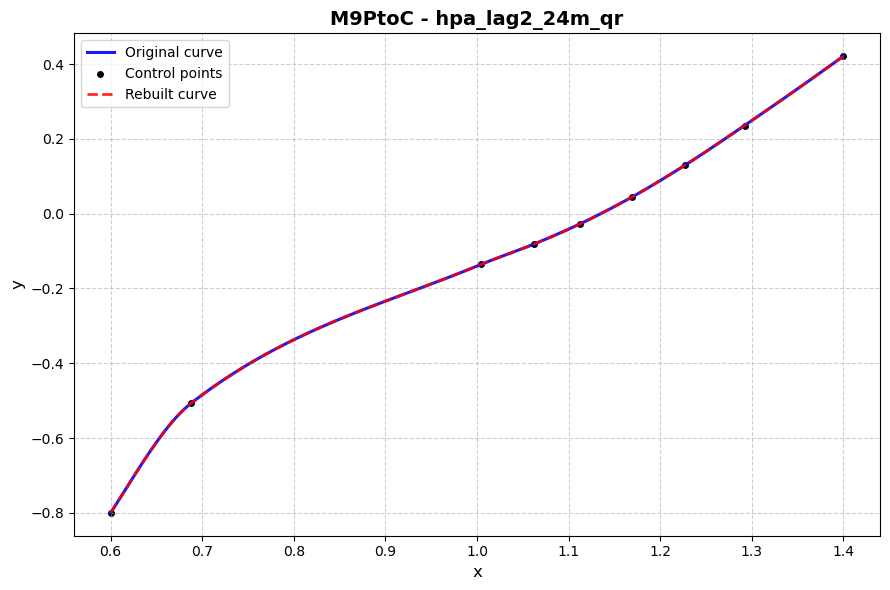

curve_x_hpa_lag2_24m_qr	0.6,0.604020100503,0.608040201005,0.612060301508,0.61608040201,0.620100502513,0.624120603015,0.628140703518,0.63216080402,0.636180904523,0.640201005025,0.644221105528,0.64824120603,0.652261306533,0.656281407035,0.660301507538,0.66432160804,0.668341708543,0.672361809045,0.676381909548,0.68040201005,0.684422110553,0.688442211055,0.692462311558,0.69648241206,0.700502512563,0.704522613065,0.708542713568,0.71256281407,0.716582914573,0.720603015075,0.724623115578,0.72864321608,0.732663316583,0.736683417085,0.740703517588,0.74472361809,0.748743718593,0.752763819095,0.756783919598,0.760804020101,0.764824120603,0.768844221106,0.772864321608,0.776884422111,0.780904522613,0.784924623116,0.788944723618,0.792964824121,0.796984924623,0.801005025126,0.805025125628,0.809045226131,0.813065326633,0.817085427136,0.821105527638,0.825125628141,0.829145728643,0.833165829146,0.837185929648,0.841206030151,0.845226130653,0.849246231156,0.853266331658,0.857286432161,0.861306532663,0.8653

In [76]:
model = read_model_file(r"C:\Git\LMSimData\data\STACR\ModelFiles\crt_1_8_0\gam_begg_stacr_M9PtoP_2025_10_02.txt")

df_original = pd.DataFrame({
    "x": model["curve_x_hpa_lag2_24m_qr"],
    "y": model["curve_y_hpa_lag2_24m_qr"]
})


controls = extract_control_points(df_original["x"], df_original["y"], tolerance=0.001)

print("Control points:", controls) 
df_curve = rebuild_curve(
    controls=[(0.6, -0.8), (0.687598568574545, -0.507387797962454), (1.00422142698586, -0.135825157753384), (1.06178921942428, -0.0817335708422123), (1.1121610378079, -0.0277008532978301), (1.16972883024632, 0.0451477965964931), (1.22729662268474, 0.129932598556386), (1.29206038917796, 0.235620179662519), (1.4, 0.421071433007882)],
    x_original=model["curve_x_hpa_lag2_24m_qr"],
    y_original=model["curve_y_hpa_lag2_24m_qr"],
    method="pchip",
    title='M9PtoC - hpa_lag2_24m_qr'
)


formatted_txt = format_curve_df(df_curve, "hpa_lag2_24m_qr")
print(formatted_txt)

Control points: [(0.0, -0.301784198), (0.084422111, 0.022371223), (0.142713568, 0.157136127), (0.201005025, 0.251469404), (0.263316583, 0.328568614), (0.333668342, 0.391552244), (0.4, 0.43)]


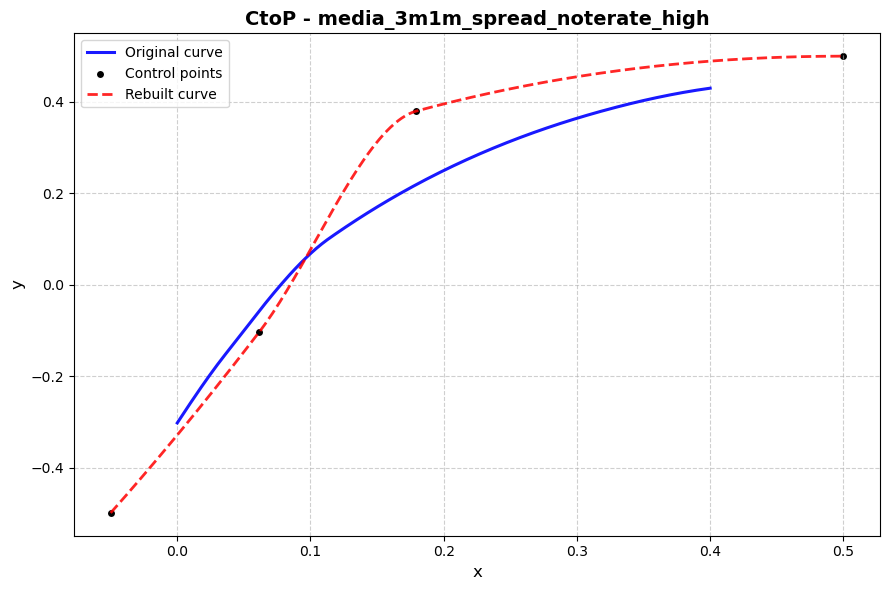

curve_x_media_3m1m_spread_noterate_high	-0.05,-0.0472361809045,-0.044472361809,-0.0417085427136,-0.0389447236181,-0.0361809045226,-0.0334170854271,-0.0306532663317,-0.0278894472362,-0.0251256281407,-0.0223618090452,-0.0195979899497,-0.0168341708543,-0.0140703517588,-0.0113065326633,-0.00854271356784,-0.00577889447236,-0.00301507537688,-0.000251256281407,0.00251256281407,0.00527638190955,0.00804020100503,0.0108040201005,0.013567839196,0.0163316582915,0.0190954773869,0.0218592964824,0.0246231155779,0.0273869346734,0.0301507537688,0.0329145728643,0.0356783919598,0.0384422110553,0.0412060301508,0.0439698492462,0.0467336683417,0.0494974874372,0.0522613065327,0.0550251256281,0.0577889447236,0.0605527638191,0.0633165829146,0.0660804020101,0.0688442211055,0.071608040201,0.0743718592965,0.077135678392,0.0798994974874,0.0826633165829,0.0854271356784,0.0881909547739,0.0909547738693,0.0937185929648,0.0964824120603,0.0992462311558,0.102010050251,0.104773869347,0.107537688442,0.110301507538,0.113065

In [356]:
model = read_model_file(r"N:\LMSimData\data\JUMBO2\ModelFiles\1.8.0\jumbo_refinance_1.5.update_2025_11_30_17_12_13.138016.txt")

df_original = pd.DataFrame({
    "x": model["curve_x_pmms30_spread_3m_noterate_high"],
    "y": model["curve_y_pmms30_spread_3m_noterate_high"]
})

controls = extract_control_points(df_original["x"], df_original["y"], tolerance=0.005)
print("Control points:", controls) 

df_curve = rebuild_curve(
    controls=[(-0.05, -0.498430790342934), (0.0616161616161616, -0.102615300986624), (0.17949494949495, 0.38), (0.5, 0.5)],
    x_original=model["curve_x_pmms30_spread_3m_noterate_high"],
    y_original=model["curve_y_pmms30_spread_3m_noterate_high"],
    method="pchip",
    title='CtoP - media_3m1m_spread_noterate_high'
)

formatted_txt = format_curve_df(df_curve, "media_3m1m_spread_noterate_high")
print(formatted_txt)

Control points: [(-0.1, -2.44764057405), (0.0782244556114, -1.52515700516), (0.256448911223, -0.701788175253), (0.386066697122, -0.198968087275), (0.52378559464, 0.217335238181), (0.612897822446, 0.432168063644), (0.783021166438, 0.793219180543), (0.936942287194, 1.09535260131), (1.05845896147, 1.3105018974), (1.1151667428, 1.39129444153), (1.16377341252, 1.4452797132), (1.39870564946, 1.64062002165), (1.51212121212, 1.75359742591)]


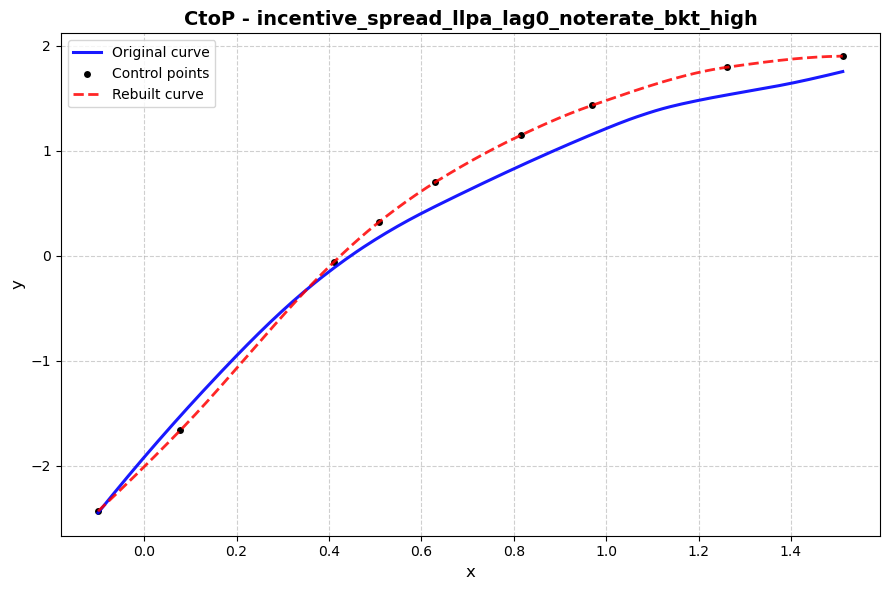

curve_x_incentive_spread_llpa_lag0_noterate_bkt_high	-0.1,-0.0918988883813,-0.0837977767626,-0.0756966651439,-0.0675955535252,-0.0594944419065,-0.0513933302878,-0.0432922186691,-0.0351911070505,-0.0270899954318,-0.0189888838131,-0.0108877721944,-0.00278666057568,0.00531445104302,0.0134155626617,0.0215166742804,0.0296177858991,0.0377188975178,0.0458200091365,0.0539211207552,0.0620222323739,0.0701233439926,0.0782244556113,0.0863255672299,0.0944266788486,0.102527790467,0.110628902086,0.118730013705,0.126831125323,0.134932236942,0.143033348561,0.151134460179,0.159235571798,0.167336683417,0.175437795036,0.183538906654,0.191640018273,0.199741129892,0.20784224151,0.215943353129,0.224044464748,0.232145576366,0.240246687985,0.248347799604,0.256448911223,0.264550022841,0.27265113446,0.280752246079,0.288853357697,0.296954469316,0.305055580935,0.313156692553,0.321257804172,0.329358915791,0.337460027409,0.345561139028,0.353662250647,0.361763362266,0.369864473884,0.377965585503,0.386066697122,0.3941

In [ ]:
model = read_model_file(r"C:\Git\LMSimData\data\JUMBO2\ModelFiles\1.8.0\jumbo_refinance_1.5.update_2026_01_07_17_44_36.265665.txt")

df_original = pd.DataFrame({
    "x": model["curve_x_incentive_spread_llpa_lag0_noterate_bkt_high"],
    "y": model["curve_y_incentive_spread_llpa_lag0_noterate_bkt_high"]
})

controls = extract_control_points(df_original["x"], df_original["y"], tolerance=0.005)
print("Control points:", controls) 

df_curve = rebuild_curve(
    controls=[(-0.0999999999999996, -2.44764057405113), (0.133333333333334, -1.26038270879831), (0.303030303030303, -0.508480631280845), (0.387878787878788, -0.192747976221402), (0.472727272727273, 0.0765891471424385), (0.557575757575758, 0.303144422363649), (0.642424242424243, 0.496905336071428), (0.981818181818182, 1.17817049463323), (1.06666666666667, 1.32309579807656), (1.13030303030303, 1.40970751263499), (1.19393939393939, 1.47380059460449), (1.40606060606061, 1.64724908141546), (1.51212121212121, 1.75359742590971)],
    x_original=model["curve_x_incentive_spread_llpa_lag0_noterate_bkt_high"],
    y_original=model["curve_y_incentive_spread_llpa_lag0_noterate_bkt_high"],
    method="pchip",
    title='CtoP - incentive_spread_llpa_lag0_noterate_bkt_high'
)

formatted_txt = format_curve_df(df_curve, "incentive_spread_llpa_lag0_noterate_bkt_high")
print(formatted_txt)

Control points: [(-0.0999999999999996, -2.53216702410046), (0.06969696969697, -1.80026496493316), (0.451515151515152, 0.0103585610942177), (0.6, 0.515123417093465), (0.76969696969697, 0.946823626158833), (0.960606060606061, 1.31860049507806), (1.27878787878788, 1.71255831908953), (1.40606060606061, 1.82544369567113), (1.83030303030303, 2.11518054531654), (2.0, 2.25563885000293)]


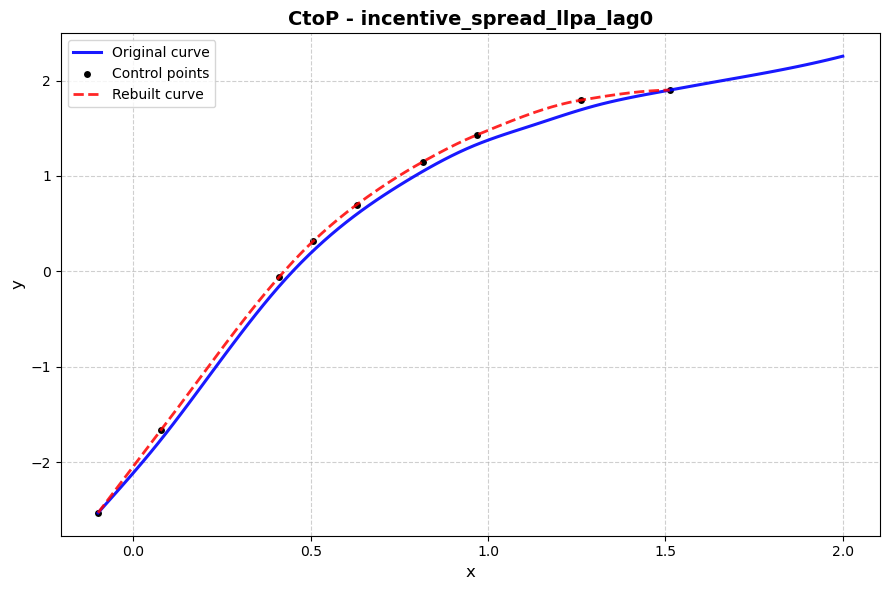

curve_x_incentive_spread_llpa_lag0	-0.1,-0.0918988883813,-0.0837977767626,-0.0756966651439,-0.0675955535252,-0.0594944419065,-0.0513933302878,-0.0432922186691,-0.0351911070505,-0.0270899954318,-0.0189888838131,-0.0108877721944,-0.00278666057568,0.00531445104302,0.0134155626617,0.0215166742804,0.0296177858991,0.0377188975178,0.0458200091365,0.0539211207552,0.0620222323739,0.0701233439926,0.0782244556113,0.0863255672299,0.0944266788486,0.102527790467,0.110628902086,0.118730013705,0.126831125323,0.134932236942,0.143033348561,0.151134460179,0.159235571798,0.167336683417,0.175437795036,0.183538906654,0.191640018273,0.199741129892,0.20784224151,0.215943353129,0.224044464748,0.232145576366,0.240246687985,0.248347799604,0.256448911223,0.264550022841,0.27265113446,0.280752246079,0.288853357697,0.296954469316,0.305055580935,0.313156692553,0.321257804172,0.329358915791,0.337460027409,0.345561139028,0.353662250647,0.361763362266,0.369864473884,0.377965585503,0.386066697122,0.39416780874,0.40226892

In [336]:
model = read_model_file(r"C:\Git\LMSimData\data\JUMBO2\ModelFiles\1.8.0\original\jumbo_refinance_1.5.update_2026_01_06_17_23_02.143751.txt")

df_original = pd.DataFrame({
    "x": model["curve_x_incentive_spread_llpa_lag0"],
    "y": model["curve_y_incentive_spread_llpa_lag0"]
})

controls = extract_control_points(df_original["x"], df_original["y"], tolerance=0.01)
print("Control points:", controls) 

df_curve = rebuild_curve(
    controls=[(-0.1, -2.53216702410046), (0.0782244556114, -1.66096691455), (0.410370031978, -0.060338780743), (0.507583371402, 0.318771296526), (0.629100045683, 0.697943006177), (0.815425612913, 1.14762503961), (0.969346733668, 1.43177025069), (1.26098675194, 1.79433757606), (1.51212121212, 1.90000152555)],
    x_original=model["curve_x_incentive_spread_llpa_lag0"],
    y_original=model["curve_y_incentive_spread_llpa_lag0"],
    method="pchip",
    title='CtoP - incentive_spread_llpa_lag0'
)

formatted_txt = format_curve_df(df_curve, "incentive_spread_llpa_lag0")
print(formatted_txt)

In [271]:
df_original

,x,y
0,-0.050000,-0.498431
1,-0.043434,-0.474674
2,-0.036869,-0.450920
3,-0.030303,-0.427174
4,-0.023737,-0.403440
...,...,...
95,0.573737,-0.029502
96,0.580303,-0.043409
97,0.586869,-0.057330
98,0.593434,-0.071260


Control points: [(-0.05, -0.605126162262583), (0.0873737373737374, -0.0884294959886501), (0.181818181818182, 0.209254707063496), (0.224747474747475, 0.312666558238053), (0.267676767676768, 0.39095080431615), (0.310606060606061, 0.441808649305297), (0.353535353535354, 0.464114204793219), (0.396464646464647, 0.458257217971695), (0.43939393939394, 0.425805967426437), (0.482323232323232, 0.369165563594944), (0.533838383838384, 0.273166622990587), (0.636868686868687, 0.0102401871789063), (0.8, -0.500106585194867)]


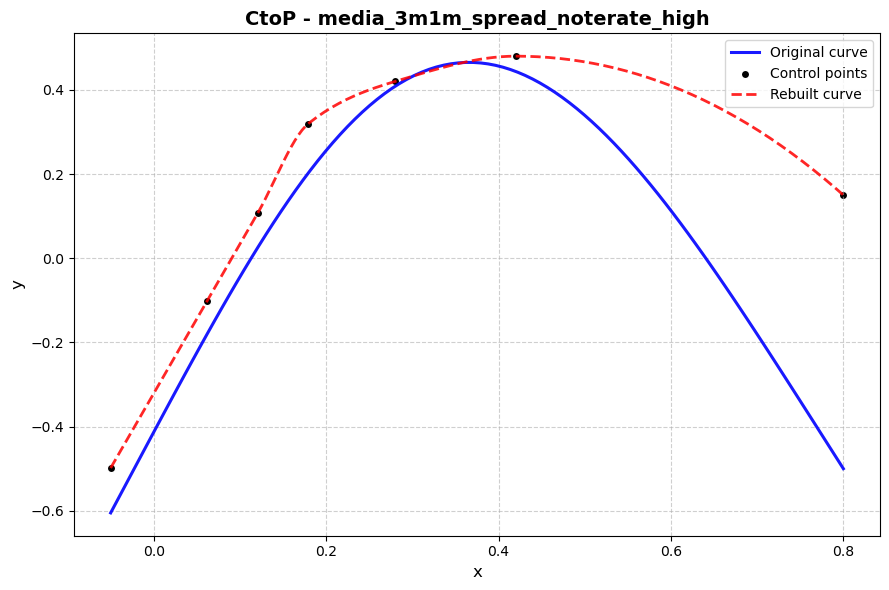

curve_x_media_3m1m_spread_noterate_high	-0.05,-0.0457286432161,-0.0414572864322,-0.0371859296482,-0.0329145728643,-0.0286432160804,-0.0243718592965,-0.0201005025126,-0.0158291457286,-0.0115577889447,-0.0072864321608,-0.00301507537688,0.00125628140704,0.00552763819095,0.00979899497487,0.0140703517588,0.0183417085427,0.0226130653266,0.0268844221106,0.0311557788945,0.0354271356784,0.0396984924623,0.0439698492462,0.0482412060302,0.0525125628141,0.056783919598,0.0610552763819,0.0653266331658,0.0695979899497,0.0738693467337,0.0781407035176,0.0824120603015,0.0866834170854,0.0909547738693,0.0952261306533,0.0994974874372,0.103768844221,0.108040201005,0.112311557789,0.116582914573,0.120854271357,0.125125628141,0.129396984925,0.133668341709,0.137939698492,0.142211055276,0.14648241206,0.150753768844,0.155025125628,0.159296482412,0.163567839196,0.16783919598,0.172110552764,0.176381909548,0.180653266332,0.184924623116,0.189195979899,0.193467336683,0.197738693467,0.202010050251,0.206281407035,0.21055

In [327]:
model = read_model_file(r"C:\Git\LMSimData\data\JUMBO2\ModelFiles\1.8.0\jumbo_refinance_1.5.update_2026_01_07_17_44_36.265665.txt")

df_original = pd.DataFrame({
    "x": model["curve_x_media_3m1m_spread_noterate_high"],
    "y": model["curve_y_media_3m1m_spread_noterate_high"]
})

controls = extract_control_points(df_original["x"], df_original["y"], tolerance=0.005)
print("Control points:", controls) 

df_curve = rebuild_curve(
    controls=[(-0.05, -0.498430790342934), (0.0616161616161616, -0.102615300986624), (0.120707070707071, 0.107404115236169), (0.17949494949495, 0.32), (0.28, 0.42), (0.42, 0.48), (0.8, 0.15)],
    x_original=model["curve_x_media_3m1m_spread_noterate_high"],
    y_original=model["curve_y_media_3m1m_spread_noterate_high"],
    method="pchip",
    title='CtoP - media_3m1m_spread_noterate_high'
)

formatted_txt = format_curve_df(df_curve, "media_3m1m_spread_noterate_high")
print(formatted_txt)

Control points: [(-0.05, -0.498430790342934), (0.0616161616161616, -0.102615300986624), (0.133838383838384, 0.117404115236169), (0.19949494949495, 0.262940091259448), (0.232323232323232, 0.311142446987713), (0.265151515151515, 0.341803932621353), (0.297979797979798, 0.354852370618013), (0.330808080808081, 0.350789429751581), (0.363636363636364, 0.330806977661115), (0.403030303030303, 0.288481496759121), (0.481818181818182, 0.15905166406414), (0.6, -0.0851949282842198)]


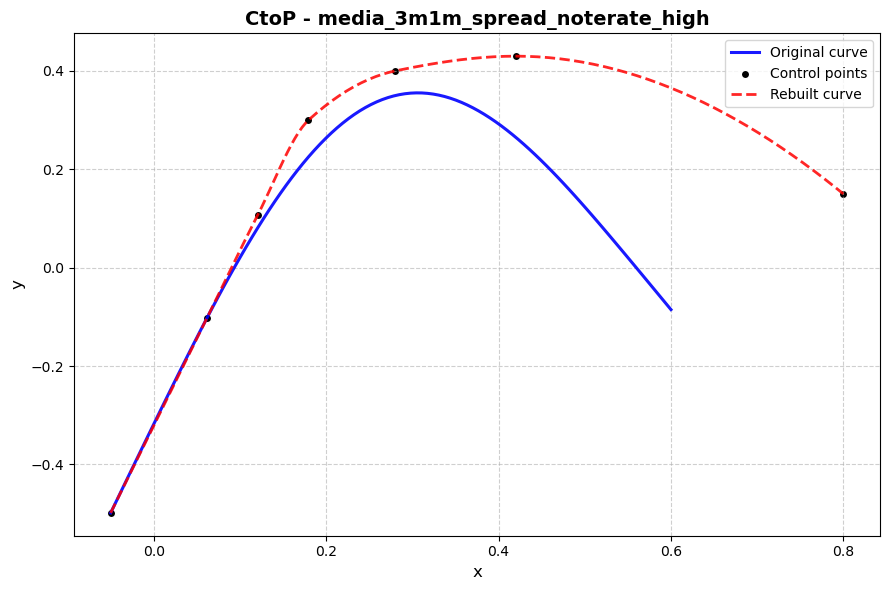

curve_x_media_3m1m_spread_noterate_high	-0.05,-0.0457286432161,-0.0414572864322,-0.0371859296482,-0.0329145728643,-0.0286432160804,-0.0243718592965,-0.0201005025126,-0.0158291457286,-0.0115577889447,-0.0072864321608,-0.00301507537688,0.00125628140704,0.00552763819095,0.00979899497487,0.0140703517588,0.0183417085427,0.0226130653266,0.0268844221106,0.0311557788945,0.0354271356784,0.0396984924623,0.0439698492462,0.0482412060302,0.0525125628141,0.056783919598,0.0610552763819,0.0653266331658,0.0695979899497,0.0738693467337,0.0781407035176,0.0824120603015,0.0866834170854,0.0909547738693,0.0952261306533,0.0994974874372,0.103768844221,0.108040201005,0.112311557789,0.116582914573,0.120854271357,0.125125628141,0.129396984925,0.133668341709,0.137939698492,0.142211055276,0.14648241206,0.150753768844,0.155025125628,0.159296482412,0.163567839196,0.16783919598,0.172110552764,0.176381909548,0.180653266332,0.184924623116,0.189195979899,0.193467336683,0.197738693467,0.202010050251,0.206281407035,0.21055

In [499]:
model = read_model_file(r"C:\Git\LMSimData\data\JUMBO2\ModelFiles\1.8.0\original\jumbo_refinance_1.5.update_2026_01_06_17_23_02.143751.txt")

df_original = pd.DataFrame({
    "x": model["curve_x_media_3m1m_spread_noterate_high"],
    "y": model["curve_y_media_3m1m_spread_noterate_high"]
})

controls = extract_control_points(df_original["x"], df_original["y"], tolerance=0.005)
print("Control points:", controls) 

df_curve = rebuild_curve(
    controls=[(-0.05, -0.498430790342934), (0.0616161616161616, -0.102615300986624), (0.120707070707071, 0.107404115236169), (0.17949494949495, 0.3), (0.28, 0.4), (0.42, 0.43), (0.8, 0.15)],
    x_original=model["curve_x_media_3m1m_spread_noterate_high"],
    y_original=model["curve_y_media_3m1m_spread_noterate_high"],
    method="pchip",
    title='CtoP - media_3m1m_spread_noterate_high'
)

formatted_txt = format_curve_df(df_curve, "media_3m1m_spread_noterate_high")
print(formatted_txt)

Control points: [(0.991414141, -0.099530896), (1.072577534, -0.109141053), (1.103261256, -0.090613466), (1.139883762, -0.02890254), (1.188383838, 0.104481085)]


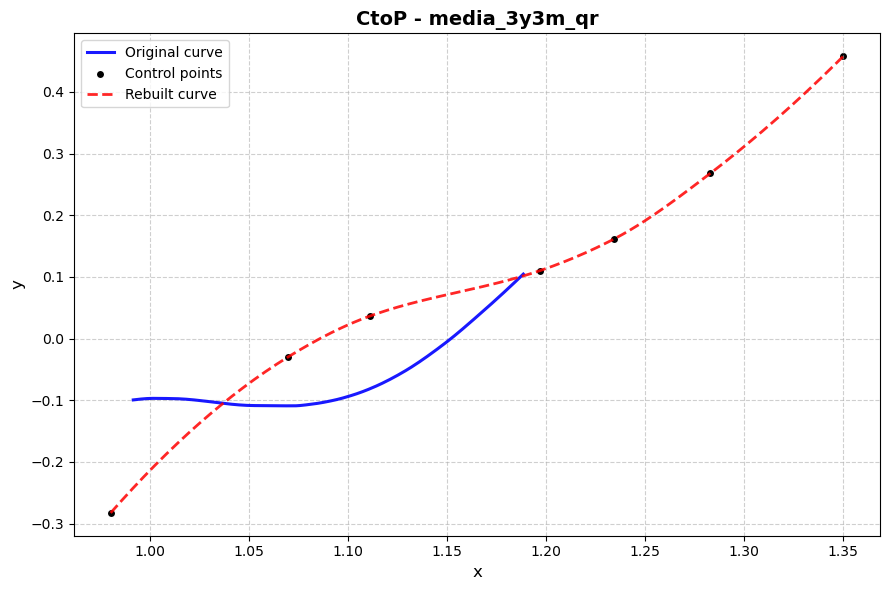

curve_x_media_3y3m_qr	0.98,0.981859296482,0.983718592965,0.985577889447,0.98743718593,0.989296482412,0.991155778894,0.993015075377,0.994874371859,0.996733668342,0.998592964824,1.00045226131,1.00231155779,1.00417085427,1.00603015075,1.00788944724,1.00974874372,1.0116080402,1.01346733668,1.01532663317,1.01718592965,1.01904522613,1.02090452261,1.0227638191,1.02462311558,1.02648241206,1.02834170854,1.03020100503,1.03206030151,1.03391959799,1.03577889447,1.03763819095,1.03949748744,1.04135678392,1.0432160804,1.04507537688,1.04693467337,1.04879396985,1.05065326633,1.05251256281,1.0543718593,1.05623115578,1.05809045226,1.05994974874,1.06180904523,1.06366834171,1.06552763819,1.06738693467,1.06924623116,1.07110552764,1.07296482412,1.0748241206,1.07668341709,1.07854271357,1.08040201005,1.08226130653,1.08412060302,1.0859798995,1.08783919598,1.08969849246,1.09155778894,1.09341708543,1.09527638191,1.09713567839,1.09899497487,1.10085427136,1.10271356784,1.10457286432,1.1064321608,1.10829145729,1.110

In [193]:
model = read_model_file(r"N:\LMSimData\data\JUMBO2\ModelFiles\1.8.0\jumbo_refinance_1.5.update_2025_11_30_17_12_13.138016.txt")

import re

s = model["curve_y_media_3y3m_qr"]
nums = re.findall(r'[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?', s)  # extract numeric substrings
y_list = [float(n) for n in nums]


df_original = pd.DataFrame({
    "x": model["curve_x_media_3y3m_qr"],
    "y": y_list
})

controls = extract_control_points(df_original["x"], df_original["y"], tolerance=0.005)
print("Control points:", controls) 

df_curve = rebuild_curve(
    controls=[(0.98, -0.2827641696329), (1.06969696969697, -0.0296604995376207), (1.11080808080808, 0.0363340537681103), (1.19676767676768, 0.110110623100955), (1.23414141414141, 0.161363505619961), (1.28272727272727, 0.267686153304524), (1.35, 0.457968867294782)],
    x_original=model["curve_x_media_3y3m_qr"],
    y_original=y_list,
    method="pchip",
    title='CtoP - media_3y3m_qr'
)

formatted_txt = format_curve_df(df_curve, "media_3y3m_qr")
print(formatted_txt)

Control points: [(0.0, 0.0300868448961), (18.8442211055, -0.243281398226), (37.6884422111, -0.485918567209), (56.5326633166, -0.697650696127), (75.3768844221, -0.878303819056), (94.2211055276, -1.02770397007), (112.311557789, -1.14156383416), (131.155778894, -1.22976036818), (150.0, -1.288)]


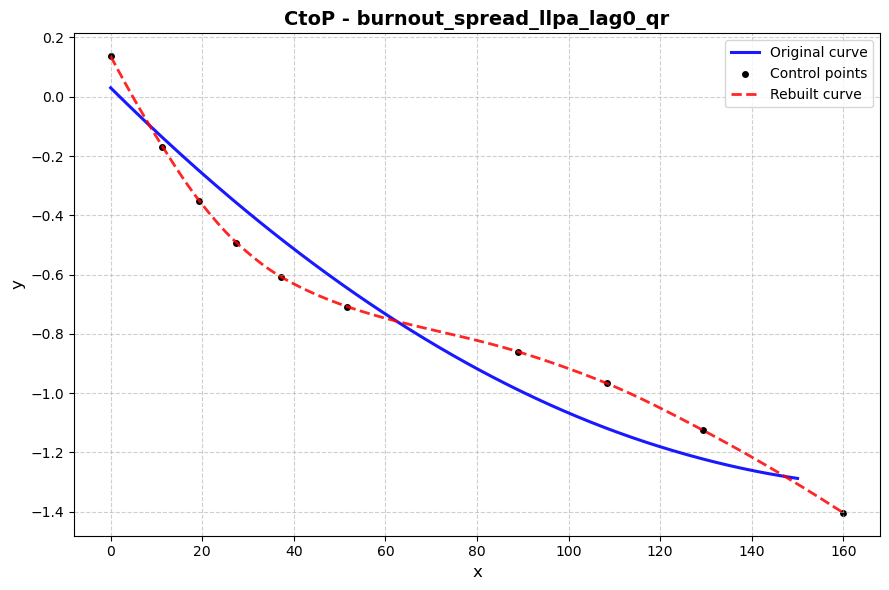

curve_x_burnout_spread_llpa_lag0_qr	0,0.804020100503,1.60804020101,2.41206030151,3.21608040201,4.02010050251,4.82412060302,5.62814070352,6.43216080402,7.23618090452,8.04020100503,8.84422110553,9.64824120603,10.4522613065,11.256281407,12.0603015075,12.864321608,13.6683417085,14.472361809,15.2763819095,16.0804020101,16.8844221106,17.6884422111,18.4924623116,19.2964824121,20.1005025126,20.9045226131,21.7085427136,22.5125628141,23.3165829146,24.1206030151,24.9246231156,25.7286432161,26.5326633166,27.3366834171,28.1407035176,28.9447236181,29.7487437186,30.5527638191,31.3567839196,32.1608040201,32.9648241206,33.7688442211,34.5728643216,35.3768844221,36.1809045226,36.9849246231,37.7889447236,38.5929648241,39.3969849246,40.2010050251,41.0050251256,41.8090452261,42.6130653266,43.4170854271,44.2211055276,45.0251256281,45.8291457286,46.6331658291,47.4371859296,48.2412060302,49.0452261307,49.8492462312,50.6532663317,51.4572864322,52.2613065327,53.0653266332,53.8693467337,54.6733668342,55.477386934

In [179]:
model = read_model_file(r"N:\LMSimData\data\JUMBO2\ModelFiles\1.8.0\jumbo_refinance_1.5.update_2025_11_30_17_12_13.138016.txt")

df_original = pd.DataFrame({
    "x": model["curve_x_burnout_spread_llpa_lag0_qr"],
    "y": model["curve_y_burnout_spread_llpa_lag0_qr"]
})

controls = extract_control_points(df_original["x"], df_original["y"], tolerance=0.01)
print("Control points:", controls) 

df_curve = rebuild_curve(
    controls=[(0.0, 0.13689715132361), (11.3131313131313, -0.167935219350009), (19.3939393939394, -0.351872826328811), (27.4747474747475, -0.492238651766649), (37.1717171717172, -0.607537978424916), (51.7171717171717, -0.70846952112904), (88.8888888888889, -0.86001813691474), (108.282828282828, -0.966787772516397), (129.292929292929, -1.12496056169399), (160.0, -1.40431909826085)],
    x_original=model["curve_x_burnout_spread_llpa_lag0_qr"],
    y_original=model["curve_y_burnout_spread_llpa_lag0_qr"],
    method="pchip",
    title='CtoP - burnout_spread_llpa_lag0_qr'
)


formatted_txt = format_curve_df(df_curve, "burnout_spread_llpa_lag0_qr")
print(formatted_txt)


In [ ]:
controls=[(-0.05, -0.270114703998418), (0.0878787878787879, -0.143797296265843), (0.14040404040404, -0.0753691068684457), (0.2, 0.38), (0.350505050505051, 0.5), (0.421422768, 0.473816167685767), (0.48, 0.42913087930743),  (0.6, 0.35)],

6m

In [484]:
len(model["curve_y_media_6m1m_spread_noterate_high"])

200

In [483]:
len(model["curve_x_media_6m1m_spread_noterate_low"])

100

In [485]:
model["curve_x_media_6m1m_spread_noterate_low"]

[-0.05,
 -0.0434343434343434,
 -0.0368686868686869,
 -0.0303030303030303,
 -0.0237373737373737,
 -0.0171717171717172,
 -0.0106060606060606,
 -0.00404040404040404,
 0.00252525252525253,
 0.00909090909090909,
 0.0156565656565657,
 0.0222222222222222,
 0.0287878787878788,
 0.0353535353535354,
 0.0419191919191919,
 0.0484848484848485,
 0.0550505050505051,
 0.0616161616161616,
 0.0681818181818182,
 0.0747474747474748,
 0.0813131313131313,
 0.0878787878787879,
 0.0944444444444445,
 0.101010101010101,
 0.107575757575758,
 0.114141414141414,
 0.120707070707071,
 0.127272727272727,
 0.133838383838384,
 0.14040404040404,
 0.146969696969697,
 0.153535353535354,
 0.16010101010101,
 0.166666666666667,
 0.173232323232323,
 0.17979797979798,
 0.186363636363636,
 0.192929292929293,
 0.19949494949495,
 0.206060606060606,
 0.212626262626263,
 0.219191919191919,
 0.225757575757576,
 0.232323232323232,
 0.238888888888889,
 0.245454545454545,
 0.252020202020202,
 0.258585858585859,
 0.265151515151515,
 0.2

Control points: [(-0.05, -0.591562526305621), (0.0616161616161616, -0.118383621895888), (0.133838383838384, 0.138812669218781), (0.19949494949495, 0.297904819789391), (0.232323232323232, 0.343965748349365), (0.265151515151515, 0.366506356824311), (0.297979797979798, 0.365866558002629), (0.330808080808081, 0.343243419802582), (0.363636363636364, 0.300559594589707), (0.403030303030303, 0.226178718868872), (0.481818181818182, 0.0190673417522637), (0.6, -0.36547275473166)]


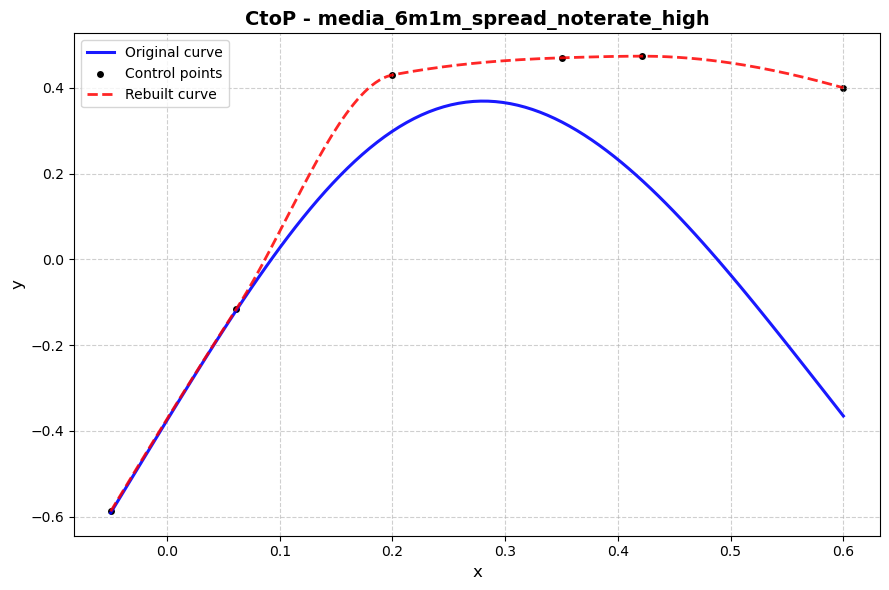

curve_x_media_6m1m_spread_noterate_high	-0.05,-0.0467336683417,-0.0434673366834,-0.0402010050251,-0.0369346733668,-0.0336683417085,-0.0304020100503,-0.027135678392,-0.0238693467337,-0.0206030150754,-0.0173366834171,-0.0140703517588,-0.0108040201005,-0.00753768844221,-0.00427135678392,-0.00100502512563,0.00226130653266,0.00552763819095,0.00879396984925,0.0120603015075,0.0153266331658,0.0185929648241,0.0218592964824,0.0251256281407,0.028391959799,0.0316582914573,0.0349246231156,0.0381909547739,0.0414572864322,0.0447236180905,0.0479899497487,0.051256281407,0.0545226130653,0.0577889447236,0.0610552763819,0.0643216080402,0.0675879396985,0.0708542713568,0.0741206030151,0.0773869346734,0.0806532663317,0.0839195979899,0.0871859296482,0.0904522613065,0.0937185929648,0.0969849246231,0.100251256281,0.10351758794,0.106783919598,0.110050251256,0.113316582915,0.116582914573,0.119849246231,0.123115577889,0.126381909548,0.129648241206,0.132914572864,0.136180904523,0.139447236181,0.142713567839,0.14597

In [83]:
model = read_model_file(r"C:\Git\LMSimData\data\JUMBO2\ModelFiles\1.8.1\original\jumbo_refinance_1.5.update_2026_02_10_10_36_41.946555.txt")

df_original = pd.DataFrame({
    "x": model["curve_x_media_6m1m_spread_noterate_high"],
    "y": model["curve_y_media_6m1m_spread_noterate_high"]
})

controls = extract_control_points(df_original["x"], df_original["y"], tolerance=0.005)
print("Control points:", controls) 

df_curve = rebuild_curve(
    #controls=[(-0.05, -0.270114703998418), (0.1, 0.0), (0.2, 0.4), (0.350505050505051, 0.47), (0.421422768, 0.473816167685767),  (0.6, 0.3)],
    
    controls=[(-0.05, -0.587988793294073), (0.0616161616161616, -0.11536750908101), (0.2, 0.43), (0.350505050505051, 0.47), (0.421422768, 0.473816167685767), (0.6, 0.4)], # ,  (0.6, 0.3)
    x_original=model["curve_x_media_6m1m_spread_noterate_high"],
    y_original=model["curve_y_media_6m1m_spread_noterate_high"],
    method="pchip",
    title='CtoP - media_6m1m_spread_noterate_high'
)

formatted_txt = format_curve_df(df_curve, "media_6m1m_spread_noterate_high")
print(formatted_txt)

Control points: [(-0.0999999999999996, -2.33787980371246), (0.196969696969697, -0.945475196017775), (0.387878787878788, -0.198804253835552), (0.557575757575758, 0.27211624769197), (0.896969696969697, 0.999166282296196), (1.02424242424242, 1.23692872059539), (1.13030303030303, 1.38350193534358), (1.38484848484848, 1.59075405944929), (1.61818181818182, 1.80635217607592), (1.72424242424242, 1.88307429796757), (1.80909090909091, 1.91992750774177), (1.89393939393939, 1.93117797932811), (2.0, 1.91863795598114)]


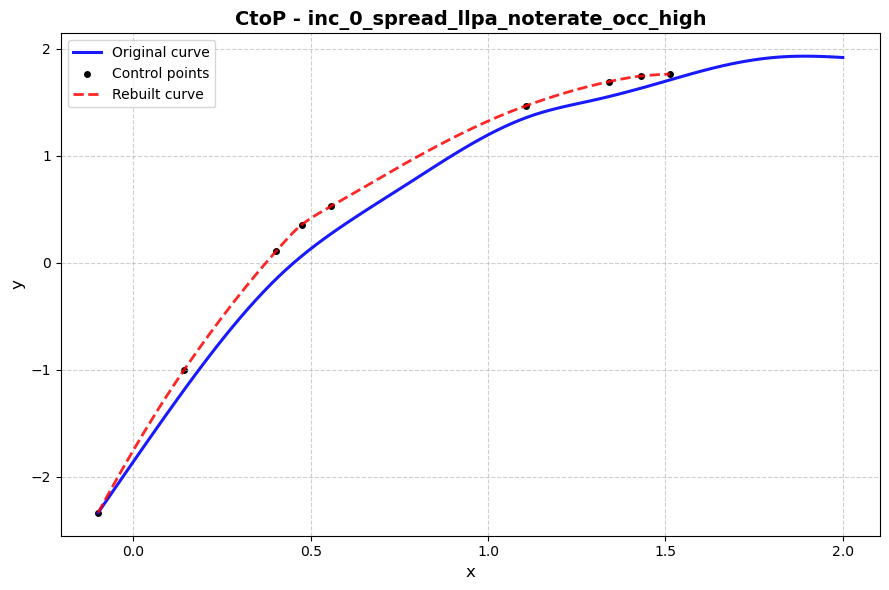

curve_x_inc_0_spread_llpa_noterate_occ_high	-0.1,-0.0918988883813,-0.0837977767626,-0.0756966651439,-0.0675955535252,-0.0594944419065,-0.0513933302878,-0.0432922186691,-0.0351911070505,-0.0270899954318,-0.0189888838131,-0.0108877721944,-0.00278666057568,0.00531445104302,0.0134155626617,0.0215166742804,0.0296177858991,0.0377188975178,0.0458200091365,0.0539211207552,0.0620222323739,0.0701233439926,0.0782244556113,0.08632556723,0.0944266788486,0.102527790467,0.110628902086,0.118730013705,0.126831125323,0.134932236942,0.143033348561,0.151134460179,0.159235571798,0.167336683417,0.175437795036,0.183538906654,0.191640018273,0.199741129892,0.20784224151,0.215943353129,0.224044464748,0.232145576366,0.240246687985,0.248347799604,0.256448911223,0.264550022841,0.27265113446,0.280752246079,0.288853357697,0.296954469316,0.305055580935,0.313156692553,0.321257804172,0.329358915791,0.337460027409,0.345561139028,0.353662250647,0.361763362266,0.369864473884,0.377965585503,0.386066697122,0.39416780874,0.4

In [81]:
model = read_model_file(r"C:\Git\LMSimData\data\JUMBO2\ModelFiles\1.8.1\original\jumbo_refinance_1.5.update_2026_02_10_10_36_41.946555.txt")

df_original = pd.DataFrame({
    "x": model["curve_x_inc_0_spread_llpa_noterate_occ_high"],
    "y": model["curve_y_inc_0_spread_llpa_noterate_occ_high"]
})

controls = extract_control_points(df_original["x"], df_original["y"], tolerance=0.01)
print("Control points:", controls) 

df_curve = rebuild_curve(
    controls=[(-0.0999999999999996, -2.33787980371246), (0.143033348561, -0.999767213209), (0.402268920359, 0.108727460797), (0.475178924928, 0.357599114203), (0.556190041115, 0.526251462696), (1.10706563119, 1.46791572749), (1.34199786813, 1.6939283089), (1.43111009593, 1.7452170075), (1.51212121212, 1.76336770383)],
    x_original=model["curve_x_inc_0_spread_llpa_noterate_occ_high"],
    y_original=model["curve_y_inc_0_spread_llpa_noterate_occ_high"],
    method="pchip",
    title='CtoP - inc_0_spread_llpa_noterate_occ_high'
)

formatted_txt = format_curve_df(df_curve, "inc_0_spread_llpa_noterate_occ_high")
print(formatted_txt)

Control points: [(-0.0999999999999996, -2.3343838823892), (0.303030303030303, -0.467153378764502), (0.451515151515152, 0.0678774104861865), (0.578787878787879, 0.399465206252584), (0.706060606060606, 0.62375687463197), (1.15151515151515, 1.26910235993707), (1.3, 1.43503425166346), (1.80909090909091, 1.92796666934677), (2.0, 2.16417790216478)]


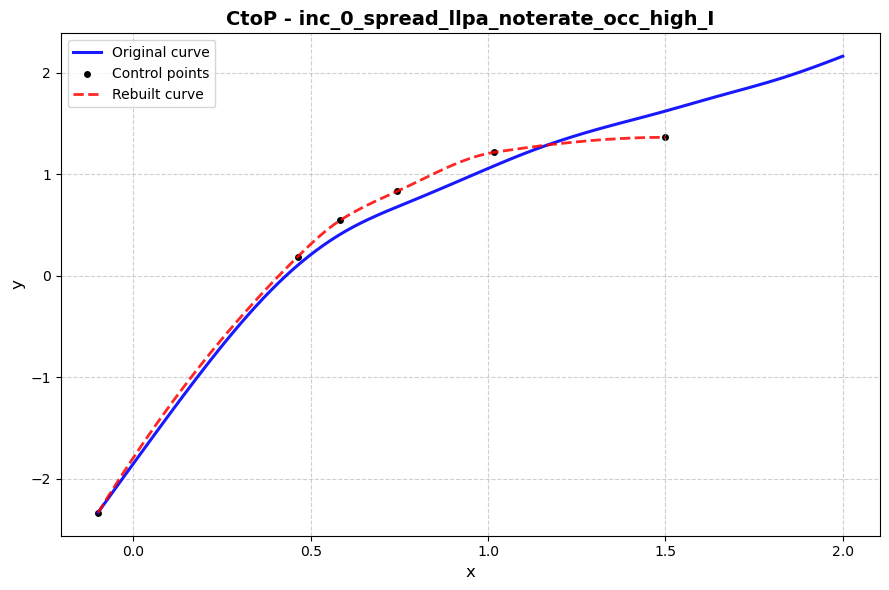

curve_x_inc_0_spread_llpa_noterate_occ_high_I	-0.1,-0.091959798995,-0.0839195979899,-0.0758793969849,-0.0678391959799,-0.0597989949749,-0.0517587939698,-0.0437185929648,-0.0356783919598,-0.0276381909548,-0.0195979899497,-0.0115577889447,-0.0035175879397,0.00452261306533,0.0125628140704,0.0206030150754,0.0286432160804,0.0366834170854,0.0447236180905,0.0527638190955,0.0608040201005,0.0688442211055,0.0768844221106,0.0849246231156,0.0929648241206,0.101005025126,0.109045226131,0.117085427136,0.125125628141,0.133165829146,0.141206030151,0.149246231156,0.157286432161,0.165326633166,0.173366834171,0.181407035176,0.189447236181,0.197487437186,0.205527638191,0.213567839196,0.221608040201,0.229648241206,0.237688442211,0.245728643216,0.253768844221,0.261809045226,0.269849246231,0.277889447236,0.285929648241,0.293969849246,0.302010050251,0.310050251256,0.318090452261,0.326130653266,0.334170854271,0.342211055276,0.350251256281,0.358291457286,0.366331658291,0.374371859296,0.382412060302,0.39045226130

In [88]:
model = read_model_file(r"C:\Git\LMSimData\data\JUMBO2\ModelFiles\1.8.1\original\jumbo_refinance_1.5.update_2026_02_10_10_36_41.946555.txt")

df_original = pd.DataFrame({
    "x": model["curve_x_inc_0_spread_llpa_noterate_occ_high_I"],
    "y": model["curve_y_inc_0_spread_llpa_noterate_occ_high_I"]
})

controls = extract_control_points(df_original["x"], df_original["y"], tolerance=0.01)
print("Control points:", controls) 

df_curve = rebuild_curve(
    controls=[(-0.0999999999999996, -2.33787980371246), (0.462814070352, 0.1864915240328), (0.582198873154, 0.54464115996), (0.744221105528, 0.833178816666), (1.01710065479, 1.21636844144), (1.5, 1.36422480715)], # , 
    x_original=model["curve_x_inc_0_spread_llpa_noterate_occ_high_I"],
    y_original=model["curve_y_inc_0_spread_llpa_noterate_occ_high_I"],
    method="pchip",
    title='CtoP - inc_0_spread_llpa_noterate_occ_high_I'
)

formatted_txt = format_curve_df(df_curve, "inc_0_spread_llpa_noterate_occ_high_I")
print(formatted_txt)